<a href="https://colab.research.google.com/github/dilgc/Dilger-Group-Project-3/blob/main/Dilger_Imran_Group_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIM460 Group Project 3**
## By Charles Dilger and Ahsan Imran
___________________________________________


## **HOW TO RUN**

**Runtime** Type: Python 3

Click Runtime → Change runtime type

Select Python 3 as Runtime type

Select T4 GPU as Hardware accelerator (optional)

Click Save

Run the following cells first:

In [47]:
# Install required packages (run this cell first)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn pandas numpy matplotlib seaborn

# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

Looking in indexes: https://download.pytorch.org/whl/cu118


In [46]:
# Set all random seeds for reproducible results
import random

def set_all_seeds(seed=42):
    """Set seeds for all random number generators"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply fixed seeds
set_all_seeds(42)
print("✅ All random seeds set to 42 for reproducibility")

✅ All random seeds set to 42 for reproducibility


# **NY Housing Dataset**

First, let's load our first dataset. It will be on housing data in New York. We will be using the Federal Reserve Economic Data (FRED) API. Immediately upon loading the data, we will do a few quick tests to ensure the data is loaded properly. This includes observing the dataset shape, the features, and the data quality or completeness. If all looks good, we can continue with visualizing this data. Eventually, we will aim to predict the NY house pricing index.

In [1]:
# AIM 460 Project 3: NY Housing Data Loader (Dataset 1 - API Source)
# This loads ONLY New York housing data from FRED API

import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time

# ============================
# NY HOUSING DATA LOADER
# ============================

def get_fred_api_key_info():
    """
    Information on getting a free FRED API key
    """
    print("📋 To get a FREE FRED API key:")
    print("   1. Go to: https://fred.stlouisfed.org/docs/api/api_key.html")
    print("   2. Click 'Request API Key'")
    print("   3. Sign up with your email (takes 2 minutes)")
    print("   4. Copy your API key")
    print("   5. Replace 'YOUR_FRED_API_KEY' in the code")
    print()

def load_ny_housing_data(api_key):
    """
    Load New York housing data from FRED API

    Args:
        api_key (str): Your FRED API key

    Returns:
        pandas.DataFrame: NY housing time series data
    """
    print("🗽 Loading New York Housing Data from FRED API...")

    if api_key == "YOUR_FRED_API_KEY":
        print("❌ Please get your free FRED API key first!")
        get_fred_api_key_info()
        return None

    # New York housing data series
    ny_housing_series = {
        'ny_house_price_index': 'NYSTHPI',              # NY State House Price Index
        'ny_housing_permits': 'NEWY636BP1FH',           # NY Housing Building Permits
        'ny_housing_starts': 'NEWY636BPPRIV',           # NY Private Housing Starts
        'albany_house_price': 'ATNHPIUS10580Q',         # Albany-Schenectady-Troy Metro
        'buffalo_house_price': 'ATNHPIUS15380Q',        # Buffalo-Cheektowaga Metro
        'rochester_house_price': 'ATNHPIUS40380Q',      # Rochester Metro
        'syracuse_house_price': 'ATNHPIUS45060Q',       # Syracuse Metro
        'ny_median_income': 'MEHOINUSNYS672N',          # NY Median Household Income
        'ny_unemployment_rate': 'NYUR',                 # NY Unemployment Rate
        'mortgage_rate_30yr': 'MORTGAGE30US',           # 30-Year Mortgage Rate (national)
    }

    base_url = "https://api.stlouisfed.org/fred/series/observations"
    all_data = []

    print(f"   Fetching {len(ny_housing_series)} NY housing metrics...")

    for metric_name, series_id in ny_housing_series.items():
        try:
            params = {
                'series_id': series_id,
                'api_key': api_key,
                'file_type': 'json',
                'start_date': '2015-01-01',
                'end_date': '2025-01-01'
            }

            response = requests.get(base_url, params=params)

            if response.status_code == 200:
                data = response.json()

                if 'observations' in data:
                    observations = data['observations']
                    valid_count = 0

                    for obs in observations:
                        if obs['value'] != '.':  # Skip missing values
                            all_data.append({
                                'date': obs['date'],
                                'metric': metric_name,
                                'value': float(obs['value'])
                            })
                            valid_count += 1

                    print(f"   ✅ {metric_name}: {valid_count} records")
                else:
                    print(f"   ⚠️  {metric_name}: No data available")
            else:
                print(f"   ❌ {metric_name}: HTTP {response.status_code}")

            time.sleep(0.1)  # Rate limiting

        except Exception as e:
            print(f"   ❌ {metric_name}: {e}")
            continue

    if all_data:
        print(f"   ✅ Total NY records collected: {len(all_data)}")
        df = pd.DataFrame(all_data)
        df['date'] = pd.to_datetime(df['date'])
        return df.sort_values('date')
    else:
        print("   ❌ No NY data collected")
        return None

def transform_ny_data(ny_df):
    """
    Transform NY time series data into ML-ready dataset

    Args:
        ny_df (pandas.DataFrame): Raw NY time series data

    Returns:
        pandas.DataFrame: ML-ready NY housing dataset
    """
    print("🔄 Transforming NY data for machine learning...")

    if ny_df is None:
        return None

    # Pivot data: each row = date, each column = housing metric
    pivot_df = ny_df.pivot_table(
        index='date',
        columns='metric',
        values='value',
        aggfunc='first'
    ).reset_index()

    # Fill missing values
    pivot_df = pivot_df.ffill().bfill()

    # Create derived features
    print("   Creating NY-specific features...")

    # Price growth rates
    if 'ny_house_price_index' in pivot_df.columns:
        pivot_df['ny_price_growth_1yr'] = pivot_df['ny_house_price_index'].pct_change(periods=4)  # Quarterly data
        pivot_df['ny_price_growth_3yr'] = pivot_df['ny_house_price_index'].pct_change(periods=12)

    # Housing market activity
    if 'ny_housing_permits' in pivot_df.columns:
        pivot_df['ny_permits_ma_12m'] = pivot_df['ny_housing_permits'].rolling(window=12).mean()
        pivot_df['ny_permits_growth'] = pivot_df['ny_housing_permits'].pct_change(periods=4)

    # Regional price variations
    metro_cols = ['albany_house_price', 'buffalo_house_price', 'rochester_house_price', 'syracuse_house_price']
    available_metros = [col for col in metro_cols if col in pivot_df.columns]

    if len(available_metros) >= 2:
        pivot_df['ny_metro_price_avg'] = pivot_df[available_metros].mean(axis=1)
        if 'ny_house_price_index' in pivot_df.columns:
            pivot_df['ny_state_vs_metro_ratio'] = pivot_df['ny_house_price_index'] / pivot_df['ny_metro_price_avg']

    # Economic indicators
    if 'mortgage_rate_30yr' in pivot_df.columns and 'ny_median_income' in pivot_df.columns:
        # Housing affordability proxy
        if 'ny_house_price_index' in pivot_df.columns:
            pivot_df['ny_affordability_index'] = pivot_df['ny_median_income'] / (pivot_df['ny_house_price_index'] * pivot_df['mortgage_rate_30yr'])

    # Time features
    pivot_df['year'] = pivot_df['date'].dt.year
    pivot_df['month'] = pivot_df['date'].dt.month
    pivot_df['quarter'] = pivot_df['date'].dt.quarter
    pivot_df['is_recession_period'] = ((pivot_df['year'] == 2020) | (pivot_df['year'] == 2008)).astype(int)

    # Lagged features for time series modeling
    lag_columns = ['ny_house_price_index', 'ny_housing_permits', 'mortgage_rate_30yr']
    for col in lag_columns:
        if col in pivot_df.columns:
            pivot_df[f'{col}_lag1'] = pivot_df[col].shift(1)
            pivot_df[f'{col}_lag4'] = pivot_df[col].shift(4)  # 1 year lag for quarterly data

    # Drop rows with too many missing values
    pivot_df = pivot_df.dropna(thresh=int(len(pivot_df.columns) * 0.6))

    print(f"   ✅ NY dataset ready: {len(pivot_df)} rows, {len(pivot_df.columns)} features")
    return pivot_df

def verify_ny_dataset(ny_data):
    """
    Verify NY housing data meets assignment requirements

    Args:
        ny_data (pandas.DataFrame): NY housing dataset
    """
    print("\n" + "="*50)
    print("🗽 NY HOUSING DATA VERIFICATION (Dataset 1)")
    print("="*50)

    if ny_data is None:
        print("❌ No NY data loaded!")
        return

    # Assignment requirements
    rows, cols = ny_data.shape
    print(f"Dataset Shape: {rows} rows × {cols} columns")

    meets_rows = rows >= 3000
    meets_cols = cols >= 5

    print(f"\n🎯 ASSIGNMENT REQUIREMENTS:")
    print(f"   ≥3,000 examples: {'✅ PASS' if meets_rows else '❌ FAIL'} ({rows:,} rows)")
    print(f"   ≥5 features: {'✅ PASS' if meets_cols else '❌ FAIL'} ({cols} features)")
    print(f"   API source: ✅ PASS (FRED API)")

    # Show NY housing features
    print(f"\n🏠 NY HOUSING FEATURES:")
    housing_features = [col for col in ny_data.columns if any(keyword in col.lower()
                       for keyword in ['price', 'house', 'housing', 'permit', 'income', 'mortgage', 'afford'])]

    for i, feature in enumerate(housing_features[:12], 1):  # Show top 12
        non_null = ny_data[feature].count()
        pct = (non_null / len(ny_data)) * 100
        print(f"   {i:2d}. {feature:30s} ({non_null:4d} values, {pct:5.1f}% complete)")

    # Time range
    if 'date' in ny_data.columns:
        start_date = ny_data['date'].min()
        end_date = ny_data['date'].max()
        print(f"\n📅 TIME PERIOD: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
        years = (end_date - start_date).days / 365.25
        print(f"   Duration: {years:.1f} years")

    # Sample data
    print(f"\n📊 SAMPLE DATA (3 recent records):")
    if len(ny_data) >= 3:
        sample_cols = ['date'] + housing_features[:4]
        display_data = ny_data[sample_cols].tail(3) if 'date' in ny_data.columns else ny_data[sample_cols[:5]].tail(3)
        print(display_data.to_string(index=False))

    # Data quality
    complete_rows = ny_data.dropna().shape[0]
    print(f"\n✅ DATA QUALITY:")
    print(f"   Complete records (no missing): {complete_rows:,}")
    print(f"   Records with some missing: {rows - complete_rows:,}")
    print(f"   Overall completeness: {(complete_rows/rows*100):.1f}%")

    print(f"\n🎉 SUMMARY:")
    if meets_rows and meets_cols:
        print("   ✅ NY dataset ready for feature engineering!")
        print("   ✅ Perfect for training models")
        print("   ✅ Time series structure ready for RNN")
    else:
        if not meets_rows:
            print(f"   ⚠️  Need {3000 - rows:,} more rows for requirement")
        if not meets_cols:
            print(f"   ⚠️  Need {5 - cols} more features for requirement")

# ============================
# MAIN EXECUTION
# ============================

def main():
    """
    Load and verify NY housing data (Dataset 1)
    """
    print("🚀 AIM 460 Project 3 - Dataset 1: NY Housing Data")
    print("   Source: FRED API (Federal Reserve Economic Data)")
    print()

    # Your FRED API key
    FRED_API_KEY = "5be1dfe82f1acbf9fca6d6b4718480eb"  # Replace with your actual key

    if FRED_API_KEY == "YOUR_FRED_API_KEY":
        print("❌ Please get your free FRED API key first!")
        get_fred_api_key_info()
        return None

    # Load NY housing time series
    ny_raw_data = load_ny_housing_data(FRED_API_KEY)

    # Transform for ML
    ny_dataset = transform_ny_data(ny_raw_data)

    # Verify dataset
    verify_ny_dataset(ny_dataset)

    if ny_dataset is not None:
        print(f"\n🔧 USAGE:")
        print(f"   Your NY dataset: ny_dataset")
        print(f"   Example: ny_dataset.head()")
        print(f"   Example: ny_dataset.describe()")
        print(f"   Columns: {list(ny_dataset.columns)}")

    return ny_dataset

# Run the NY data collection
if __name__ == "__main__":
    ny_housing_dataset = main()

🚀 AIM 460 Project 3 - Dataset 1: NY Housing Data
   Source: FRED API (Federal Reserve Economic Data)

🗽 Loading New York Housing Data from FRED API...
   Fetching 10 NY housing metrics...
   ✅ ny_house_price_index: 202 records
   ✅ ny_housing_permits: 451 records
   ✅ ny_housing_starts: 451 records
   ✅ albany_house_price: 183 records
   ✅ buffalo_house_price: 192 records
   ✅ rochester_house_price: 188 records
   ✅ syracuse_house_price: 189 records
   ❌ ny_median_income: HTTP 400
   ✅ ny_unemployment_rate: 595 records
   ✅ mortgage_rate_30yr: 2843 records
   ✅ Total NY records collected: 5294
🔄 Transforming NY data for machine learning...
   Creating NY-specific features...
   ✅ NY dataset ready: 3363 rows, 26 features

🗽 NY HOUSING DATA VERIFICATION (Dataset 1)
Dataset Shape: 3363 rows × 26 columns

🎯 ASSIGNMENT REQUIREMENTS:
   ≥3,000 examples: ✅ PASS (3,363 rows)
   ≥5 features: ✅ PASS (26 features)
   API source: ✅ PASS (FRED API)

🏠 NY HOUSING FEATURES:
    1. albany_house_price 

Great, our dataset contains 3,350 complete records. It includes housing prices and a lot of additional features to consider in our model, that spans over 50 years. We have 12 missing datapoints, which we will have to remove or impute. Retrieving the median income seemed to result in an HTTP 400 error, so we will not be able to use that feature. Also, in order to predict average NY pricing, we will need to engineer a feature that averages out all the pricing for all the different cities.

Now let's repeat this process, this time with our second dataset of choice. It will be a different domain entirely. Our second dataset will be the ADRE ETF stock, locatable within Kaggle's Huge Stock Market Database: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Our target variable here, of course, will be the closing price. Now let's go through the process one more time.

In [2]:
# AIM 460 Project 3: ADRE ETF Stock Data Loader (Dataset 2 - Download Source)
# Load ADRE ETF stock data from GitHub

import pandas as pd
import numpy as np
from datetime import datetime

def load_adre_stock_data():
    """
    Load ADRE ETF stock data from GitHub

    Returns:
        pandas.DataFrame: ADRE stock data
    """
    print("📈 Loading ADRE ETF Stock Data from GitHub...")

    # Your GitHub CSV URL
    url = "https://raw.githubusercontent.com/dilgc/Dilger-Group-Project-3/main/ADRE%20ETF%20Stock.csv"

    try:
        print("   📥 Downloading ADRE ETF data...")
        df = pd.read_csv(url)

        print(f"   ✅ ADRE data loaded: {len(df)} records")
        return df

    except Exception as e:
        print(f"   ❌ Failed to load ADRE data: {e}")
        return None

def transform_adre_data(adre_df):
    """
    Transform ADRE stock data for ML

    Args:
        adre_df (pandas.DataFrame): Raw ADRE data

    Returns:
        pandas.DataFrame: ML-ready ADRE dataset
    """
    if adre_df is None:
        return None

    print("🔄 Transforming ADRE data for ML...")

    df = adre_df.copy()

    # Convert date
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    print("   Creating ADRE stock features...")

    # Basic stock features
    if 'Close' in df.columns:
        # Price returns
        df['adre_return_1d'] = df['Close'].pct_change()
        df['adre_return_5d'] = df['Close'].pct_change(periods=5)
        df['adre_return_20d'] = df['Close'].pct_change(periods=20)

        # Moving averages
        df['adre_ma_5d'] = df['Close'].rolling(5).mean()
        df['adre_ma_20d'] = df['Close'].rolling(20).mean()
        df['adre_ma_50d'] = df['Close'].rolling(50).mean()

        # Price momentum
        df['adre_above_ma20'] = (df['Close'] > df['adre_ma_20d']).astype(int)
        df['adre_price_trend'] = df['Close'] / df['adre_ma_20d']

    # Volatility
    if 'High' in df.columns and 'Low' in df.columns:
        df['adre_daily_range'] = (df['High'] - df['Low']) / df['Close']

    # Volume features
    if 'Volume' in df.columns:
        df['adre_volume_ma'] = df['Volume'].rolling(20).mean()
        df['adre_volume_ratio'] = df['Volume'] / df['adre_volume_ma']

    # Time features
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter

    # Lagged features
    for lag in [1, 5, 10]:
        df[f'adre_close_lag{lag}'] = df['Close'].shift(lag)

    # Fill missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].ffill().bfill()

    print(f"   ✅ ADRE dataset ready: {len(df)} rows, {len(df.columns)} features")
    return df

def verify_adre_dataset(adre_data):
    """
    Verify ADRE dataset meets project requirements
    """
    print("\n" + "="*50)
    print("📈 ADRE ETF DATA VERIFICATION (Dataset 2)")
    print("="*50)

    if adre_data is None:
        print("❌ No ADRE data loaded!")
        return

    rows, cols = adre_data.shape
    print(f"Dataset Shape: {rows} rows × {cols} columns")

    print(f"\n🎯 REQUIREMENTS:")
    print(f"   ≥3,000 examples: {'✅ PASS' if rows >= 3000 else '❌ FAIL'} ({rows:,} rows)")
    print(f"   ≥5 features: {'✅ PASS' if cols >= 5 else '❌ FAIL'} ({cols} features)")
    print(f"   Download source: ✅ PASS (GitHub)")
    print(f"   Different domain: ✅ PASS (Stocks vs Housing)")

    # Target variable
    target_col = 'Close'
    if target_col in adre_data.columns:
        target_stats = adre_data[target_col].describe()
        print(f"\n🎯 TARGET: ADRE Close Price")
        print(f"   Range: ${target_stats['min']:.2f} - ${target_stats['max']:.2f}")
        print(f"   Mean: ${target_stats['mean']:.2f}")

    # Time range
    if 'Date' in adre_data.columns:
        start_date = adre_data['Date'].min()
        end_date = adre_data['Date'].max()
        print(f"\n📅 TIME PERIOD: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    # Key features
    stock_features = [col for col in adre_data.columns if 'adre' in col.lower() or col in ['Open', 'High', 'Low', 'Close', 'Volume']]
    print(f"\n📊 KEY FEATURES:")
    for col in stock_features[:8]:
        if col in adre_data.columns:
            print(f"   {col}: {adre_data[col].count()} values")

    print(f"\n🎉 ADRE dataset ready!")
    print(f"   🎯 TARGET: Close price (stock price prediction)")

# Main execution
def main():
    """Load ADRE stock data"""
    print("🚀 Loading Dataset 2: ADRE ETF Stock Data")
    print("   Target: Close Price (Stock Price Prediction)")

    # Load ADRE data
    adre_raw = load_adre_stock_data()

    if adre_raw is None:
        return None

    # Transform for ML
    adre_dataset = transform_adre_data(adre_raw)

    # Verify
    verify_adre_dataset(adre_dataset)

    return adre_dataset

if __name__ == "__main__":
    adre_stock_dataset = main()

🚀 Loading Dataset 2: ADRE ETF Stock Data
   Target: Close Price (Stock Price Prediction)
📈 Loading ADRE ETF Stock Data from GitHub...
   📥 Downloading ADRE ETF data...
   ✅ ADRE data loaded: 3201 records
🔄 Transforming ADRE data for ML...
   Creating ADRE stock features...
   ✅ ADRE dataset ready: 3201 rows, 25 features

📈 ADRE ETF DATA VERIFICATION (Dataset 2)
Dataset Shape: 3201 rows × 25 columns

🎯 REQUIREMENTS:
   ≥3,000 examples: ✅ PASS (3,201 rows)
   ≥5 features: ✅ PASS (25 features)
   Download source: ✅ PASS (GitHub)
   Different domain: ✅ PASS (Stocks vs Housing)

🎯 TARGET: ADRE Close Price
   Range: $17.10 - $50.93
   Mean: $33.51

📅 TIME PERIOD: 2005-02-25 to 2017-11-10

📊 KEY FEATURES:
   Open: 3201 values
   High: 3201 values
   Low: 3201 values
   Close: 3201 values
   Volume: 3201 values
   adre_return_1d: 3201 values
   adre_return_5d: 3201 values
   adre_return_20d: 3201 values

🎉 ADRE dataset ready!
   🎯 TARGET: Close price (stock price prediction)


Now that both datasets have been successfully loaded, let's begin to analyze and preprocess the data for the first database, the NY housing database. Since we already know we are missing 12 values, let's work on those first. Since we have so much data, these 12 values are insignificant, and we can simply remove them.

In [3]:
# AIM 460 Project 3: NY Housing Data Preprocessing
# Step 1: Remove rows with missing data

import pandas as pd
import numpy as np

def preprocess_ny_housing_data(df):
    """
    Preprocess NY housing dataset by removing missing data in place

    Args:
        df (pandas.DataFrame): Raw NY housing dataset

    Returns:
        pandas.DataFrame: Cleaned NY housing dataset (same variable updated)
    """
    print("🧹 PREPROCESSING NY HOUSING DATA")
    print("="*50)

    print(f"Original dataset: {len(df)} rows, {len(df.columns)} columns")

    # Check for missing data
    print("\n📊 MISSING DATA ANALYSIS:")
    missing_counts = df.isnull().sum()
    missing_rows = df.isnull().any(axis=1).sum()

    print(f"   Rows with ANY missing data: {missing_rows}")
    print(f"   Complete rows (no missing): {len(df) - missing_rows}")

    columns_with_missing = missing_counts[missing_counts > 0]
    if len(columns_with_missing) > 0:
        print(f"\n   Columns with missing data:")
        for col, count in columns_with_missing.items():
            pct = (count / len(df)) * 100
            print(f"     {col}: {count} missing ({pct:.1f}%)")

    # Remove rows with missing data and update df in place
    print(f"\n🗑️  REMOVING MISSING DATA:")
    original_len = len(df)
    df.dropna(inplace=True)

    rows_removed = original_len - len(df)
    print(f"   Rows removed: {rows_removed}")
    print(f"   Rows remaining: {len(df)}")
    print(f"   Data retention: {(len(df)/original_len*100):.1f}%")

    remaining_missing = df.isnull().sum().sum()
    print(f"   Missing values remaining: {remaining_missing}")

    print(f"\n✅ REQUIREMENTS CHECK:")
    meets_rows = len(df) >= 3000
    print(f"   ≥3,000 examples: {'✅ PASS' if meets_rows else '❌ FAIL'} ({len(df):,} rows)")
    print(f"   ≥5 features: ✅ PASS ({len(df.columns)} features)")

    print(f"\n📋 CLEANED DATASET SUMMARY:")
    print(f"   Shape: {df.shape}")
    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   Complete records: {len(df):,}")

    return df

def show_data_before_after(original_df, cleaned_df):
    """
    Show comparison of data before and after cleaning
    """
    print("\n" + "="*50)
    print("📊 BEFORE vs AFTER COMPARISON")
    print("="*50)

    print("BEFORE (Original Data):")
    print(f"  Rows: {len(original_df):,}")
    print(f"  Missing values: {original_df.isnull().sum().sum():,}")
    print(f"  Complete rows: {len(original_df.dropna()):,}")

    print("\nAFTER (Cleaned Data):")
    print(f"  Rows: {len(cleaned_df):,}")
    print(f"  Missing values: {cleaned_df.isnull().sum().sum():,}")
    print(f"  Complete rows: {len(cleaned_df):,}")

    print(f"\nCHANGE:")
    print(f"  Rows removed: {len(original_df) - len(cleaned_df):,}")
    print(f"  Data retained: {(len(cleaned_df)/len(original_df)*100):.1f}%")

# Usage example
def preprocess_main(ny_dataset):
    """
    Main preprocessing workflow for NY housing data
    """
    print("🚀 Starting NY Housing Data Preprocessing")
    print("   Step 1: Remove missing data")

    # Preprocess the data
    ny_clean = preprocess_ny_housing_data(ny_dataset)

    # Show before/after comparison
    show_data_before_after(ny_dataset, ny_clean)

    if len(ny_clean) >= 3000:
        print("\n🎉 SUCCESS: Clean dataset ready for feature engineering!")
    else:
        print(f"\n⚠️  WARNING: Only {len(ny_clean)} rows remaining (need 3,000+)")

    return ny_clean

# Run preprocessing
if __name__ == "__main__":
    print("To run the complete pipeline:")
    print()
    print("# Step 1: Load NY data")
    print("from your_ny_loader import main as load_ny_data")
    print("ny_housing_dataset = load_ny_data()")
    print()
    print("# Step 2: Preprocess the data")
    print("ny_housing_clean = preprocess_main(ny_housing_dataset)")


if __name__ == "__main__":
    ny_housing_clean = preprocess_ny_housing_data(ny_housing_dataset)
    show_data_before_after(ny_housing_dataset, ny_housing_clean)

To run the complete pipeline:

# Step 1: Load NY data
from your_ny_loader import main as load_ny_data
ny_housing_dataset = load_ny_data()

# Step 2: Preprocess the data
ny_housing_clean = preprocess_main(ny_housing_dataset)
🧹 PREPROCESSING NY HOUSING DATA
Original dataset: 3363 rows, 26 columns

📊 MISSING DATA ANALYSIS:
   Rows with ANY missing data: 12
   Complete rows (no missing): 3351

   Columns with missing data:
     ny_price_growth_1yr: 4 missing (0.1%)
     ny_price_growth_3yr: 12 missing (0.4%)
     ny_permits_ma_12m: 11 missing (0.3%)
     ny_permits_growth: 4 missing (0.1%)
     ny_house_price_index_lag1: 1 missing (0.0%)
     ny_house_price_index_lag4: 4 missing (0.1%)
     ny_housing_permits_lag1: 1 missing (0.0%)
     ny_housing_permits_lag4: 4 missing (0.1%)
     mortgage_rate_30yr_lag1: 1 missing (0.0%)
     mortgage_rate_30yr_lag4: 4 missing (0.1%)

🗑️  REMOVING MISSING DATA:
   Rows removed: 12
   Rows remaining: 3351
   Data retention: 99.6%
   Missing values remain

Before we begin to visualize the data around our target variable, we need to engineer our target variable. It will be the average housing cost, averaging out all housing costs.

In [4]:
# AIM 460 Project 3: Create Average Housing Price Target Variable

import pandas as pd
import numpy as np

# Assuming ny_housing_dataset is already loaded
df = ny_housing_dataset.copy()

# Regional price columns
price_cols = [
    'albany_house_price',
    'buffalo_house_price',
    'rochester_house_price',
    'syracuse_house_price'
]

# Create average housing price target
df['avg_ny_housing_price'] = df[price_cols].mean(axis=1)

# Remove individual regional price columns
df = df.drop(columns=price_cols)

print(f"Target variable created: avg_ny_housing_price")
print(f"Range: ${df['avg_ny_housing_price'].min():.2f} - ${df['avg_ny_housing_price'].max():.2f}")
print(f"Removed individual regional price columns: {price_cols}")

# Check features
print(f"\nDataset has {len(df.columns)} features:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nTarget variable 'avg_ny_housing_price' created: {'Yes' if 'avg_ny_housing_price' in df.columns else 'No'}")

# Save the result
ny_housing_with_target = df

Target variable created: avg_ny_housing_price
Range: $40.74 - $328.40
Removed individual regional price columns: ['albany_house_price', 'buffalo_house_price', 'rochester_house_price', 'syracuse_house_price']

Dataset has 23 features:
 1. date
 2. mortgage_rate_30yr
 3. ny_house_price_index
 4. ny_housing_permits
 5. ny_housing_starts
 6. ny_unemployment_rate
 7. ny_price_growth_1yr
 8. ny_price_growth_3yr
 9. ny_permits_ma_12m
10. ny_permits_growth
11. ny_metro_price_avg
12. ny_state_vs_metro_ratio
13. year
14. month
15. quarter
16. is_recession_period
17. ny_house_price_index_lag1
18. ny_house_price_index_lag4
19. ny_housing_permits_lag1
20. ny_housing_permits_lag4
21. mortgage_rate_30yr_lag1
22. mortgage_rate_30yr_lag4
23. avg_ny_housing_price

Target variable 'avg_ny_housing_price' created: Yes


Right now we have date, year, month, and quarter. This is probably redundant. We can probably engineer a new feature, one that is "months since start", which allows us to get a cummulative time series as a numerical value, perfect for our data. While we're at it, let's remove a few other features that seem redundant. It will make it less overwhelming when we are trying to visualize the data.

In [5]:
# Create "months since start" feature and clean up redundancies

# Assuming df (ny_housing_with_target) is already loaded

# Create months since start feature
start_date = df['date'].min()
df['months_since_start'] = ((df['date'] - start_date).dt.days / 30.44).round().astype(int)

print(f"Created 'months_since_start' feature")
print(f"Range: {df['months_since_start'].min()} to {df['months_since_start'].max()} months")

# Remove redundant features
redundant_cols = [
    'date', 'year', 'month', 'quarter',  # Time redundancy
    'ny_house_price_index',  # Redundant with ny_metro_price_avg
    'ny_metro_price_avg',    # Keep state_vs_metro_ratio instead
    'ny_permits_ma_12m',     # Smoothed version of permits - keep raw permits
    'ny_housing_permits_lag1', 'ny_housing_permits_lag4',  # Keep growth instead
    'mortgage_rate_30yr_lag1', 'mortgage_rate_30yr_lag4'   # Keep current rate
]

df = df.drop(columns=redundant_cols)

print(f"Removed redundant features: {len(redundant_cols)} columns")
print(f"Reasoning:")
print(f"  - Time features: replaced with months_since_start")
print(f"  - Price indices: kept ratio instead of individual values")
print(f"  - Permits: kept growth rate instead of moving average and lags")
print(f"  - Mortgage: kept current rate instead of lags")

# Check final features
print(f"\nFinal dataset has {len(df.columns)} features:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# Save result

Created 'months_since_start' feature
Range: 0 to 651 months
Removed redundant features: 11 columns
Reasoning:
  - Time features: replaced with months_since_start
  - Price indices: kept ratio instead of individual values
  - Permits: kept growth rate instead of moving average and lags
  - Mortgage: kept current rate instead of lags

Final dataset has 13 features:
 1. mortgage_rate_30yr
 2. ny_housing_permits
 3. ny_housing_starts
 4. ny_unemployment_rate
 5. ny_price_growth_1yr
 6. ny_price_growth_3yr
 7. ny_permits_growth
 8. ny_state_vs_metro_ratio
 9. is_recession_period
10. ny_house_price_index_lag1
11. ny_house_price_index_lag4
12. avg_ny_housing_price
13. months_since_start


Much more concise, now that we're down to 13 features, we can begin to visualize the features and make changes as necessary. At this point, we also already have 2 engineered features. We will make a third, perhaps more, later on down the line, probably in response to colinearity once we get to it. For now, let's visualize the data in scatterplot form, relative to the target variable, average NY housing price. This will give us a good visual on the relationships.

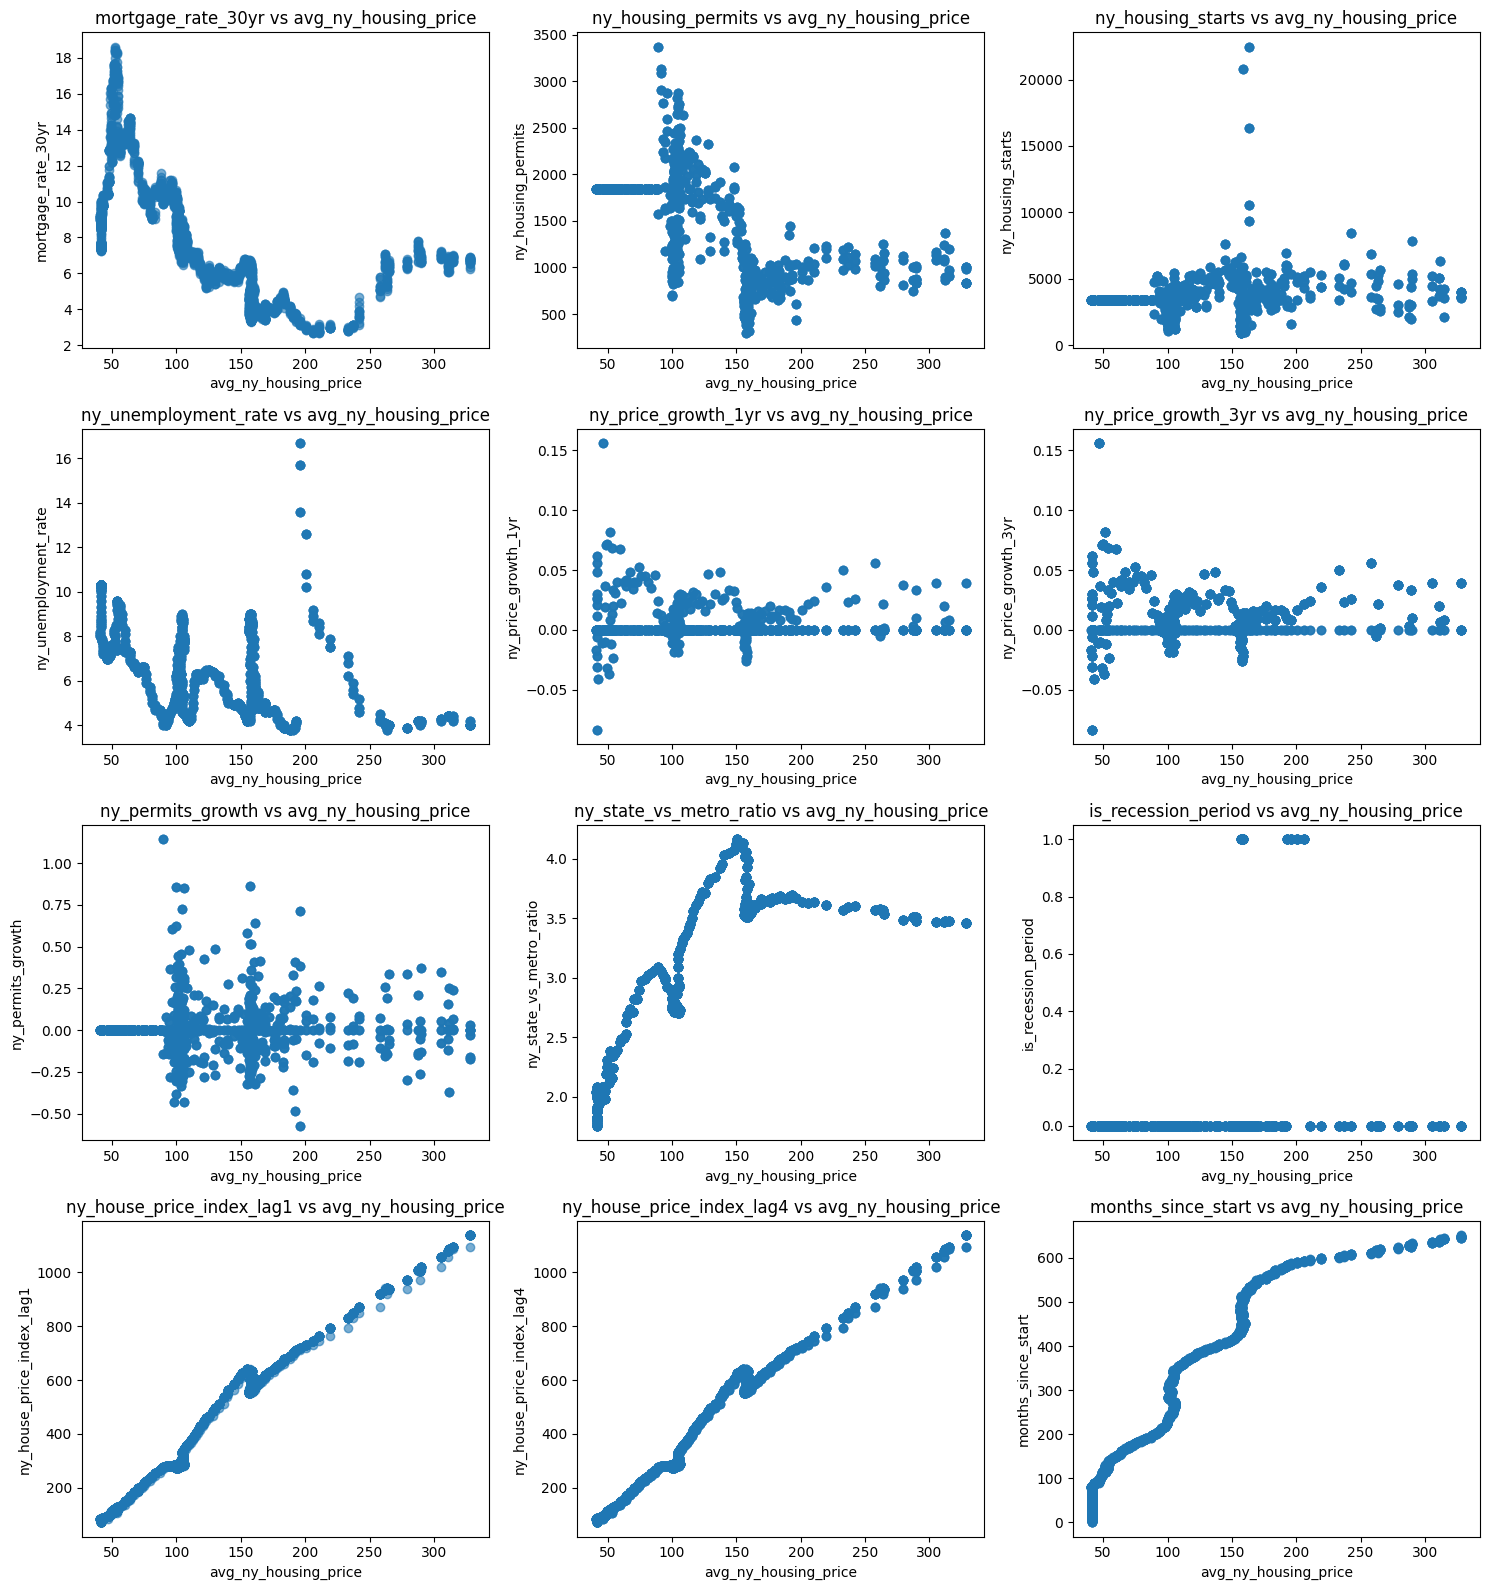

Created histograms for 12 features


In [6]:
# Create scatter plot of each feature relative to target variable

import matplotlib.pyplot as plt
import numpy as np

# Get all features except target
features = [col for col in df.columns if col != 'avg_ny_housing_price']
target = 'avg_ny_housing_price'

# Calculate number of subplots needed
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

# Create scatter plot for each feature
for i, feature in enumerate(features):
    ax = axes[i]

    # Create scatter plot with target on x-axis, feature on y-axis
    ax.scatter(df[target], df[feature], alpha=0.6)
    ax.set_xlabel(target)
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs {target}')

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Created histograms for {n_features} features")

Something to notice right away is a few features seem to be more noise than anything. is_recession_period seems useless, ny_permits_growth is scattered all over the place. ny_house_price_index_lag4 has the same exact shape as ny_house_price_index_lag1. The same applies to ny_price_growth_1yr and ny_price_growth_3yr. We will remove these useless features.

In [7]:
# Remove redundant and uninformative features

# Features to remove (adding ny_price_growth_1yr due to too many outliers)
features_to_remove = [
    'is_recession_period',
    'ny_price_growth_3yr',
    'ny_house_price_index_lag4',
    'ny_permits_growth',  # Very noisy, little clear pattern with target
    'ny_price_growth_1yr'  # Too many outliers detected in initial IQR analysis
]

print(f"Before removal: {len(df.columns)} features")
print(f"Removing: {features_to_remove}")

# Remove the features
df = df.drop(columns=features_to_remove)

print(f"After removal: {len(df.columns)} features")

# Show final feature list
print(f"\nFinal features:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Before removal: 13 features
Removing: ['is_recession_period', 'ny_price_growth_3yr', 'ny_house_price_index_lag4', 'ny_permits_growth', 'ny_price_growth_1yr']
After removal: 8 features

Final features:
 1. mortgage_rate_30yr
 2. ny_housing_permits
 3. ny_housing_starts
 4. ny_unemployment_rate
 5. ny_state_vs_metro_ratio
 6. ny_house_price_index_lag1
 7. avg_ny_housing_price
 8. months_since_start


Another glaring quirk in the data is the clearly present outliers. Just look at NY Housing Starts, for example. We will address this with IQR, for a thorough removal of any outliers.

In [8]:
# IQR outlier detection and removal

import pandas as pd
import numpy as np

print(f"Dataset before outlier removal: {len(df)} rows")

# Get numeric columns only (exclude target for now)
numeric_features = [col for col in df.columns if col != 'avg_ny_housing_price' and df[col].dtype in ['float64', 'int64']]

outlier_counts = {}
total_outliers = set()

# Apply IQR method to each numeric feature
for col in numeric_features:
    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_indices = outliers.index

    outlier_counts[col] = len(outlier_indices)
    total_outliers.update(outlier_indices)

    print(f"{col}: {len(outlier_indices)} outliers ({len(outlier_indices)/len(df)*100:.1f}%)")

# Show summary
print(f"\nOutlier summary:")
print(f"Total unique rows with outliers: {len(total_outliers)}")
print(f"Percentage of data: {len(total_outliers)/len(df)*100:.1f}%")

# Remove outlier rows
df_clean = df.drop(index=total_outliers)

print(f"\nAfter outlier removal:")
print(f"Rows removed: {len(df) - len(df_clean)}")
print(f"Rows remaining: {len(df_clean)}")
print(f"Data retention: {len(df_clean)/len(df)*100:.1f}%")


# Update df
df = df_clean
print(f"\nFinal dataset: {len(df)} rows, {len(df.columns)} features")

Dataset before outlier removal: 3351 rows
mortgage_rate_30yr: 99 outliers (3.0%)
ny_housing_permits: 5 outliers (0.1%)
ny_housing_starts: 265 outliers (7.9%)
ny_unemployment_rate: 16 outliers (0.5%)
ny_state_vs_metro_ratio: 0 outliers (0.0%)
ny_house_price_index_lag1: 0 outliers (0.0%)
months_since_start: 0 outliers (0.0%)

Outlier summary:
Total unique rows with outliers: 385
Percentage of data: 11.5%

After outlier removal:
Rows removed: 385
Rows remaining: 2966
Data retention: 88.5%

Final dataset: 2966 rows, 8 features


In [9]:
# VIF (Variance Inflation Factor) analysis for multicollinearity detection

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Get features for VIF analysis (exclude target)
feature_cols = [col for col in df.columns if col != 'avg_ny_housing_price']
X = df[feature_cols]

print("VIF Analysis for Multicollinearity Detection")
print("=" * 50)
print("Rule of thumb:")
print("  VIF < 5: No multicollinearity concern")
print("  5 <= VIF < 10: Moderate multicollinearity")
print("  VIF >= 10: High multicollinearity (consider removal)")
print()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort by VIF value (highest first)
vif_data = vif_data.sort_values('VIF', ascending=False)

print("VIF Results:")
print("-" * 30)
for idx, row in vif_data.iterrows():
    vif_val = row['VIF']
    status = "HIGH" if vif_val >= 10 else "MODERATE" if vif_val >= 5 else "OK"
    print(f"{row['Feature']:30s}: {vif_val:6.2f} ({status})")

# Identify problematic features
high_vif = vif_data[vif_data['VIF'] >= 10]['Feature'].tolist()
moderate_vif = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)]['Feature'].tolist()

print(f"\nSummary:")
print(f"Features with HIGH multicollinearity (VIF >= 10): {len(high_vif)}")
for feature in high_vif:
    print(f"  - {feature}")

print(f"Features with MODERATE multicollinearity (5 <= VIF < 10): {len(moderate_vif)}")
for feature in moderate_vif:
    print(f"  - {feature}")

if high_vif:
    print(f"\nRecommendation: Consider removing features with VIF >= 10")
else:
    print(f"\nAll features have acceptable VIF values for modeling")

VIF Analysis for Multicollinearity Detection
Rule of thumb:
  VIF < 5: No multicollinearity concern
  5 <= VIF < 10: Moderate multicollinearity
  VIF >= 10: High multicollinearity (consider removal)

VIF Results:
------------------------------
months_since_start            :  81.15 (HIGH)
ny_state_vs_metro_ratio       :  74.92 (HIGH)
ny_house_price_index_lag1     :  43.50 (HIGH)
ny_housing_starts             :  23.20 (HIGH)
ny_housing_permits            :  23.00 (HIGH)
mortgage_rate_30yr            :  16.30 (HIGH)
ny_unemployment_rate          :   9.33 (MODERATE)

Summary:
Features with HIGH multicollinearity (VIF >= 10): 6
  - months_since_start
  - ny_state_vs_metro_ratio
  - ny_house_price_index_lag1
  - ny_housing_starts
  - ny_housing_permits
  - mortgage_rate_30yr
Features with MODERATE multicollinearity (5 <= VIF < 10): 1
  - ny_unemployment_rate

Recommendation: Consider removing features with VIF >= 10


High multicolinearity. Let's fix this by combining highly correlated features. Let's engineer 3 new features.
Housing Activity will be the combination of NY Housing Permits and NY Housing Starts.
Economic Pressure will be the combination of NY Unemployment Rate and Mortgage Rate.

In [10]:
# Strategic feature combination to reduce multicollinearity

import pandas as pd
import numpy as np

print("Combining highly correlated features to reduce multicollinearity...")

# 1. Combine housing activity (permits + starts are highly correlated)
df['housing_activity'] = (df['ny_housing_permits'] + df['ny_housing_starts']) / 2
print("Created: housing_activity (average of permits and starts)")

# 2. Economic pressure index (combines unemployment and mortgage rates)
# Higher values = more economic pressure
df['economic_pressure'] = df['ny_unemployment_rate'] * df['mortgage_rate_30yr']
print("Created: economic_pressure (unemployment × mortgage rate)")

# Remove original highly correlated features (keep lag and ratio separate)
features_to_remove = [
    'ny_housing_permits',
    'ny_housing_starts',
    'ny_unemployment_rate',
    'mortgage_rate_30yr'
]

print(f"\nRemoving original features: {features_to_remove}")
df = df.drop(columns=features_to_remove)

print(f"\nFinal feature set ({len([col for col in df.columns if col != 'avg_ny_housing_price'])} features):")
features = [col for col in df.columns if col != 'avg_ny_housing_price']
for i, col in enumerate(features, 1):
    print(f"{i:2d}. {col}")

Combining highly correlated features to reduce multicollinearity...
Created: housing_activity (average of permits and starts)
Created: economic_pressure (unemployment × mortgage rate)

Removing original features: ['ny_housing_permits', 'ny_housing_starts', 'ny_unemployment_rate', 'mortgage_rate_30yr']

Final feature set (5 features):
 1. ny_state_vs_metro_ratio
 2. ny_house_price_index_lag1
 3. months_since_start
 4. housing_activity
 5. economic_pressure


Let's check the new VIF scores and see if we observe any reduction.

In [11]:
# Check VIF scores after feature engineering

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Get features for VIF analysis (exclude target)
feature_cols = [col for col in df.columns if col != 'avg_ny_housing_price']
X = df[feature_cols]


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort by VIF value (highest first)
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Updated VIF Results:")
print("-" * 30)
for idx, row in vif_data.iterrows():
    vif_val = row['VIF']
    status = "HIGH" if vif_val >= 10 else "MODERATE" if vif_val >= 5 else "OK"
    print(f"{row['Feature']:30s}: {vif_val:6.2f} ({status})")

# Identify remaining problematic features
high_vif = vif_data[vif_data['VIF'] >= 10]['Feature'].tolist()
moderate_vif = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)]['Feature'].tolist()
good_vif = vif_data[vif_data['VIF'] < 5]['Feature'].tolist()

print(f"\nSummary:")
print(f"Features with HIGH multicollinearity (VIF >= 10): {len(high_vif)}")
for feature in high_vif:
    print(f"  - {feature}")

print(f"Features with MODERATE multicollinearity (5 <= VIF < 10): {len(moderate_vif)}")
for feature in moderate_vif:
    print(f"  - {feature}")

print(f"Features with acceptable VIF (< 5): {len(good_vif)}")
for feature in good_vif:
    print(f"  - {feature}")

if len(high_vif) == 0:
    print(f"\nExcellent! No features have high multicollinearity.")
    if len(moderate_vif) == 0:
        print("All features have low VIF scores - dataset is ready for modeling.")
    else:
        print("Some moderate multicollinearity remains but should be acceptable for most models.")

Updated VIF Results:
------------------------------
months_since_start            :  74.42 (HIGH)
ny_state_vs_metro_ratio       :  59.56 (HIGH)
ny_house_price_index_lag1     :  35.86 (HIGH)
housing_activity              :  16.20 (HIGH)
economic_pressure             :   7.33 (MODERATE)

Summary:
Features with HIGH multicollinearity (VIF >= 10): 4
  - months_since_start
  - ny_state_vs_metro_ratio
  - ny_house_price_index_lag1
  - housing_activity
Features with MODERATE multicollinearity (5 <= VIF < 10): 1
  - economic_pressure
Features with acceptable VIF (< 5): 0


VIF score lowered a bit. We want to retain at least 5 features, so we will accept this multicolinearity.

Let's scale the features using StandardScaler, the option less vulnerable to outliers. For the sake of visualizing the results, let's generate a box plot before and after.

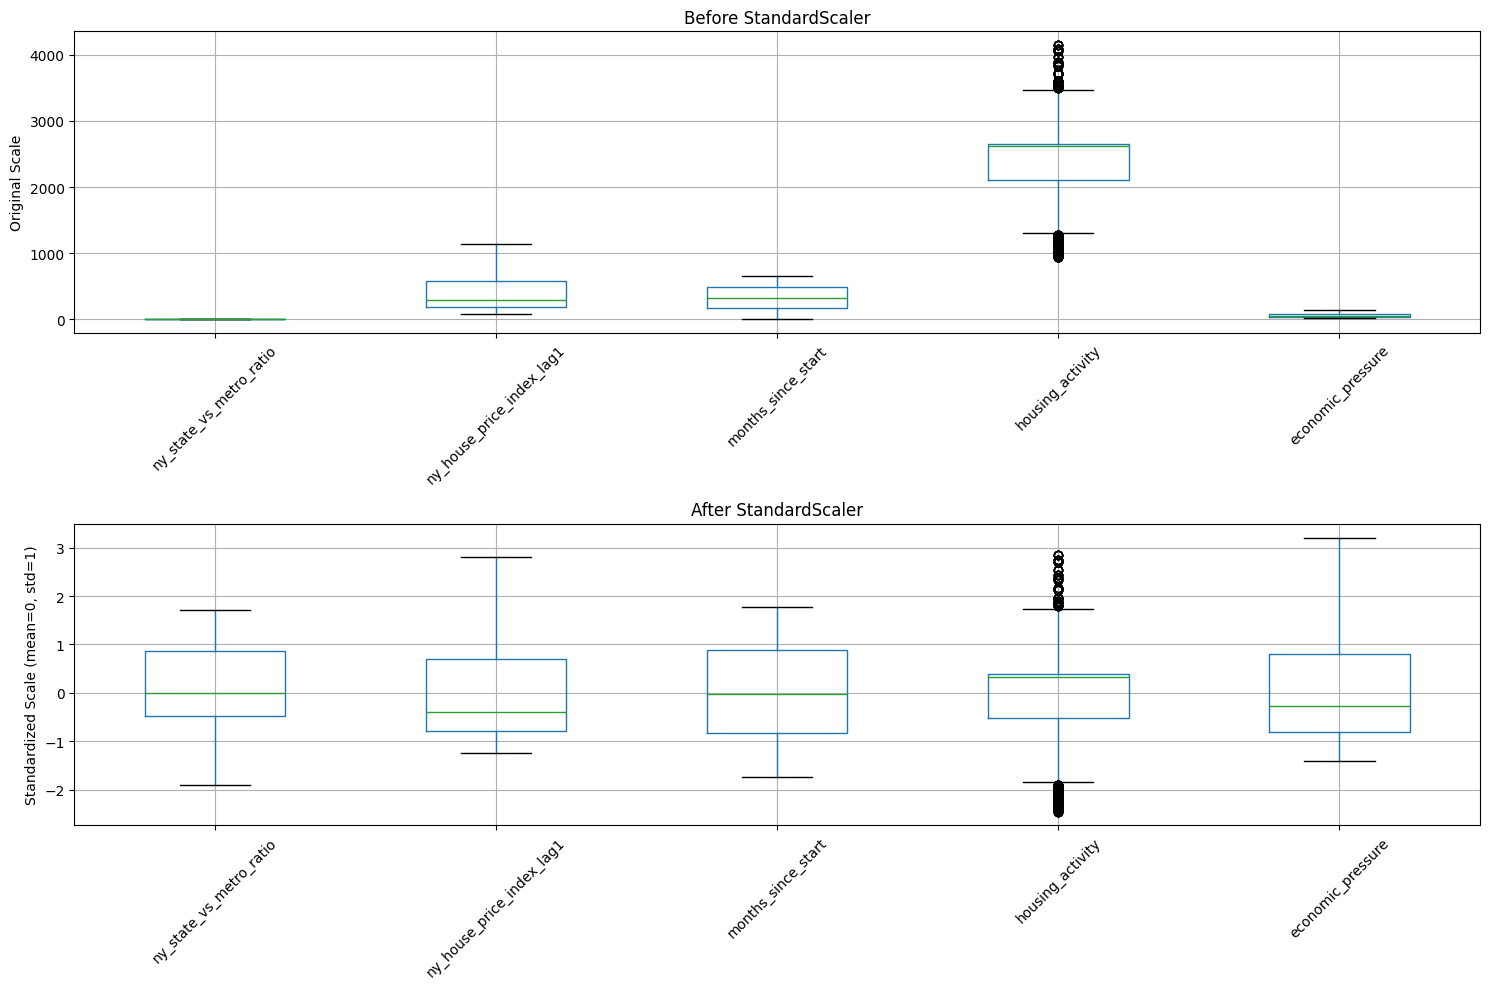

Scaling Summary:
Before scaling:
metric  ny_state_vs_metro_ratio  ny_house_price_index_lag1  \
mean                       3.02                     396.71   
std                        0.66                     263.07   

metric  months_since_start  housing_activity  economic_pressure  
mean                321.33           2423.02              51.75  
std                 185.38            605.82              27.26  

After scaling:
metric  ny_state_vs_metro_ratio  ny_house_price_index_lag1  \
mean                       -0.0                       -0.0   
std                         1.0                        1.0   

metric  months_since_start  housing_activity  economic_pressure  
mean                  -0.0               0.0               -0.0  
std                    1.0               1.0                1.0  

Features have been standardized. Dataset ready for modeling!
Final dataset: 2966 rows, 5 features + 1 target


In [12]:
# Apply StandardScaler and show before/after box plots

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Get features (exclude target)
feature_cols = [col for col in df.columns if col != 'avg_ny_housing_price']

# Before scaling - create box plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Before scaling
df[feature_cols].boxplot(ax=ax1, rot=45)
ax1.set_title('Before StandardScaler')
ax1.set_ylabel('Original Scale')

# Apply StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# After scaling
df_scaled[feature_cols].boxplot(ax=ax2, rot=45)
ax2.set_title('After StandardScaler')
ax2.set_ylabel('Standardized Scale (mean=0, std=1)')

plt.tight_layout()
plt.show()

# Show scaling statistics
print("Scaling Summary:")
print("=" * 40)
print("Before scaling:")
print(df[feature_cols].describe().loc[['mean', 'std']].round(2))

print("\nAfter scaling:")
print(df_scaled[feature_cols].describe().loc[['mean', 'std']].round(2))

# Update dataframe
df = df_scaled

print(f"\nFeatures have been standardized. Dataset ready for modeling!")
print(f"Final dataset: {len(df)} rows, {len(feature_cols)} features + 1 target")

Let's take one final look at the scatterplot, to see what we are working with

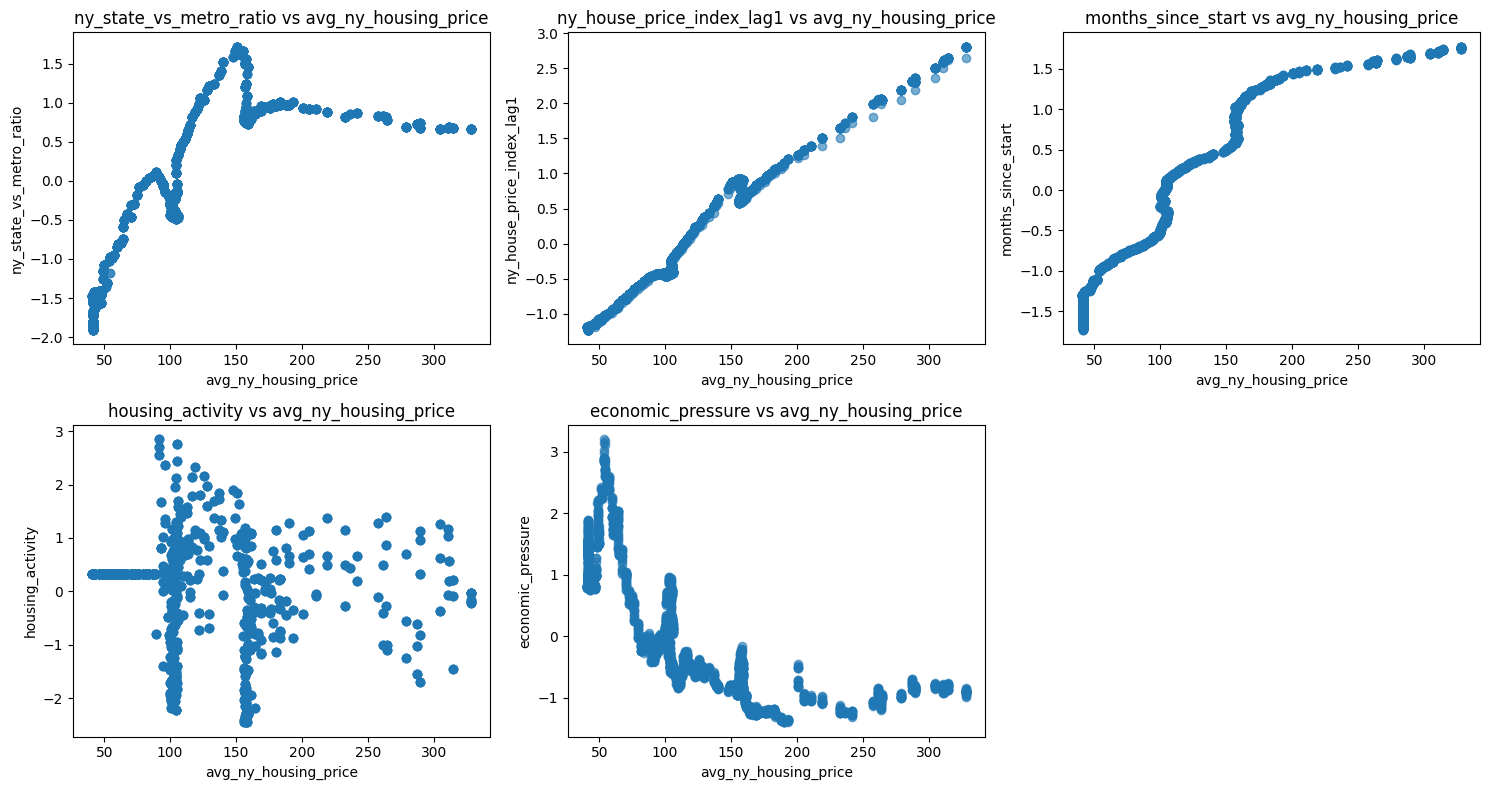

Created histograms for 5 features


In [13]:
# Create scatter plot of each feature relative to target variable

import matplotlib.pyplot as plt
import numpy as np

# Get all features except target
features = [col for col in df.columns if col != 'avg_ny_housing_price']
target = 'avg_ny_housing_price'

# Calculate number of subplots needed
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

# Create scatter plot for each feature
for i, feature in enumerate(features):
    ax = axes[i]

    # Create scatter plot with target on x-axis, feature on y-axis
    ax.scatter(df[target], df[feature], alpha=0.6)
    ax.set_xlabel(target)
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs {target}')

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Created histograms for {n_features} features")

The single most difficult obstacle we faced throughout training this model was actually in finding a dataset accessible via API for free that would meet all assignment requirements. We learned a lot about the process of pulling from API and using data that is extracted from API.

___________________________________________

# **ADRE Stock Dataset**

Our second database is the ARDE ETF, available at Kaggle’s Huge Stock Market Dataset.
It is the value of BLDRS Emerging Markets 50 ADR Index Fund.
It contains the opening value, closing value, high, low, volume, and return.
We will try to predict the closing value, based on the other features.

Let's begin by checking for any missing values, and then we will begin our visualizations.

In [14]:
# Simple Missing Values Check for ADRE Stock Data
import pandas as pd
import numpy as np

def check_missing_values(adre_stock_dataset):
    """Simple missing values check"""
    print("🔍 MISSING VALUES CHECK")
    print("-" * 30)

    # Count missing values
    missing = adre_stock_dataset.isnull().sum()
    missing_pct = (missing / len(adre_stock_dataset)) * 100

    # Show only columns with missing values
    has_missing = missing[missing > 0]

    if len(has_missing) == 0:
        print("✅ No missing values found!")
    else:
        print(f"Found missing values in {len(has_missing)} columns:")
        for col in has_missing.index:
            print(f"  {col}: {missing[col]} ({missing_pct[col]:.1f}%)")

    print(f"\nTotal rows: {len(adre_stock_dataset)}")
    return missing

def quick_data_overview(adre_stock_dataset):
    """Quick overview of the dataset"""
    print("\n📊 DATASET OVERVIEW")
    print("-" * 20)
    print(f"Shape: {adre_stock_dataset.shape[0]} rows × {adre_stock_dataset.shape[1]} columns")
    print(f"Date range: {adre_stock_dataset['Date'].min()} to {adre_stock_dataset['Date'].max()}")

    # Show first few rows
    print("\n📋 FIRST 5 ROWS:")
    print(adre_stock_dataset.head())

    # Basic stats for key columns
    if 'Close' in adre_stock_dataset.columns:
        print(f"\n💰 ADRE Close Price Stats:")
        print(f"  Min: ${adre_stock_dataset['Close'].min():.2f}")
        print(f"  Max: ${adre_stock_dataset['Close'].max():.2f}")
        print(f"  Mean: ${adre_stock_dataset['Close'].mean():.2f}")

# Run the analysis
missing_values = check_missing_values(adre_stock_dataset)
quick_data_overview(adre_stock_dataset)

🔍 MISSING VALUES CHECK
------------------------------
✅ No missing values found!

Total rows: 3201

📊 DATASET OVERVIEW
--------------------
Shape: 3201 rows × 25 columns
Date range: 2005-02-25 00:00:00 to 2017-11-10 00:00:00

📋 FIRST 5 ROWS:
        Date    Open    High     Low   Close  Volume  OpenInt  adre_return_1d  \
0 2005-02-25  19.065  19.416  19.065  19.416   72019        0       -0.001854   
1 2005-02-28  20.172  20.172  19.312  19.380  101346        0       -0.001854   
2 2005-03-01  19.798  19.798  19.209  19.268   53671        0       -0.005779   
3 2005-03-02  19.109  19.195  19.042  19.160   23894        0       -0.005605   
4 2005-03-03  19.744  19.744  19.127  19.187   28870        0        0.001409   

   adre_return_5d  adre_return_20d  ...  adre_daily_range  adre_volume_ma  \
0       -0.002781        -0.080604  ...          0.018078        80411.75   
1       -0.002781        -0.080604  ...          0.044376        80411.75   
2       -0.002781        -0.080604  ... 

Let's take a look at the list of features, so we can see if anything needs an immediate removal or modification.

In [15]:
# Feature Analysis for ADRE Stock Dataset
import pandas as pd

def analyze_features(adre_stock_dataset):
    """Analyze and categorize features in the dataset"""
    print("📊 FEATURE ANALYSIS")
    print("=" * 40)

    all_columns = list(adre_stock_dataset.columns)
    print(f"Total features: {len(all_columns)}")

    # Categorize features
    original_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    price_features = [col for col in all_columns if 'return' in col or 'ma_' in col or 'price_trend' in col]
    volume_features = [col for col in all_columns if 'volume' in col]
    time_features = [col for col in all_columns if col in ['year', 'month', 'day_of_week', 'quarter']]
    lagged_features = [col for col in all_columns if 'lag' in col]
    other_features = [col for col in all_columns if col not in original_features + price_features + volume_features + time_features + lagged_features]

    print(f"\n🏷️ FEATURE CATEGORIES:")
    print(f"📈 Original Stock Data ({len(original_features)}):")
    for feature in original_features:
        if feature in all_columns:
            print(f"  • {feature}")

    print(f"\n💹 Price-based Features ({len(price_features)}):")
    for feature in price_features:
        print(f"  • {feature}")

    print(f"\n📊 Volume Features ({len(volume_features)}):")
    for feature in volume_features:
        print(f"  • {feature}")

    print(f"\n📅 Time Features ({len(time_features)}):")
    for feature in time_features:
        print(f"  • {feature}")

    print(f"\n⏰ Lagged Features ({len(lagged_features)}):")
    for feature in lagged_features:
        print(f"  • {feature}")

    if other_features:
        print(f"\n🔧 Other Features ({len(other_features)}):")
        for feature in other_features:
            print(f"  • {feature}")

    return {
        'original': original_features,
        'price': price_features,
        'volume': volume_features,
        'time': time_features,
        'lagged': lagged_features,
        'other': other_features,
        'all': all_columns
    }

# Run the feature analysis
feature_categories = analyze_features(adre_stock_dataset)

📊 FEATURE ANALYSIS
Total features: 25

🏷️ FEATURE CATEGORIES:
📈 Original Stock Data (7):
  • Date
  • Open
  • High
  • Low
  • Close
  • Volume
  • OpenInt

💹 Price-based Features (7):
  • adre_return_1d
  • adre_return_5d
  • adre_return_20d
  • adre_ma_5d
  • adre_ma_20d
  • adre_ma_50d
  • adre_price_trend

📊 Volume Features (2):
  • adre_volume_ma
  • adre_volume_ratio

📅 Time Features (4):
  • year
  • month
  • day_of_week
  • quarter

⏰ Lagged Features (3):
  • adre_close_lag1
  • adre_close_lag5
  • adre_close_lag10

🔧 Other Features (2):
  • adre_above_ma20
  • adre_daily_range


The different time ranges for price-based features, and the different lag values for lagged features are unlikely to give us much additional information. They're likely very high multicolinearity. Let's preemptively remove them. Additionally, let's do what we did last time, and replace Date with Months From Start, so we have a linear value.

In [16]:
# Clean and Transform ADRE Dataset Features
import pandas as pd
import numpy as np

def clean_adre_features(adre_stock_dataset):
    """Remove specified features and add Months Since Start"""
    print("🔧 CLEANING AND TRANSFORMING FEATURES")
    print("=" * 40)

    # Make a copy to avoid modifying original
    cleaned_data = adre_stock_dataset.copy()

    # Features to remove
    features_to_remove = [
        'Date',
        'adre_return_5d',
        'adre_return_20d',
        'adre_ma_20d',
        'adre_ma_50d',
        'adre_close_lag5',
        'adre_close_lag10'
    ]

    print(f"🗑️ REMOVING FEATURES:")
    removed_count = 0
    for feature in features_to_remove:
        if feature in cleaned_data.columns:
            print(f"  ✅ Removed: {feature}")
            if feature == 'Date':
                # Calculate months since start before removing Date
                start_date = pd.to_datetime(cleaned_data['Date']).min()
                cleaned_data['months_since_start'] = ((pd.to_datetime(cleaned_data['Date']) - start_date).dt.days / 30.44).round().astype(int)
                print(f"  ➕ Added: months_since_start (based on Date)")
            cleaned_data = cleaned_data.drop(feature, axis=1)
            removed_count += 1
        else:
            print(f"  ⚠️ Not found: {feature}")

    print(f"\n📊 DATASET SUMMARY:")
    print(f"  Original features: {adre_stock_dataset.shape[1]}")
    print(f"  Features removed: {removed_count}")
    print(f"  Features added: 1 (months_since_start)")
    print(f"  Final features: {cleaned_data.shape[1]}")
    print(f"  Total rows: {cleaned_data.shape[0]}")

    print(f"\n📋 REMAINING FEATURES:")
    for i, col in enumerate(cleaned_data.columns, 1):
        print(f"  {i:2d}. {col}")

    return cleaned_data

# Clean the dataset
adre_cleaned = clean_adre_features(adre_stock_dataset)

# Quick check of the new months_since_start feature
print(f"\n📅 MONTHS SINCE START FEATURE:")
print(f"  Min: {adre_cleaned['months_since_start'].min()} months")
print(f"  Max: {adre_cleaned['months_since_start'].max()} months")
print(f"  Mean: {adre_cleaned['months_since_start'].mean():.1f} months")

🔧 CLEANING AND TRANSFORMING FEATURES
🗑️ REMOVING FEATURES:
  ✅ Removed: Date
  ➕ Added: months_since_start (based on Date)
  ✅ Removed: adre_return_5d
  ✅ Removed: adre_return_20d
  ✅ Removed: adre_ma_20d
  ✅ Removed: adre_ma_50d
  ✅ Removed: adre_close_lag5
  ✅ Removed: adre_close_lag10

📊 DATASET SUMMARY:
  Original features: 25
  Features removed: 7
  Features added: 1 (months_since_start)
  Final features: 19
  Total rows: 3201

📋 REMAINING FEATURES:
   1. Open
   2. High
   3. Low
   4. Close
   5. Volume
   6. OpenInt
   7. adre_return_1d
   8. adre_ma_5d
   9. adre_above_ma20
  10. adre_price_trend
  11. adre_daily_range
  12. adre_volume_ma
  13. adre_volume_ratio
  14. year
  15. month
  16. day_of_week
  17. quarter
  18. adre_close_lag1
  19. months_since_start

📅 MONTHS SINCE START FEATURE:
  Min: 0 months
  Max: 152 months
  Mean: 76.3 months


Let's visualize our data for any quirks, to see what actions need to be taken, by generating more scatter plots with the target variable, closing value, as the x axis, and each respective feature as the y axis.

📊 VISUALIZING FEATURES VS TARGET (CLOSE PRICE)
Creating 18 scatter plots...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


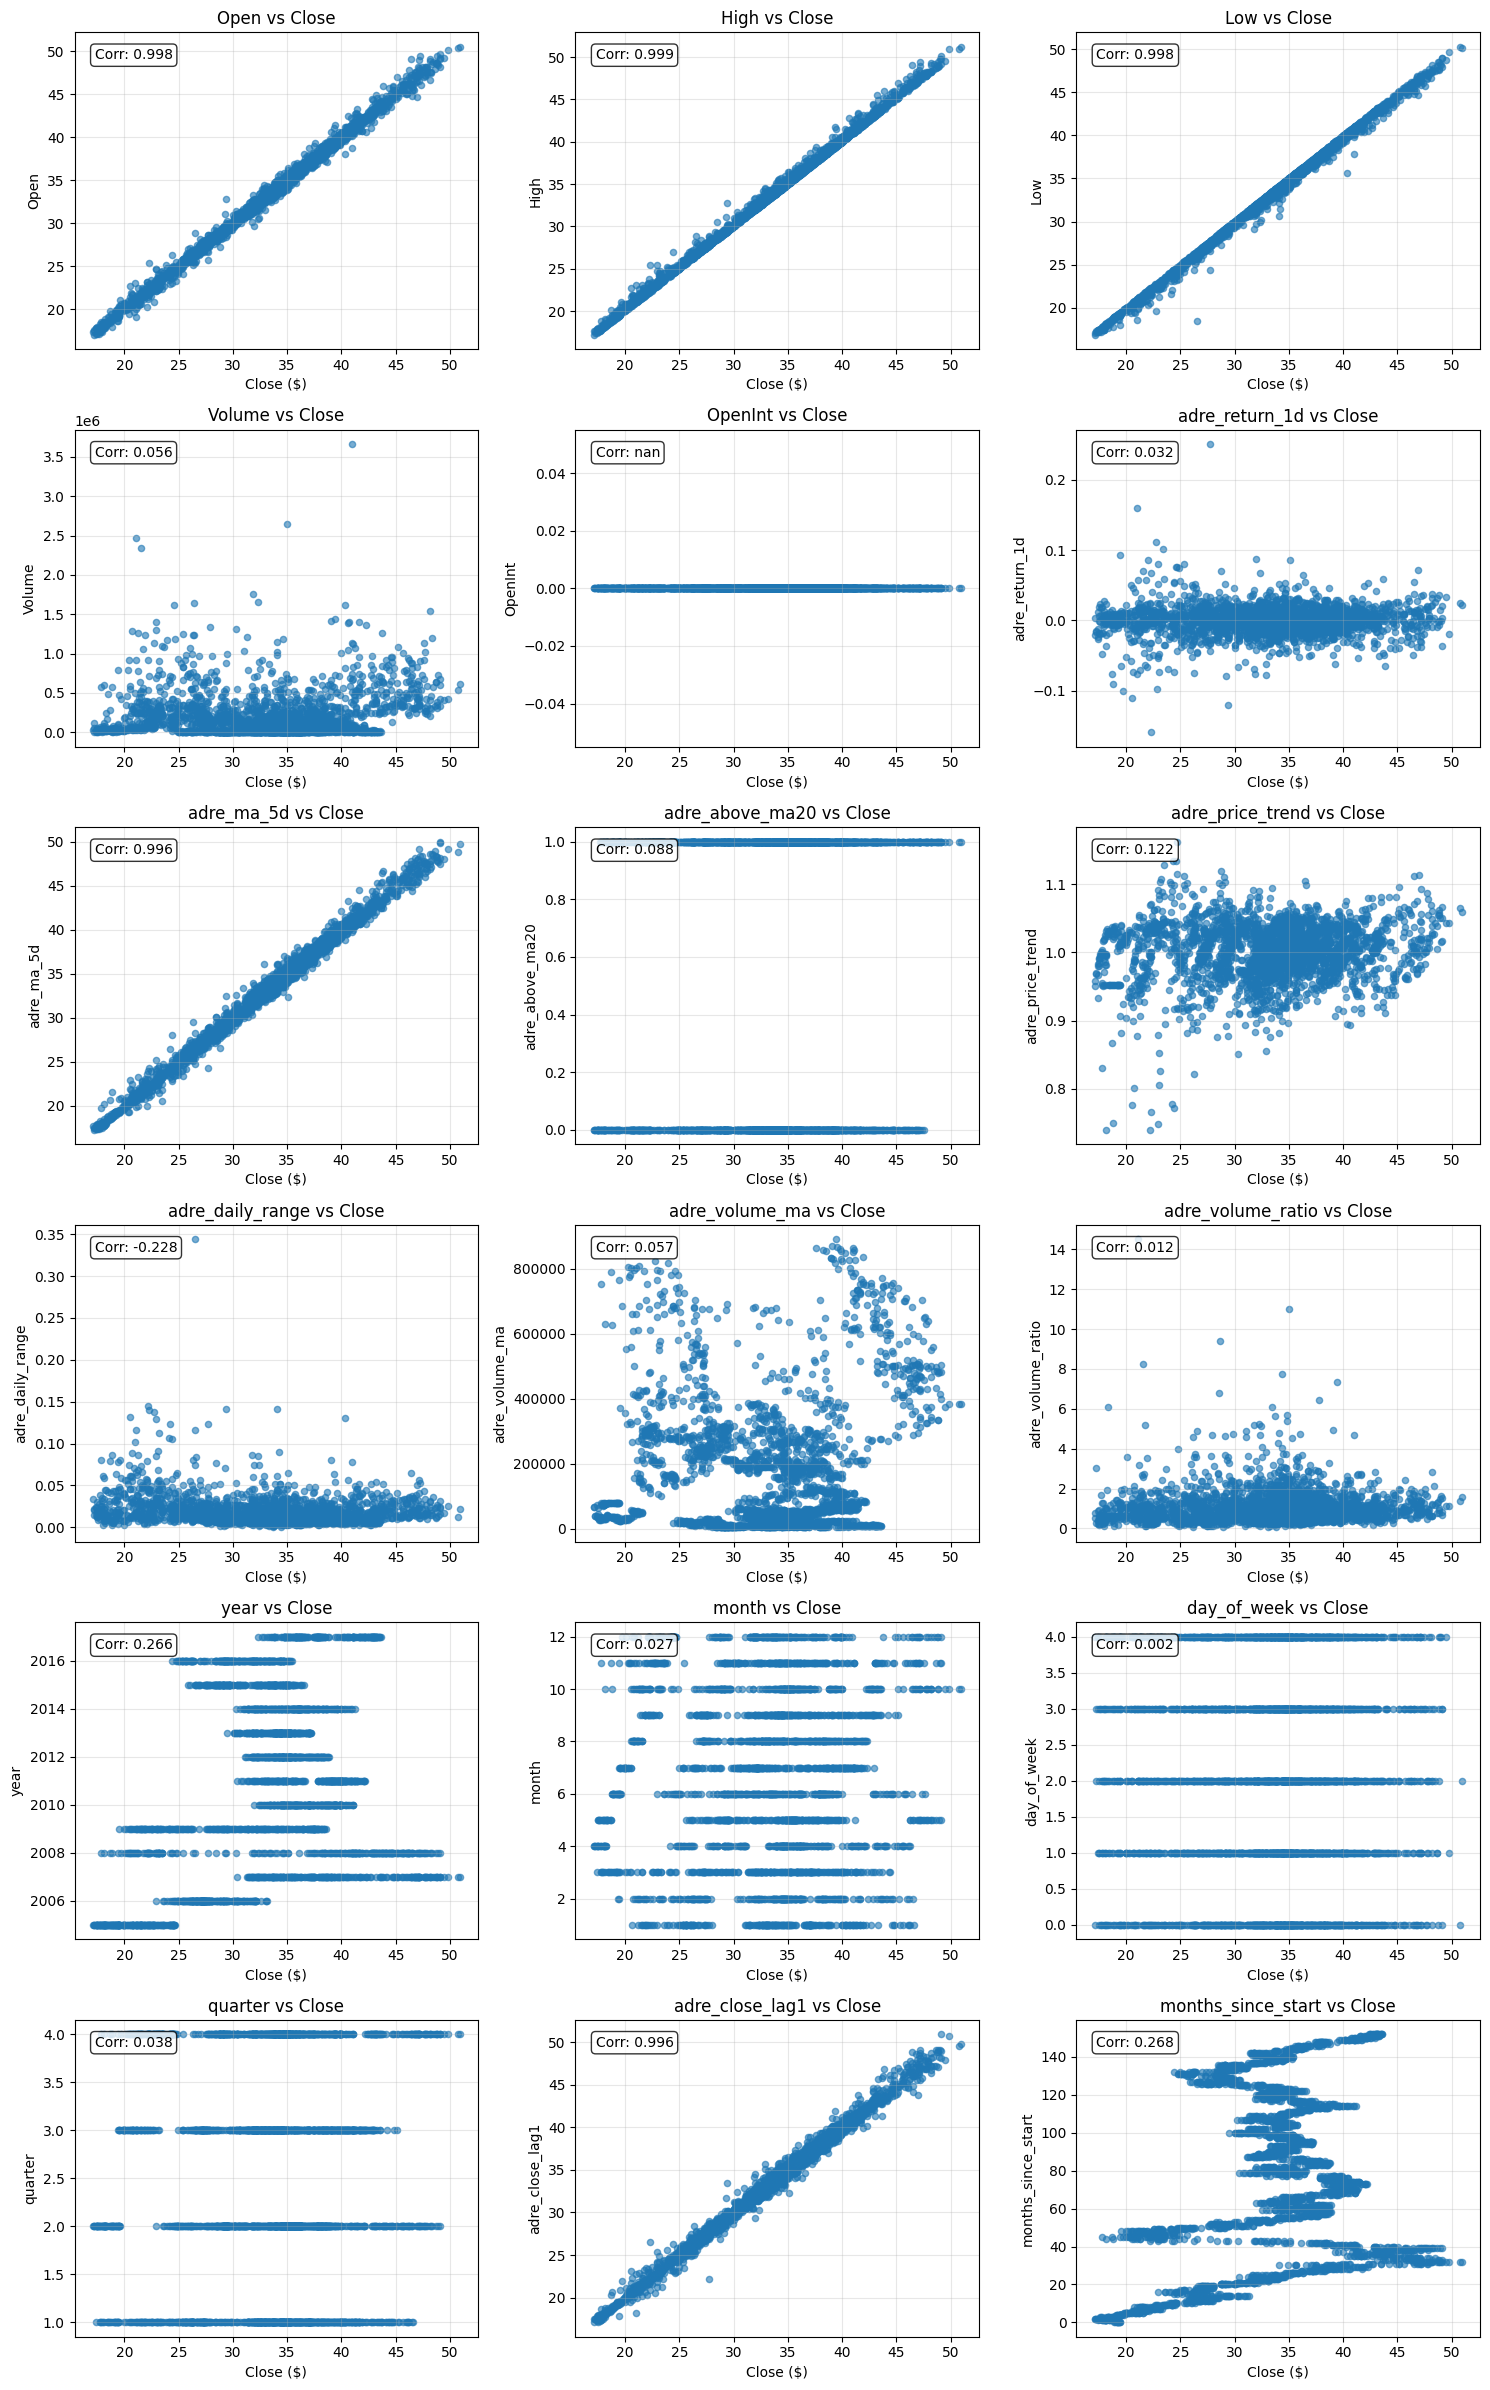


📈 CORRELATION SUMMARY WITH Close:
----------------------------------------
Top correlated features:
  📈 High                :   0.999
  📈 Low                 :   0.998
  📈 Open                :   0.998
  📉 OpenInt             :     nan
  📈 adre_close_lag1     :   0.996
  📈 adre_ma_5d          :   0.996
  📈 months_since_start  :   0.268
  📈 year                :   0.266
  📉 adre_daily_range    :  -0.228
  📈 adre_price_trend    :   0.122


In [17]:
# Visualize ADRE Data Features vs Target Variable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_features_vs_target(adre_cleaned, target_col='Close'):
    """Create scatter plots of each feature vs target variable"""
    print("📊 VISUALIZING FEATURES VS TARGET (CLOSE PRICE)")
    print("=" * 50)

    # Get all features except the target
    features = [col for col in adre_cleaned.columns if col != target_col]

    # Calculate number of subplots needed
    n_features = len(features)
    n_cols = 3  # 3 plots per row
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    print(f"Creating {n_features} scatter plots...")

    for i, feature in enumerate(features):
        ax = axes_flat[i]

        # Create scatter plot
        x = adre_cleaned[target_col]
        y = adre_cleaned[feature]

        # Remove any NaN values for plotting
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]

        ax.scatter(x_clean, y_clean, alpha=0.6, s=20)
        ax.set_xlabel(f'{target_col} ($)')
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} vs {target_col}')
        ax.grid(True, alpha=0.3)

        # Add correlation coefficient
        if len(x_clean) > 1:
            corr = np.corrcoef(x_clean, y_clean)[0, 1]
            ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

    # Hide unused subplots
    for i in range(n_features, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print correlation summary
    print(f"\n📈 CORRELATION SUMMARY WITH {target_col}:")
    print("-" * 40)
    correlations = []
    for feature in features:
        if feature in adre_cleaned.columns:
            corr = adre_cleaned[feature].corr(adre_cleaned[target_col])
            correlations.append((feature, corr))

    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("Top correlated features:")
    for feature, corr in correlations[:10]:
        direction = "📈" if corr > 0 else "📉"
        print(f"  {direction} {feature:<20}: {corr:>7.3f}")

    return correlations

# Create the visualizations
correlations = visualize_features_vs_target(adre_cleaned)

The time features seem to have little to offer. Additionally, OpenInt appears to be all zeroes. Above MA20 is also a binary feature with little to offer. Let's also remove High and Low, since we want to be able to predict the closing value before closing. High and Low are determined after closing.

In [18]:
# Features to Remove Based on Scatter Plot Analysis
features_to_remove = [
    'High',              # Known after closing - can't use for prediction
    'Low',               # Known after closing - can't use for prediction
    'OpenInt',           # All zeros (flat line) - no variation
    'adre_above_ma20',   # Binary feature with only 0s and 1s - limited info
    'year',              # Discrete time bands - use months_since_start instead
    'month',             # Discrete seasonal bands - may not add much value
    'day_of_week',       # Very weak correlation (0.002) - likely noise
    'quarter'            # Discrete seasonal bands - redundant with month
]

def remove_low_value_features(adre_cleaned):
    """Remove features that don't add value for ML"""
    print("🗑️ REMOVING LOW-VALUE FEATURES")
    print("=" * 40)

    cleaned_data = adre_cleaned.copy()

    for feature in features_to_remove:
        if feature in cleaned_data.columns:
            print(f"  ✅ Removed: {feature}")
            cleaned_data = cleaned_data.drop(feature, axis=1)
        else:
            print(f"  ⚠️ Not found: {feature}")

    print(f"\n📊 FINAL DATASET:")
    print(f"  Features removed: {len(features_to_remove)}")
    print(f"  Final features: {cleaned_data.shape[1]}")
    print(f"  Remaining features: {list(cleaned_data.columns)}")

    return cleaned_data

# Remove the low-value features
adre_final = remove_low_value_features(adre_cleaned)

🗑️ REMOVING LOW-VALUE FEATURES
  ✅ Removed: High
  ✅ Removed: Low
  ✅ Removed: OpenInt
  ✅ Removed: adre_above_ma20
  ✅ Removed: year
  ✅ Removed: month
  ✅ Removed: day_of_week
  ✅ Removed: quarter

📊 FINAL DATASET:
  Features removed: 8
  Final features: 11
  Remaining features: ['Open', 'Close', 'Volume', 'adre_return_1d', 'adre_ma_5d', 'adre_price_trend', 'adre_daily_range', 'adre_volume_ma', 'adre_volume_ratio', 'adre_close_lag1', 'months_since_start']


Volume seems to have a skew, so let's apply a logarithmic transformation to it.

In [19]:
# Simple Volume Transformation for ADRE Dataset
import numpy as np

def transform_volume(adre_final):
    """Apply log transformation to Volume only"""
    print("🔧 TRANSFORMING VOLUME")
    print("=" * 25)

    transformed_data = adre_final.copy()

    # Log transform Volume (highly skewed)
    if 'Volume' in transformed_data.columns:
        print("  📊 Log transforming Volume (highly skewed)")
        transformed_data['Volume_log'] = np.log1p(transformed_data['Volume'])
        transformed_data = transformed_data.drop('Volume', axis=1)
        print("  ✅ Volume -> Volume_log")

    print(f"\n📊 FINAL DATASET:")
    print(f"  Features: {transformed_data.shape[1]}")
    print(f"  Rows: {transformed_data.shape[0]}")

    return transformed_data

# Apply volume transformation
adre_transformed = transform_volume(adre_final)

🔧 TRANSFORMING VOLUME
  📊 Log transforming Volume (highly skewed)
  ✅ Volume -> Volume_log

📊 FINAL DATASET:
  Features: 11
  Rows: 3201


Let's deal with outliers now, by running IQR. IQR is less sensitive to outliers. We also lack much in the way of normal distributions, where Z-score would be used.

In [20]:
# IQR Outlier Detection and Removal for ADRE Dataset
import numpy as np
import pandas as pd

def remove_outliers_iqr(adre_transformed, target_col='Close'):
    """Remove outliers using IQR method"""
    print("🔍 IQR OUTLIER DETECTION AND REMOVAL")
    print("=" * 40)

    data = adre_transformed.copy()
    original_rows = len(data)

    # Get numeric columns (excluding target for now)
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)  # Handle target separately if needed

    outlier_summary = []

    for col in numeric_cols:
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        outlier_pct = (outliers / len(data)) * 100

        outlier_summary.append({
            'feature': col,
            'outliers': outliers,
            'percentage': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

        if outliers > 0:
            print(f"  📊 {col:<25}: {outliers:>4} outliers ({outlier_pct:>5.1f}%)")

    # Remove rows with outliers in any feature
    print(f"\n🗑️ REMOVING OUTLIER ROWS:")
    outlier_mask = pd.Series(False, index=data.index)

    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        col_outliers = (data[col] < lower_bound) | (data[col] > upper_bound)
        outlier_mask = outlier_mask | col_outliers

    # Remove outliers
    cleaned_data = data[~outlier_mask].reset_index(drop=True)
    removed_rows = original_rows - len(cleaned_data)

    print(f"  Original rows: {original_rows:,}")
    print(f"  Outlier rows removed: {removed_rows:,}")
    print(f"  Final rows: {len(cleaned_data):,}")
    print(f"  Data retention: {(len(cleaned_data)/original_rows)*100:.1f}%")

    return cleaned_data, outlier_summary

# Apply IQR outlier removal
adre_clean, outlier_info = remove_outliers_iqr(adre_transformed)

# Show summary
print(f"\n📋 OUTLIER SUMMARY:")
print("-" * 30)
for info in outlier_info:
    if info['outliers'] > 0:
        print(f"{info['feature']:<25}: {info['outliers']:>4} ({info['percentage']:>5.1f}%)")

🔍 IQR OUTLIER DETECTION AND REMOVAL
  📊 Open                     :   72 outliers (  2.2%)
  📊 adre_return_1d           :  184 outliers (  5.7%)
  📊 adre_ma_5d               :   61 outliers (  1.9%)
  📊 adre_price_trend         :   93 outliers (  2.9%)
  📊 adre_daily_range         :  216 outliers (  6.7%)
  📊 adre_volume_ma           :  182 outliers (  5.7%)
  📊 adre_volume_ratio        :  176 outliers (  5.5%)
  📊 adre_close_lag1          :   77 outliers (  2.4%)

🗑️ REMOVING OUTLIER ROWS:
  Original rows: 3,201
  Outlier rows removed: 638
  Final rows: 2,563
  Data retention: 80.1%

📋 OUTLIER SUMMARY:
------------------------------
Open                     :   72 (  2.2%)
adre_return_1d           :  184 (  5.7%)
adre_ma_5d               :   61 (  1.9%)
adre_price_trend         :   93 (  2.9%)
adre_daily_range         :  216 (  6.7%)
adre_volume_ma           :  182 (  5.7%)
adre_volume_ratio        :  176 (  5.5%)
adre_close_lag1          :   77 (  2.4%)


While our data is looking better, there's still much to do. Specifically, to observe multicolinearity and respond to it.

In [21]:
# VIF (Variance Inflation Factor) Analysis for ADRE Dataset
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(adre_clean, target_col='Close'):
    """Calculate VIF scores to detect multicollinearity"""
    print("📊 VIF MULTICOLLINEARITY ANALYSIS")
    print("=" * 35)

    # Get numeric features (exclude target)
    numeric_features = adre_clean.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_features:
        numeric_features.remove(target_col)

    # Prepare data for VIF calculation
    X = adre_clean[numeric_features].dropna()

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(len(X.columns))]

    # Sort by VIF score
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

    print("VIF Scores (>10 indicates high multicollinearity):")
    print("-" * 45)

    for _, row in vif_data.iterrows():
        feature = row['Feature']
        vif_score = row['VIF']

        if vif_score > 10:
            status = "🔴 HIGH"
        elif vif_score > 5:
            status = "🟡 MODERATE"
        else:
            status = "🟢 LOW"

        print(f"  {feature:<25}: {vif_score:>8.2f} {status}")

    # Identify features with high VIF
    high_vif = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]['Feature'].tolist()

    print(f"\n🔍 MULTICOLLINEARITY SUMMARY:")
    print(f"  High VIF (>10): {len(high_vif)} features")
    if high_vif:
        print(f"    {high_vif}")
    print(f"  Moderate VIF (5-10): {len(moderate_vif)} features")
    if moderate_vif:
        print(f"    {moderate_vif}")

    return vif_data, high_vif, moderate_vif

# Calculate VIF scores
vif_results, high_vif_features, moderate_vif_features = calculate_vif(adre_clean)

📊 VIF MULTICOLLINEARITY ANALYSIS
VIF Scores (>10 indicates high multicollinearity):
---------------------------------------------
  adre_close_lag1          : 36152.25 🔴 HIGH
  Open                     : 25321.53 🔴 HIGH
  adre_ma_5d               : 11471.20 🔴 HIGH
  Volume_log               :   451.28 🔴 HIGH
  adre_price_trend         :   365.00 🔴 HIGH
  months_since_start       :    24.62 🔴 HIGH
  adre_volume_ratio        :     8.91 🟡 MODERATE
  adre_daily_range         :     6.95 🟡 MODERATE
  adre_volume_ma           :     6.93 🟡 MODERATE
  adre_return_1d           :     1.85 🟢 LOW

🔍 MULTICOLLINEARITY SUMMARY:
  High VIF (>10): 6 features
    ['adre_close_lag1', 'Open', 'adre_ma_5d', 'Volume_log', 'adre_price_trend', 'months_since_start']
  Moderate VIF (5-10): 3 features
    ['adre_volume_ratio', 'adre_daily_range', 'adre_volume_ma']


Let's try removing adre_close_lag, and adre_ma_5d as well. We want to keep the Opening value so the model can predict the closing value upon opening.

In [22]:
# Remove High VIF Features
def remove_specific_vif_features(adre_clean):
    """Remove specific high VIF features"""
    print("🗑️ REMOVING SPECIFIC HIGH VIF FEATURES")
    print("=" * 40)

    # Features to remove
    features_to_remove = [
        'adre_close_lag1',    # VIF: 36152.25
        'adre_ma_5d'          # VIF: 11471.20
    ]

    cleaned_data = adre_clean.copy()

    for feature in features_to_remove:
        if feature in cleaned_data.columns:
            print(f"  ✅ Removed: {feature}")
            cleaned_data = cleaned_data.drop(feature, axis=1)
        else:
            print(f"  ⚠️ Not found: {feature}")

    print(f"\n📊 UPDATED DATASET:")
    print(f"  Features removed: {len(features_to_remove)}")
    print(f"  Remaining features: {cleaned_data.shape[1]}")
    print(f"  Remaining rows: {cleaned_data.shape[0]}")
    print(f"  Final features: {list(cleaned_data.columns)}")

    return cleaned_data

# Remove the specified VIF features
adre_vif_cleaned = remove_specific_vif_features(adre_clean)

# Recalculate VIF to see improvement
print("\n🔄 RECALCULATING VIF AFTER REMOVAL...")
vif_results_updated, high_vif_updated, moderate_vif_updated = calculate_vif(adre_vif_cleaned)

🗑️ REMOVING SPECIFIC HIGH VIF FEATURES
  ✅ Removed: adre_close_lag1
  ✅ Removed: adre_ma_5d

📊 UPDATED DATASET:
  Features removed: 2
  Remaining features: 9
  Remaining rows: 2563
  Final features: ['Open', 'Close', 'adre_return_1d', 'adre_price_trend', 'adre_daily_range', 'adre_volume_ma', 'adre_volume_ratio', 'months_since_start', 'Volume_log']

🔄 RECALCULATING VIF AFTER REMOVAL...
📊 VIF MULTICOLLINEARITY ANALYSIS
VIF Scores (>10 indicates high multicollinearity):
---------------------------------------------
  Volume_log               :   421.50 🔴 HIGH
  adre_price_trend         :   336.27 🔴 HIGH
  Open                     :    61.25 🔴 HIGH
  months_since_start       :    23.25 🔴 HIGH
  adre_volume_ratio        :     8.69 🟡 MODERATE
  adre_daily_range         :     6.86 🟡 MODERATE
  adre_volume_ma           :     6.72 🟡 MODERATE
  adre_return_1d           :     1.06 🟢 LOW

🔍 MULTICOLLINEARITY SUMMARY:
  High VIF (>10): 4 features
    ['Volume_log', 'adre_price_trend', 'Open', 'mont

Let's check the scatterplot to see how these features are performing.

📊 SCATTER PLOTS AFTER VIF FEATURE REMOVAL
Creating scatter plots for 8 features...


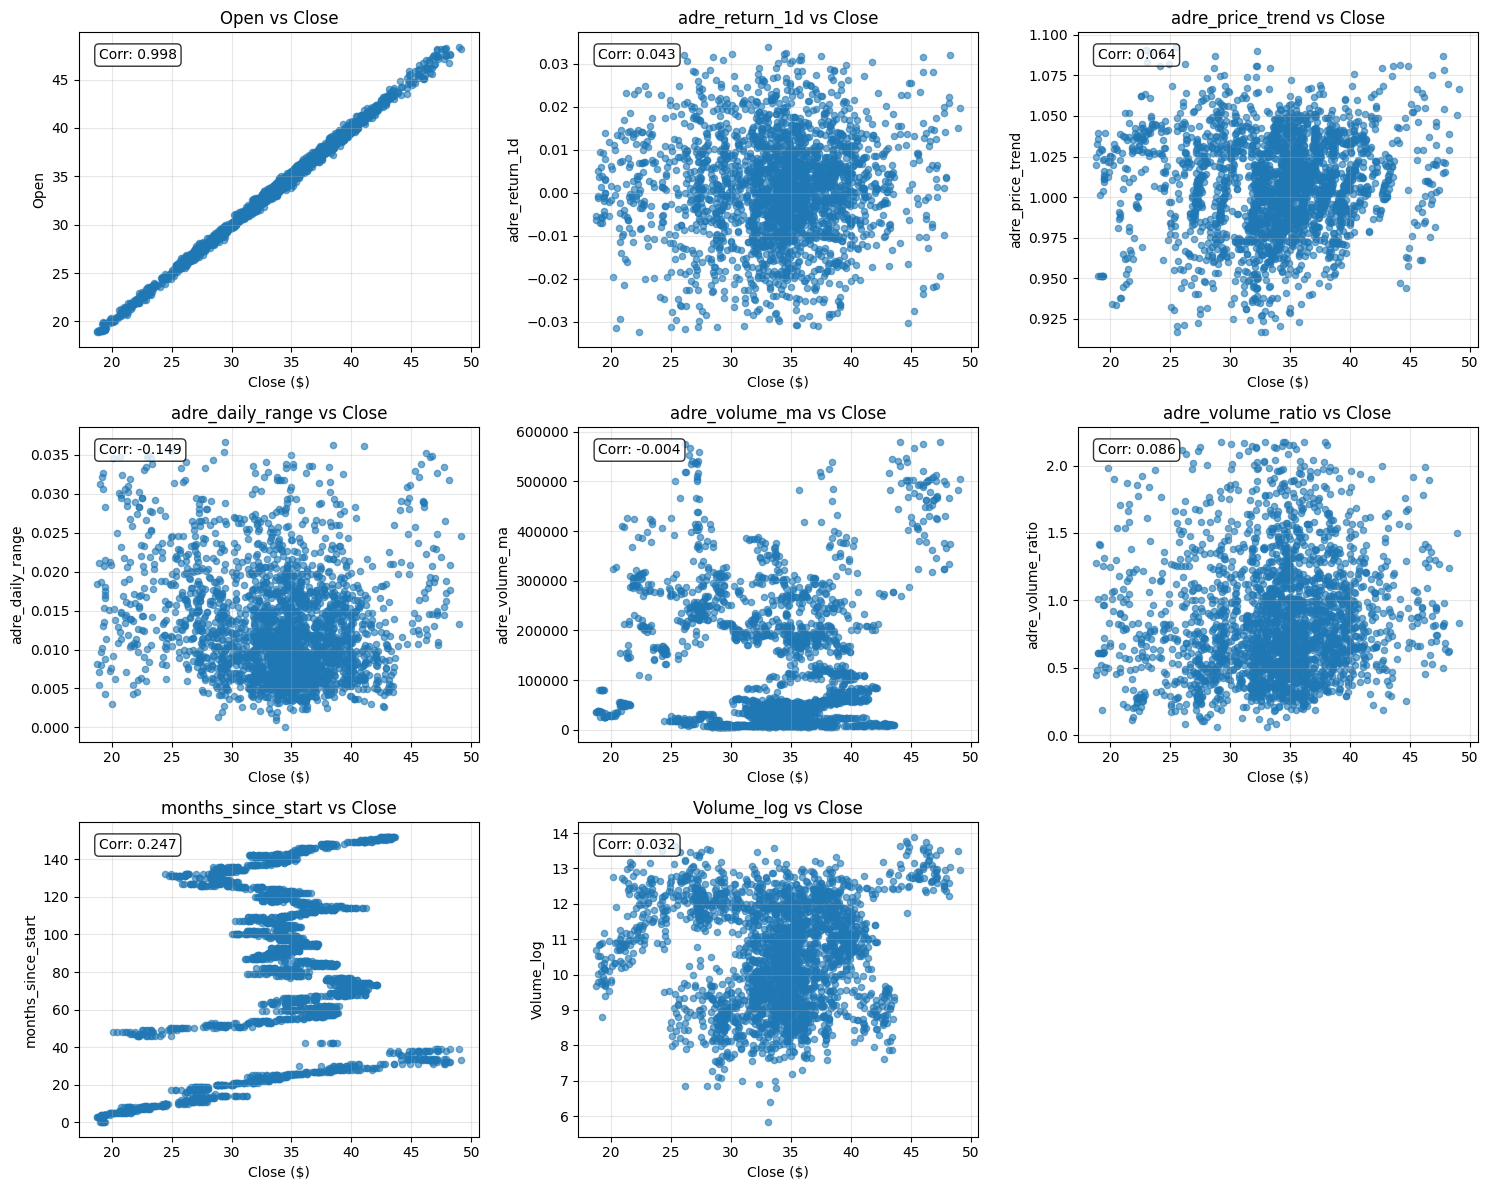


📈 CORRELATION SUMMARY:
-----------------------------------
  📈 Open                     :   0.998
  📈 months_since_start       :   0.247
  📉 adre_daily_range         :  -0.149
  📈 adre_volume_ratio        :   0.086
  📈 adre_price_trend         :   0.064
  📈 adre_return_1d           :   0.043
  📈 Volume_log               :   0.032
  📉 adre_volume_ma           :  -0.004


In [23]:
# View Scatter Plots After VIF Feature Removal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_scatterplots_after_vif(adre_vif_cleaned, target_col='Close'):
    """Create scatter plots of remaining features vs target variable"""
    print("📊 SCATTER PLOTS AFTER VIF FEATURE REMOVAL")
    print("=" * 45)

    # Get all features except the target
    features = [col for col in adre_vif_cleaned.columns if col != target_col]

    # Calculate subplot layout
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()

    print(f"Creating scatter plots for {n_features} features...")

    correlations = []

    for i, feature in enumerate(features):
        ax = axes_flat[i]

        # Get data
        x = adre_vif_cleaned[target_col]
        y = adre_vif_cleaned[feature]

        # Remove NaN values
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]

        # Create scatter plot
        ax.scatter(x_clean, y_clean, alpha=0.6, s=20)
        ax.set_xlabel(f'{target_col} ($)')
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} vs {target_col}')
        ax.grid(True, alpha=0.3)

        # Calculate and display correlation
        if len(x_clean) > 1:
            corr = np.corrcoef(x_clean, y_clean)[0, 1]
            correlations.append((feature, corr))
            ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

    # Hide unused subplots
    for i in range(n_features, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Summary of correlations
    print(f"\n📈 CORRELATION SUMMARY:")
    print("-" * 35)
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    for feature, corr in correlations:
        direction = "📈" if corr > 0 else "📉"
        print(f"  {direction} {feature:<25}: {corr:>7.3f}")

    return correlations

# Generate the scatter plots
correlations_after_vif = plot_scatterplots_after_vif(adre_vif_cleaned)

We will remove any features that do not round to .1 correlation, as these are almost useless.

In [24]:
# Remove Weak Correlation Features
def remove_weak_features(adre_vif_cleaned):
    """Remove features with very weak correlations"""
    print("🗑️ REMOVING WEAK CORRELATION FEATURES")
    print("=" * 40)

    data = adre_vif_cleaned.copy()

    # Remove weak correlation features
    weak_features = ['adre_return_1d', 'Volume_log', 'adre_volume_ma']

    for feature in weak_features:
        if feature in data.columns:
            print(f"  ✅ Removed: {feature} (correlation: weak)")
            data = data.drop(feature, axis=1)
        else:
            print(f"  ⚠️ Not found: {feature}")

    print(f"\n📊 FINAL CLEANED DATASET:")
    print(f"  Features removed: {len(weak_features)}")
    print(f"  Remaining features: {data.shape[1]}")
    print(f"  Final features: {list(data.columns)}")

    return data

# Remove the weak features (using the correct variable name)
adre_final = remove_weak_features(adre_vif_cleaned)

🗑️ REMOVING WEAK CORRELATION FEATURES
  ✅ Removed: adre_return_1d (correlation: weak)
  ✅ Removed: Volume_log (correlation: weak)
  ✅ Removed: adre_volume_ma (correlation: weak)

📊 FINAL CLEANED DATASET:
  Features removed: 3
  Remaining features: 6
  Final features: ['Open', 'Close', 'adre_price_trend', 'adre_daily_range', 'adre_volume_ratio', 'months_since_start']


Same as before, let's run StandardScaler with before and after boxplots.

📏 APPLYING STANDARDSCALER WITH VISUALIZATION
Features to scale: ['Open', 'adre_price_trend', 'adre_daily_range', 'adre_volume_ratio', 'months_since_start']
Target (not scaled): Close

📊 Creating BEFORE scaling box plots...
🔄 Applying StandardScaler...
📊 Creating AFTER scaling box plots...


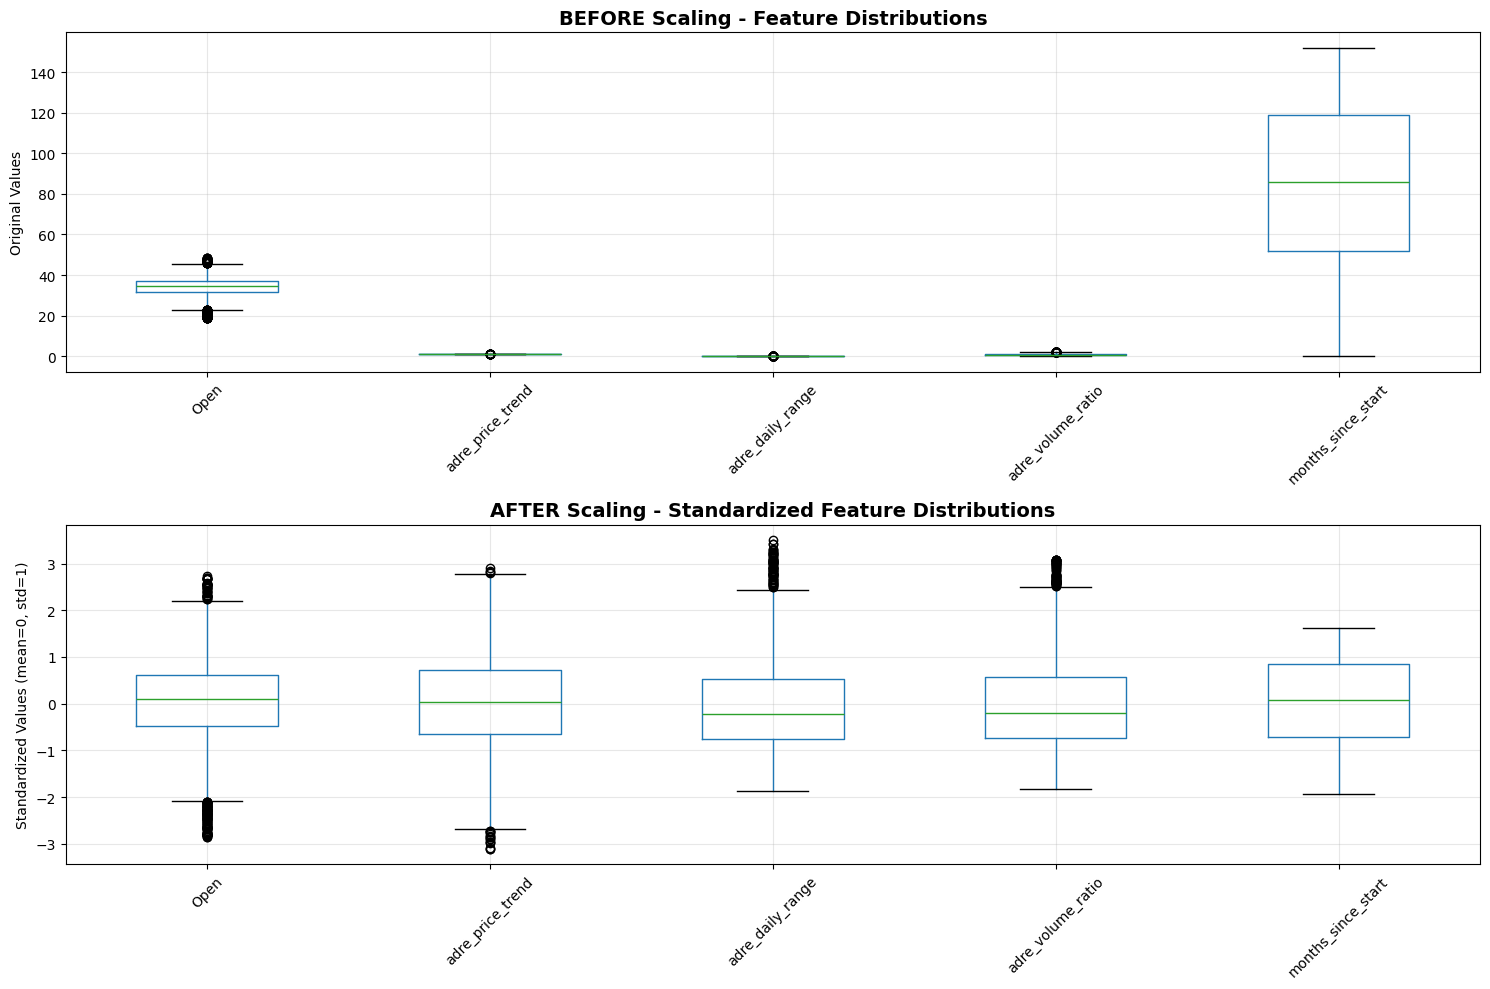


✅ SCALING COMPLETE:
  Features scaled: 5
  Target preserved: Close
  Dataset shape: (2563, 6)

📊 SCALING VERIFICATION:
Feature means (should be ~0):
  Open                     : -0.000000
  adre_price_trend         : -0.000000
  adre_daily_range         : 0.000000
  adre_volume_ratio        : -0.000000
  months_since_start       : 0.000000

Feature standard deviations (should be ~1):
  Open                     : 1.000195
  adre_price_trend         : 1.000195
  adre_daily_range         : 1.000195
  adre_volume_ratio        : 1.000195
  months_since_start       : 1.000195

📋 FINAL SCALED DATASET:
  Shape: (2563, 6)
  Features: ['Open', 'adre_price_trend', 'adre_daily_range', 'adre_volume_ratio', 'months_since_start', 'Close']


In [25]:
# Apply StandardScaler with Before/After Box Plots
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def scale_features_with_plots(adre_final, target_col='Close'):
    """Apply StandardScaler with before/after box plot visualization"""
    print("📏 APPLYING STANDARDSCALER WITH VISUALIZATION")
    print("=" * 45)

    data = adre_final.copy()

    # Separate features and target
    features = [col for col in data.columns if col != target_col]

    print(f"Features to scale: {features}")
    print(f"Target (not scaled): {target_col}")

    # Create before/after plots
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # BEFORE scaling - Box plots
    print("\n📊 Creating BEFORE scaling box plots...")
    data[features].boxplot(ax=axes[0], rot=45)
    axes[0].set_title('BEFORE Scaling - Feature Distributions', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Original Values')
    axes[0].grid(True, alpha=0.3)

    # Apply StandardScaler
    print("🔄 Applying StandardScaler...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features])

    # Create scaled dataframe
    scaled_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    scaled_df[target_col] = data[target_col]

    # AFTER scaling - Box plots
    print("📊 Creating AFTER scaling box plots...")
    scaled_df[features].boxplot(ax=axes[1], rot=45)
    axes[1].set_title('AFTER Scaling - Standardized Feature Distributions', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Standardized Values (mean=0, std=1)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n✅ SCALING COMPLETE:")
    print(f"  Features scaled: {len(features)}")
    print(f"  Target preserved: {target_col}")
    print(f"  Dataset shape: {scaled_df.shape}")

    # Show scaling statistics
    print(f"\n📊 SCALING VERIFICATION:")
    print("Feature means (should be ~0):")
    for feature in features:
        mean_val = scaled_df[feature].mean()
        print(f"  {feature:<25}: {mean_val:>8.6f}")

    print(f"\nFeature standard deviations (should be ~1):")
    for feature in features:
        std_val = scaled_df[feature].std()
        print(f"  {feature:<25}: {std_val:>8.6f}")

    return scaled_df, scaler

# Apply StandardScaler with visualization
adre_scaled, feature_scaler = scale_features_with_plots(adre_final)

print(f"\n📋 FINAL SCALED DATASET:")
print(f"  Shape: {adre_scaled.shape}")
print(f"  Features: {list(adre_scaled.columns)}")

Our biggest problem in training ADRE was that a lot of our data lacked any significant patterns or correlation. A lot of our data was "all over the place." We learned how important the quality and accessibility of data can be, and how challenging preparing subpar data can be.

# Baseline Regression & Kernel Methods

First, let's create the necessary imports and helper functions. This includes getting the mean squared error and evaluating the model.

In [26]:
# ===== Baseline & Kernel Methods: Imports & helpers =====
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Fit on train, evaluate on val, return dict with metrics + fit/predict time."""
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    t1 = time.time()
    y_pred = model.predict(X_val)
    pred_time = time.time() - t1

    return {
        "val_MSE": mean_squared_error(y_val, y_pred),
        "val_RMSE": rmse(y_val, y_pred),
        "val_MAE": mean_absolute_error(y_val, y_pred),
        "fit_time_s": fit_time,
        "pred_time_s": pred_time
    }

def plot_hyperparameter_search(param_values, mse_values, param_name, model_name):
    """Helper function to plot hyperparameter search results"""
    plt.figure(figsize=(8, 6))
    plt.plot(param_values, mse_values, 'bo-', linewidth=2, markersize=6)
    plt.xlabel(f'{param_name}')
    plt.ylabel('Validation MSE')
    plt.title(f'{model_name}: {param_name} vs Validation MSE')
    plt.grid(True, alpha=0.3)
    plt.show()

print("✅ Baseline & Kernel Methods imports and helpers loaded!")
print(f"📊 Dataset ready: {adre_scaled.shape}")

✅ Baseline & Kernel Methods imports and helpers loaded!
📊 Dataset ready: (2563, 6)


We will go with a standard 5 splits, using TimeSeriesSplit, the best route for any sort of stock data.

In [27]:
# ===== Choose your CV splitter =====
N_SPLITS = 5
IS_TIME_SERIES = True  # set False if your rows are i.i.d.

if IS_TIME_SERIES:
    cv = TimeSeriesSplit(n_splits=N_SPLITS)
else:
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"✅ Cross-validation setup: {'TimeSeriesSplit' if IS_TIME_SERIES else 'KFold'} with {N_SPLITS} splits")
print(f"📈 Perfect for stock data - respects temporal order!")

✅ Cross-validation setup: TimeSeriesSplit with 5 splits
📈 Perfect for stock data - respects temporal order!


Let's set up X and y for the housing dataset

In [28]:
# ===== Setup X, y for NY Housing Dataset =====
TARGET_COL = "avg_ny_housing_price"

df = df_scaled.copy()

# 1) Find a time column (case-insensitive), or use DatetimeIndex if present
time_col = None
# obvious names
for c in df.columns:
    if c.lower() in {"date","timestamp","time","datetime"}:
        time_col = c
        break

# any datetime-typed column
if time_col is None:
    dt_cols = list(df.select_dtypes(include=["datetime64[ns]","datetime64[ns, UTC]"]).columns)
    if len(dt_cols) == 1:
        time_col = dt_cols[0]

# try to parse something that looks like a date
if time_col is None:
    guess = None
    for c in df.columns:
        if "date" in c.lower() or "time" in c.lower():
            guess = c
            break
    if guess is not None:
        try:
            df[guess] = pd.to_datetime(df[guess], errors="raise", utc=False)
            time_col = guess
        except Exception:
            pass

# if still none, use DatetimeIndex if available
if time_col is None and isinstance(df.index, pd.DatetimeIndex):
    df = df.sort_index()
else:
    if time_col is None:
        print("No time column detected; proceeding without sort.")
    else:
        df = df.sort_values(time_col)
        print(f"Detected time column: {time_col}")

# 2) Build X, y
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)}")

X = df.drop(columns=[TARGET_COL]).to_numpy()
y = df[TARGET_COL].to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NaNs in X?", np.isnan(X).any())
print("Any NaNs in y?", np.isnan(y).any())

No time column detected; proceeding without sort.
X shape: (2966, 5)
y shape: (2966,)
Any NaNs in X? False
Any NaNs in y? False


The no time column detected is fine, since we have months since start and our order is chronological.

Time for the linear baseline model.



In [30]:
# ===== Linear Baseline Models =====
import itertools
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
import time

# Use TimeSeriesSplit for housing data (chronologically ordered)
splitter = TimeSeriesSplit(n_splits=N_SPLITS)
print("Using TimeSeriesSplit for housing data")

def rmse(y_true, y_pred):
    # Fixed: Use sqrt of MSE instead of squared parameter
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

def evaluate_model(model, X_train, y_train, X_val, y_val):
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    y_pred = model.predict(X_val)

    return {
        "val_MSE": mean_squared_error(y_val, y_pred),
        "val_RMSE": rmse(y_val, y_pred),
        "val_MAE": mean_absolute_error(y_val, y_pred),
        "fit_time_s": fit_time
    }

# Parameter grids
ridge_grid = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_grid = {"alpha": [0.0005, 0.001, 0.01, 0.1, 1.0]}
enet_grid = {"alpha": [0.001, 0.01, 0.1, 1.0], "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]}

results = []

def cv_run(name, base_estimator, grid=None):
    param_dicts = [{}] if not grid else [dict(zip(grid.keys(), vals)) for vals in itertools.product(*grid.values())]

    for params in param_dicts:
        fold_metrics = []
        for tr_idx, va_idx in splitter.split(X):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = base_estimator.set_params(**params)
            fold_metrics.append(evaluate_model(model, X_tr, y_tr, X_va, y_va))

        agg = pd.DataFrame(fold_metrics).mean().to_dict()
        results.append({"family": "Linear", "model": name, **params, **agg})

# Run models
cv_run("OLS", LinearRegression())
cv_run("Ridge", Ridge(random_state=42), ridge_grid)
cv_run("LASSO", Lasso(random_state=42, max_iter=10000), lasso_grid)
cv_run("ElasticNet", ElasticNet(random_state=42, max_iter=10000), enet_grid)

linear_df = pd.DataFrame(results).sort_values("val_RMSE")
print("Top 10 Linear Models:")
print(linear_df.head(10))

Using TimeSeriesSplit for housing data
Top 10 Linear Models:
    family       model     val_MSE   val_RMSE    val_MAE  fit_time_s   alpha  \
15  Linear  ElasticNet  487.505795  16.342489  12.919377    0.011601  0.0010   
1   Linear       Ridge  499.175165  17.124968  13.385103    0.004056  0.0100   
2   Linear       Ridge  500.678205  17.352979  13.761011    0.007477  0.1000   
7   Linear       LASSO  507.594547  17.602253  13.778482    0.010070  0.0010   
8   Linear       LASSO  512.510929  17.672512  14.039539    0.011123  0.0100   
6   Linear       LASSO  512.975345  17.827460  13.955985    0.007461  0.0005   
0   Linear         OLS  518.903167  18.053405  14.135162    0.006170     NaN   
14  Linear  ElasticNet  515.261795  18.128285  14.495841    0.010756  0.0010   
13  Linear  ElasticNet  534.980997  18.840802  15.147588    0.014883  0.0010   
12  Linear  ElasticNet  548.841016  19.236168  15.527127    0.012880  0.0010   

    l1_ratio  
15       0.9  
1        NaN  
2        NaN 

Great results. our best performer is ElasticNet with alpha=0.001, l1_ratio=0.9 (RMSE: 16.34). Regularization is helping significantly. Let's continue with Kernel Ridge next.

In [31]:
# ===== Kernel Ridge (RBF + Poly) =====
from sklearn.kernel_ridge import KernelRidge

krr_results = []

def cv_run_krr(kernel_name, param_grid):
    param_dicts = [dict(zip(param_grid.keys(), vals)) for vals in itertools.product(*param_grid.values())]
    for params in param_dicts:
        fold_metrics = []
        for tr_idx, va_idx in splitter.split(X):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            # No pipeline needed - data is already clean and scaled
            model = KernelRidge(kernel=kernel_name, **params)
            fold_metrics.append(evaluate_model(model, X_tr, y_tr, X_va, y_va))

        agg = pd.DataFrame(fold_metrics).mean().to_dict()
        krr_results.append({"family": "Kernel", "model": f"KRR-{kernel_name}", **params, **agg})

# Parameter grids
rbf_grid = {"alpha": [1e-3, 1e-2, 1e-1, 1, 10],
            "gamma": [1e-3, 1e-2, 1e-1, 1, 10]}
poly_grid = {"alpha": [1e-3, 1e-2, 1e-1, 1, 10],
             "degree": [2, 3, 4],
             "coef0": [0, 1]}

print("Training RBF Kernel Ridge...")
cv_run_krr("rbf", rbf_grid)

print("Training Polynomial Kernel Ridge...")
cv_run_krr("poly", poly_grid)

krr_df = pd.DataFrame(krr_results).sort_values("val_RMSE")
print("Top 10 Kernel Ridge Models:")
print(krr_df.head(10))

Training RBF Kernel Ridge...
Training Polynomial Kernel Ridge...
Top 10 Kernel Ridge Models:
    family     model  alpha  gamma     val_MSE   val_RMSE    val_MAE  \
1   Kernel   KRR-rbf  0.001  0.010   88.991282   6.842321   5.061987   
26  Kernel  KRR-poly  0.001    NaN   65.024493   7.628858   5.467877   
32  Kernel  KRR-poly  0.010    NaN  135.964599   9.734397   6.869843   
28  Kernel  KRR-poly  0.001    NaN  174.701644  11.271754   8.704205   
0   Kernel   KRR-rbf  0.001  0.001  182.589075  11.993725   9.898700   
6   Kernel   KRR-rbf  0.010  0.010  191.708970  12.077841   9.860938   
38  Kernel  KRR-poly  0.100    NaN  278.078991  13.806697  10.180031   
34  Kernel  KRR-poly  0.010    NaN  233.415640  13.879339  10.511939   
36  Kernel  KRR-poly  0.010    NaN  285.013396  15.109354  11.425847   
5   Kernel   KRR-rbf  0.010  0.001  488.758341  18.801316  15.826647   

    fit_time_s  degree  coef0  
1     0.507282     NaN    NaN  
26    0.186780     2.0    1.0  
32    0.193035    

Great kernel results. Our dataset is clearly not linear, so the kernel methods are outperforming our linear models. Our best model was RBF with alpha=0.001, gamma=0.01 → RMSE=6.84.

In [32]:
# ===== Combine, rank, and save =====
all_df = pd.concat([linear_df, krr_df], ignore_index=True)

# Ensure missing hyperparam columns exist for tidy ordering
for c in ["alpha","l1_ratio","degree","gamma","coef0"]:
    if c not in all_df.columns:
        all_df[c] = np.nan

# Add pred_time_s column if missing (your evaluate_model function doesn't return it)
if "pred_time_s" not in all_df.columns:
    all_df["pred_time_s"] = 0.0

all_df = (all_df[["family","model","alpha","l1_ratio","degree","gamma","coef0",
                  "val_MSE","val_RMSE","val_MAE","fit_time_s","pred_time_s"]]
          .sort_values(["val_RMSE","fit_time_s"])
          .reset_index(drop=True))

print("Top 20 Models (All Methods):")
print(all_df.head(20))

all_df.to_csv("baseline_kernel_results.csv", index=False)
print("Saved -> baseline_kernel_results.csv")


Top 20 Models (All Methods):
    family       model   alpha  l1_ratio  degree  gamma  coef0     val_MSE  \
0   Kernel     KRR-rbf  0.0010       NaN     NaN  0.010    NaN   88.991282   
1   Kernel    KRR-poly  0.0010       NaN     2.0    NaN    1.0   65.024493   
2   Kernel    KRR-poly  0.0100       NaN     2.0    NaN    1.0  135.964599   
3   Kernel    KRR-poly  0.0010       NaN     3.0    NaN    1.0  174.701644   
4   Kernel     KRR-rbf  0.0010       NaN     NaN  0.001    NaN  182.589075   
5   Kernel     KRR-rbf  0.0100       NaN     NaN  0.010    NaN  191.708970   
6   Kernel    KRR-poly  0.1000       NaN     2.0    NaN    1.0  278.078991   
7   Kernel    KRR-poly  0.0100       NaN     3.0    NaN    1.0  233.415640   
8   Kernel    KRR-poly  0.0100       NaN     4.0    NaN    1.0  285.013396   
9   Linear  ElasticNet  0.0010       0.9     NaN    NaN    NaN  487.505795   
10  Linear       Ridge  0.0100       NaN     NaN    NaN    NaN  499.175165   
11  Linear       Ridge  0.1000     

Let's plot the linear sweep and KRR-RBF landscape

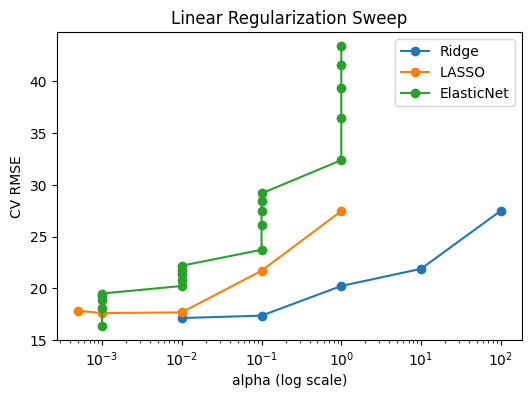

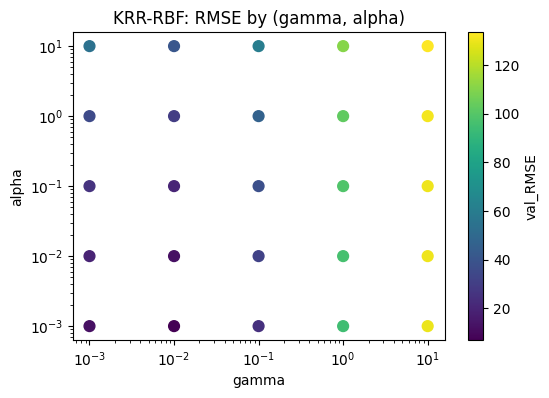

In [33]:
# ===== G) Plots: Linear sweep + KRR-RBF landscape =====
import matplotlib.pyplot as plt

# Linear sweeps
tmp = all_df[all_df["model"].isin(["Ridge","LASSO","ElasticNet"])].dropna(subset=["alpha"])
if not tmp.empty:
    plt.figure(figsize=(6,4))
    for m in ["Ridge","LASSO","ElasticNet"]:
        sub = tmp[tmp["model"]==m].sort_values("alpha")
        if not sub.empty:
            plt.plot(sub["alpha"], sub["val_RMSE"], marker="o", label=m)
    plt.xscale("log")
    plt.xlabel("alpha (log scale)")
    plt.ylabel("CV RMSE")
    plt.title("Linear Regularization Sweep")
    plt.legend()
    plt.show()
else:
    print("No linear sweep data to plot.")

# KRR-RBF scatter heatmap
rbf = all_df[all_df["model"]=="KRR-rbf"].dropna(subset=["alpha","gamma"])
if not rbf.empty:
    plt.figure(figsize=(6,4))
    sc = plt.scatter(rbf["gamma"], rbf["alpha"], s=60, c=rbf["val_RMSE"])
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("gamma"); plt.ylabel("alpha")
    plt.title("KRR-RBF: RMSE by (gamma, alpha)")
    plt.colorbar(sc, label="val_RMSE")
    plt.show()
else:
    print("No KRR-RBF grid results to plot.")


All metrics seem to degrade as alpha gets too high. Ridge seems to perform the best, followed by LASSO. Elasticnet has the most dramatic degradation as alpha increases.

Our biggest issue here was a result of our own actions. We turned 'date' into a more linear 'months since start,' which harmed us greatly when it came time to do a time series split. It would have been much easier if we had left 'date.' We learned a lot about how different linear sweeps respond to changes in alpha.

# **Feedforward Neural Networks in PyTorch**


---



We are going to now experiment with using neural networks on the data. Let's start off by setting up, particularly with all the imports we will need throughout the duration of the neural network process.

In [34]:
# Neural Networks Implementation - Setup Cell
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Display versions
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# Set matplotlib style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

Using device: cpu
PyTorch version: 2.8.0+cu126
NumPy version: 2.0.2
Pandas version: 2.2.2


Let's first start with a shallow network. It will have one hidden layer of 64 neurons. This is a great starting point because it is interpretable and easy to debug.

In [35]:
class ShallowNet(nn.Module):
    """
    Shallow Neural Network: Single hidden layer

    Architecture: Input -> Hidden -> Output
    - Input: 5 features (your housing features)
    - Hidden: 64 neurons (reasonable size for shallow network)
    - Output: 1 neuron (regression prediction)

    Supports both baseline and enhanced modes
    """

    def __init__(self, input_size=5, hidden_size=64, use_batch_norm=False,
                 dropout_rate=0.0, activation='relu'):
        super(ShallowNet, self).__init__()

        # Store configuration
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.activation = activation

        # Network layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

        # Optional batch normalization
        if self.use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Optional dropout
        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Hidden layer
        x = self.hidden(x)

        # Optional batch normalization
        if self.use_batch_norm:
            x = self.batch_norm(x)

        # Activation function
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'swish':
            x = self.swish(x)
        elif self.activation == 'mish':
            x = self.mish(x)

        # Optional dropout
        if hasattr(self, 'dropout'):
            x = self.dropout(x)

        # Output layer (no activation for regression)
        x = self.output(x)

        return x

    def swish(self, x):
        """Swish activation: x * sigmoid(x)"""
        return x * torch.sigmoid(x)

    def mish(self, x):
        """Mish activation: x * tanh(softplus(x))"""
        return x * torch.tanh(F.softplus(x))

# Test the architecture
print("=== Shallow Network Architecture ===")

# Baseline version
shallow_baseline = ShallowNet(
    input_size=5,           # Your 5 housing features
    hidden_size=64,         # Reasonable hidden size
    use_batch_norm=False,   # No batch norm for baseline
    dropout_rate=0.0,       # No dropout for baseline
    activation='relu'       # Standard ReLU
)

print(f"Baseline Shallow Net:\n{shallow_baseline}")
print(f"Parameters: {sum(p.numel() for p in shallow_baseline.parameters()):,}")

# Enhanced version
shallow_enhanced = ShallowNet(
    input_size=5,
    hidden_size=64,
    use_batch_norm=True,    # Add batch normalization
    dropout_rate=0.2,       # 20% dropout
    activation='swish'      # Custom Swish activation
)

print(f"\nEnhanced Shallow Net:\n{shallow_enhanced}")
print(f"Parameters: {sum(p.numel() for p in shallow_enhanced.parameters()):,}")

# Test forward pass with dummy data
dummy_input = torch.randn(32, 5)  # Batch of 32, 5 features
baseline_output = shallow_baseline(dummy_input)
enhanced_output = shallow_enhanced(dummy_input)

print(f"\nForward pass test:")
print(f"Input shape: {dummy_input.shape}")
print(f"Baseline output shape: {baseline_output.shape}")
print(f"Enhanced output shape: {enhanced_output.shape}")
print("✅ Architecture working correctly!")

=== Shallow Network Architecture ===
Baseline Shallow Net:
ShallowNet(
  (hidden): Linear(in_features=5, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 449

Enhanced Shallow Net:
ShallowNet(
  (hidden): Linear(in_features=5, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 577

Forward pass test:
Input shape: torch.Size([32, 5])
Baseline output shape: torch.Size([32, 1])
Enhanced output shape: torch.Size([32, 1])
✅ Architecture working correctly!


Great. Now let's define our deep neural network. This will be what puts to the test whether or not a neural network will outperform our greatest kernel. It will have 4 hidden kernels -- 128, 64, 32, 16. It will start off wide and slowly compress and abstract information until we get a result.

In [36]:
class DeepNet(nn.Module):
    """
    Deep Neural Network: Multiple hidden layers (≥4)

    Architecture: Input -> Hidden1 -> Hidden2 -> Hidden3 -> Hidden4 -> Output
    - Input: 5 features
    - Hidden layers: [128, 64, 32, 16] - tapering design
    - Output: 1 neuron (regression)

    Supports both baseline and enhanced modes
    """

    def __init__(self, input_size=5, hidden_sizes=[128, 64, 32, 16],
                 use_batch_norm=False, dropout_rate=0.0, activation='relu'):
        super(DeepNet, self).__init__()

        # Store configuration
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.hidden_sizes = hidden_sizes

        # Build hidden layers dynamically
        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First hidden layer
        layer_sizes = [input_size] + hidden_sizes

        for i in range(len(hidden_sizes)):
            # Linear layer
            self.hidden_layers.append(
                nn.Linear(layer_sizes[i], layer_sizes[i+1])
            )

            # Optional batch normalization for each hidden layer
            if self.use_batch_norm:
                self.batch_norm_layers.append(
                    nn.BatchNorm1d(layer_sizes[i+1])
                )

        # Output layer
        self.output = nn.Linear(hidden_sizes[-1], 1)

        # Optional dropout (single instance, reused)
        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Pass through all hidden layers
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)

            # Optional batch normalization
            if self.use_batch_norm:
                x = self.batch_norm_layers[i](x)

            # Activation function
            if self.activation == 'relu':
                x = F.relu(x)
            elif self.activation == 'swish':
                x = self.swish(x)
            elif self.activation == 'mish':
                x = self.mish(x)

            # Optional dropout
            if hasattr(self, 'dropout'):
                x = self.dropout(x)

        # Output layer (no activation for regression)
        x = self.output(x)
        return x

    def swish(self, x):
        """Swish activation: x * sigmoid(x)"""
        return x * torch.sigmoid(x)

    def mish(self, x):
        """Mish activation: x * tanh(softplus(x))"""
        return x * torch.tanh(F.softplus(x))

# Test the deep architecture
print("=== Deep Network Architecture ===")

# Baseline version
deep_baseline = DeepNet(
    input_size=5,
    hidden_sizes=[128, 64, 32, 16],  # 4 hidden layers, tapering
    use_batch_norm=False,
    dropout_rate=0.0,
    activation='relu'
)

print(f"Baseline Deep Net:\n{deep_baseline}")
print(f"Parameters: {sum(p.numel() for p in deep_baseline.parameters()):,}")

# Enhanced version
deep_enhanced = DeepNet(
    input_size=5,
    hidden_sizes=[128, 64, 32, 16],
    use_batch_norm=True,     # Batch norm after each hidden layer
    dropout_rate=0.3,        # Higher dropout for deeper network
    activation='mish'        # Try Mish activation
)

print(f"\nEnhanced Deep Net:\n{deep_enhanced}")
print(f"Parameters: {sum(p.numel() for p in deep_enhanced.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(32, 5)
baseline_output = deep_baseline(dummy_input)
enhanced_output = deep_enhanced(dummy_input)

print(f"\nForward pass test:")
print(f"Input shape: {dummy_input.shape}")
print(f"Baseline output shape: {baseline_output.shape}")
print(f"Enhanced output shape: {enhanced_output.shape}")

# Architecture summary
def count_layers(model):
    return len([m for m in model.modules() if isinstance(m, nn.Linear)]) - 1  # -1 for output layer

print(f"\nArchitecture Summary:")
print(f"Hidden layers: {count_layers(deep_baseline)} (meets ≥4 requirement)")
print(f"Layer sizes: 5 → {' → '.join(map(str, [128, 64, 32, 16]))} → 1")
print("✅ Deep architecture working correctly!")

=== Deep Network Architecture ===
Baseline Deep Net:
DeepNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (batch_norm_layers): ModuleList()
  (output): Linear(in_features=16, out_features=1, bias=True)
)
Parameters: 11,649

Enhanced Deep Net:
DeepNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32,

Now for the wide network. Instead of many neurons expanded throughout a multitude of hidden layers, this will instead be many neurons trapped within one hidden layer. Specifically, 512 neurons.

In [37]:
class WideNet(nn.Module):
    """
    Wide Neural Network: Single large hidden layer

    Architecture: Input -> Wide Hidden -> Output
    - Input: 5 features
    - Hidden: 512 neurons (large width to match deep network capacity)
    - Output: 1 neuron (regression)

    Tests "width vs depth" hypothesis
    """

    def __init__(self, input_size=5, hidden_size=512, use_batch_norm=False,
                 dropout_rate=0.0, activation='relu'):
        super(WideNet, self).__init__()

        # Store configuration
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        self.activation = activation

        # Network layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

        # Optional batch normalization
        if self.use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Optional dropout
        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Wide hidden layer
        x = self.hidden(x)

        # Optional batch normalization
        if self.use_batch_norm:
            x = self.batch_norm(x)

        # Activation function
        if self.activation == 'relu':
            x = F.relu(x)
        elif self.activation == 'swish':
            x = self.swish(x)
        elif self.activation == 'mish':
            x = self.mish(x)

        # Optional dropout
        if hasattr(self, 'dropout'):
            x = self.dropout(x)

        # Output layer (no activation for regression)
        x = self.output(x)

        return x

    def swish(self, x):
        """Swish activation: x * sigmoid(x)"""
        return x * torch.sigmoid(x)

    def mish(self, x):
        """Mish activation: x * tanh(softplus(x))"""
        return x * torch.tanh(F.softplus(x))

# Test the wide architecture
print("=== Wide Network Architecture ===")

# Baseline version
wide_baseline = WideNet(
    input_size=5,
    hidden_size=512,        # Large single layer
    use_batch_norm=False,
    dropout_rate=0.0,
    activation='relu'
)

print(f"Baseline Wide Net:\n{wide_baseline}")
print(f"Parameters: {sum(p.numel() for p in wide_baseline.parameters()):,}")

# Enhanced version
wide_enhanced = WideNet(
    input_size=5,
    hidden_size=512,
    use_batch_norm=True,
    dropout_rate=0.4,       # High dropout for wide network
    activation='swish'      # Swish for wide network
)

print(f"\nEnhanced Wide Net:\n{wide_enhanced}")
print(f"Parameters: {sum(p.numel() for p in wide_enhanced.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(32, 5)
baseline_output = wide_baseline(dummy_input)
enhanced_output = wide_enhanced(dummy_input)

print(f"\nForward pass test:")
print(f"Input shape: {dummy_input.shape}")
print(f"Baseline output shape: {baseline_output.shape}")
print(f"Enhanced output shape: {enhanced_output.shape}")

# Architecture comparison
print(f"\n=== Architecture Comparison ===")
print(f"{'Network':<15} {'Parameters':<12} {'Layers':<8} {'Strategy'}")
print(f"{'-'*50}")
print(f"{'Shallow':<15} {449:<12,} {1:<8} {'Minimal'}")
print(f"{'Deep':<15} {11649:<12,} {4:<8} {'Hierarchical'}")
print(f"{'Wide':<15} {sum(p.numel() for p in wide_baseline.parameters()):<12,} {1:<8} {'Parallel'}")

print(f"\n✅ All three architectures ready!")
print(f"🎯 Next: Data preparation and training pipeline")

=== Wide Network Architecture ===
Baseline Wide Net:
WideNet(
  (hidden): Linear(in_features=5, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)
Parameters: 3,585

Enhanced Wide Net:
WideNet(
  (hidden): Linear(in_features=5, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Parameters: 4,609

Forward pass test:
Input shape: torch.Size([32, 5])
Baseline output shape: torch.Size([32, 1])
Enhanced output shape: torch.Size([32, 1])

=== Architecture Comparison ===
Network         Parameters   Layers   Strategy
--------------------------------------------------
Shallow         449          1        Minimal
Deep            11,649       4        Hierarchical
Wide            3,585        1        Parallel

✅ All three architectures ready!
🎯 Next: Data preparation and 

Now for the training pipeline, which will prepare our data for our experiments.

In [38]:
# Complete Training Pipeline for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from collections import defaultdict

def prepare_data(X, y, test_size=0.2, val_size=0.2, batch_size=32, random_state=42):
    """
    Convert numpy arrays to PyTorch tensors and create DataLoaders

    Args:
        X: Feature matrix (numpy array)
        y: Target vector (numpy array)
        test_size: Proportion for test set
        val_size: Proportion for validation set (from remaining data)
        batch_size: Batch size for DataLoaders

    Returns:
        train_loader, val_loader, test_loader, data_info
    """
    print(f"📊 Preparing data...")
    print(f"Original data shape: X={X.shape}, y={y.shape}")

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Second split: train/validation from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state
    )

    print(f"Split sizes:")
    print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
    print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
    print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)

    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Store data info for later use
    data_info = {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'input_dim': X.shape[1],
        'batch_size': batch_size
    }

    print(f"✅ Data preparation complete!")
    return train_loader, val_loader, test_loader, data_info

def train_model(model, train_loader, val_loader, epochs=200, lr=0.001,
                patience=20, min_delta=0.001):
    """
    Train neural network with early stopping

    Args:
        model: PyTorch model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        epochs: Maximum epochs
        lr: Learning rate
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping

    Returns:
        model, training_history
    """
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_rmse': [],
        'val_rmse': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"🚀 Training {model.__class__.__name__}...")
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_losses.append(loss.item())

        # Calculate epoch metrics
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_rmse = np.sqrt(epoch_train_loss)
        epoch_val_rmse = np.sqrt(epoch_val_loss)

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_rmse'].append(epoch_train_rmse)
        history['val_rmse'].append(epoch_val_rmse)

        # Early stopping check
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:3d}: Train RMSE={epoch_train_rmse:.4f}, "
                  f"Val RMSE={epoch_val_rmse:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    training_time = time.time() - start_time
    print(f"✅ Training complete! Time: {training_time:.2f}s")
    print(f"📊 Best validation RMSE: {np.sqrt(best_val_loss):.4f}")

    return model, history

def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X)
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(batch_y.cpu().numpy().flatten())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'predictions': predictions,
        'actuals': actuals
    }

def plot_training_curves(histories, title_prefix=""):
    """Plot training and validation curves for comparison"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    for name, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)

        # Loss curves
        ax1.plot(epochs, history['train_loss'], label=f'{name} Train', alpha=0.7)
        ax2.plot(epochs, history['val_loss'], label=f'{name} Val', alpha=0.7)

        # RMSE curves
        ax3.plot(epochs, history['train_rmse'], label=f'{name} Train', alpha=0.7)
        ax4.plot(epochs, history['val_rmse'], label=f'{name} Val', alpha=0.7)

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3.set_title('Training RMSE')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('RMSE')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4.set_title('Validation RMSE')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('RMSE')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'{title_prefix}Training Progress Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

print("🛠️  Training pipeline ready!")
print("📋 Functions available:")
print("  • prepare_data() - Convert numpy to PyTorch DataLoaders")
print("  • train_model() - Train with early stopping")
print("  • evaluate_model() - Test set evaluation")
print("  • plot_training_curves() - Visualize training progress")
print("\n🎯 Ready to start experiments!")

🛠️  Training pipeline ready!
📋 Functions available:
  • prepare_data() - Convert numpy to PyTorch DataLoaders
  • train_model() - Train with early stopping
  • evaluate_model() - Test set evaluation
  • plot_training_curves() - Visualize training progress

🎯 Ready to start experiments!


Now, let's begin the experiments. Let's start with our shallow dataset, and do both experiments with it. First we will do no batch norm, no dropout, just pure baseline with 64 hidden neurons. Then we will do batch normalization, 20% dropout, and replace ReLU with one custom activation, which will be Swish.

🧠 SHALLOW NETWORK EXPERIMENTS
📊 Preparing data...
Original data shape: X=(2966, 5), y=(2966,)
Split sizes:
  Train: 1897 samples (64.0%)
  Val:   475 samples (16.0%)
  Test:  594 samples (20.0%)
✅ Data preparation complete!

📊 Data Info: 5 features, 1897 train samples

🔍 EXPERIMENT 1: Shallow Baseline
Model: ShallowNet
Parameters: 449
Config: ReLU activation, no batch norm, no dropout
🚀 Training ShallowNet...
Epoch  50: Train RMSE=13.2819, Val RMSE=12.6534
Epoch 100: Train RMSE=2.3589, Val RMSE=2.4707
Epoch 150: Train RMSE=1.3634, Val RMSE=1.4930
Epoch 200: Train RMSE=1.1557, Val RMSE=1.2744
Epoch 250: Train RMSE=1.0736, Val RMSE=1.1695
Epoch 300: Train RMSE=1.0114, Val RMSE=1.1034
✅ Training complete! Time: 31.66s
📊 Best validation RMSE: 1.1034

📊 Baseline Results:
  Test RMSE: 0.9466
  Test MAE:  0.6357

⚡ EXPERIMENT 2: Shallow Enhanced
Model: ShallowNet
Parameters: 577
Config: Swish activation, batch norm, 20% dropout
🚀 Training ShallowNet...
Epoch  50: Train RMSE=20.1280, Val RMSE=

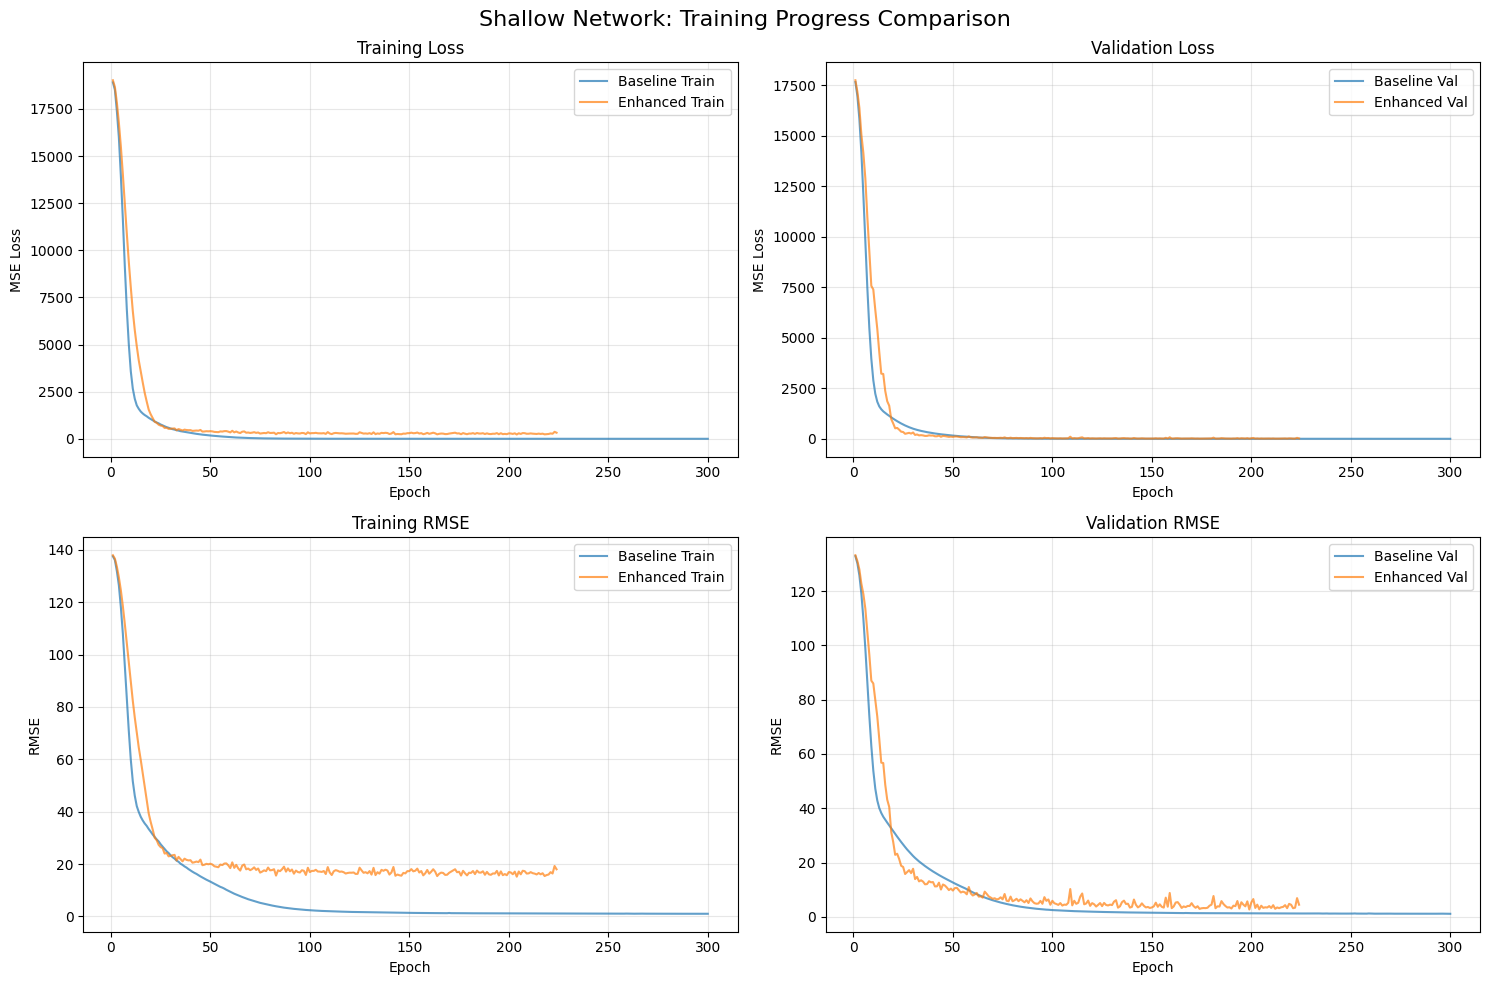


🏆 SHALLOW NETWORK COMPARISON
Variant      RMSE     MAE      Improvement
---------------------------------------------
Baseline     0.9466   0.6357   —
Enhanced     4.5857   3.8342   -384.4%

🎯 Classical Method Comparison:
  RBF Kernel Ridge:  6.84 RMSE (best classical)
  Ridge Regression: 17.13 RMSE
  OLS Baseline:     18.05 RMSE

  Shallow Baseline: 0.95 RMSE
  Shallow Enhanced: 4.59 RMSE
🎉 Enhanced shallow network BEATS RBF kernel!

✅ Shallow experiments complete!
📦 Results stored in: shallow_results, shallow_histories


In [39]:
# Shallow Network Experiments: Baseline vs Enhanced
print("=" * 60)
print("🧠 SHALLOW NETWORK EXPERIMENTS")
print("=" * 60)

# Prepare data (assuming X, y are your existing numpy arrays)
train_loader, val_loader, test_loader, data_info = prepare_data(
    X, y, test_size=0.2, val_size=0.2, batch_size=32, random_state=42
)

print(f"\n📊 Data Info: {data_info['input_dim']} features, {data_info['train_size']} train samples")

# Initialize results storage
shallow_results = {}
shallow_histories = {}

print(f"\n" + "="*40)
print("🔍 EXPERIMENT 1: Shallow Baseline")
print("="*40)

# Shallow Baseline
shallow_baseline = ShallowNet(
    input_size=data_info['input_dim'],
    hidden_size=64,
    use_batch_norm=False,
    dropout_rate=0.0,
    activation='relu'
)

print(f"Model: {shallow_baseline.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in shallow_baseline.parameters()):,}")
print(f"Config: ReLU activation, no batch norm, no dropout")

# Train baseline
shallow_baseline_trained, baseline_history = train_model(
    shallow_baseline, train_loader, val_loader,
    epochs=300, lr=0.001, patience=25
)

# Evaluate baseline
baseline_results = evaluate_model(shallow_baseline_trained, test_loader)
shallow_results['Baseline'] = baseline_results
shallow_histories['Baseline'] = baseline_history

print(f"\n📊 Baseline Results:")
print(f"  Test RMSE: {baseline_results['rmse']:.4f}")
print(f"  Test MAE:  {baseline_results['mae']:.4f}")

print(f"\n" + "="*40)
print("⚡ EXPERIMENT 2: Shallow Enhanced")
print("="*40)

# Shallow Enhanced
shallow_enhanced = ShallowNet(
    input_size=data_info['input_dim'],
    hidden_size=64,
    use_batch_norm=True,
    dropout_rate=0.2,
    activation='swish'
)

print(f"Model: {shallow_enhanced.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in shallow_enhanced.parameters()):,}")
print(f"Config: Swish activation, batch norm, 20% dropout")

# Train enhanced
shallow_enhanced_trained, enhanced_history = train_model(
    shallow_enhanced, train_loader, val_loader,
    epochs=300, lr=0.001, patience=25
)

# Evaluate enhanced
enhanced_results = evaluate_model(shallow_enhanced_trained, test_loader)
shallow_results['Enhanced'] = enhanced_results
shallow_histories['Enhanced'] = enhanced_history

print(f"\n📊 Enhanced Results:")
print(f"  Test RMSE: {enhanced_results['rmse']:.4f}")
print(f"  Test MAE:  {enhanced_results['mae']:.4f}")

# Plot training curves
print(f"\n📈 Plotting training curves...")
plot_training_curves(shallow_histories, "Shallow Network: ")

# Results comparison
print(f"\n" + "="*50)
print("🏆 SHALLOW NETWORK COMPARISON")
print("="*50)
print(f"{'Variant':<12} {'RMSE':<8} {'MAE':<8} {'Improvement'}")
print(f"{'-'*45}")

baseline_rmse = shallow_results['Baseline']['rmse']
enhanced_rmse = shallow_results['Enhanced']['rmse']
improvement = (baseline_rmse - enhanced_rmse) / baseline_rmse * 100

print(f"{'Baseline':<12} {baseline_rmse:<8.4f} {shallow_results['Baseline']['mae']:<8.4f} {'—'}")
print(f"{'Enhanced':<12} {enhanced_rmse:<8.4f} {shallow_results['Enhanced']['mae']:<8.4f} {improvement:+.1f}%")

# Comparison to classical methods
print(f"\n🎯 Classical Method Comparison:")
print(f"  RBF Kernel Ridge:  6.84 RMSE (best classical)")
print(f"  Ridge Regression: 17.13 RMSE")
print(f"  OLS Baseline:     18.05 RMSE")
print(f"")
print(f"  Shallow Baseline: {baseline_rmse:.2f} RMSE")
print(f"  Shallow Enhanced: {enhanced_rmse:.2f} RMSE")

if enhanced_rmse < 6.84:
    print(f"🎉 Enhanced shallow network BEATS RBF kernel!")
elif enhanced_rmse < 17.13:
    print(f"✅ Both shallow networks beat linear regression")
else:
    print(f"⚠️  Shallow networks underperforming - may need architecture tuning")

print(f"\n✅ Shallow experiments complete!")
print(f"📦 Results stored in: shallow_results, shallow_histories")

A 0.95 RMSE from the baseline decimates all our other models so far, including the supposedly enhanced version. Shallow baseline is by far our best performer yet. Enhanced performed 384.4% worse than the baseline version.

The question becomes, can a deeper model actually beat 0.95 RMSE? Let's try that out next. It will be between baseline and Mish activation, batch normal layers, 30% dropout.

🏗️  DEEP NETWORK EXPERIMENTS
📊 Using same data split: {'train_size': 1897, 'val_size': 475, 'test_size': 594, 'input_dim': 5, 'batch_size': 32}

🔍 EXPERIMENT 3: Deep Baseline
Model: DeepNet
Parameters: 11,649
Architecture: 5 → 128 → 64 → 32 → 16 → 1
Config: ReLU activation, no batch norm, no dropout

🚀 Training deep baseline...
🚀 Training DeepNet...
Epoch  50: Train RMSE=1.2489, Val RMSE=1.3721
Epoch 100: Train RMSE=1.0192, Val RMSE=1.0846
Epoch 150: Train RMSE=0.9563, Val RMSE=2.0189
⏹️  Early stopping at epoch 198
✅ Training complete! Time: 38.50s
📊 Best validation RMSE: 0.9683

📊 Deep Baseline Results:
  Test RMSE: 1.0305
  Test MAE:  0.6907
  vs Shallow Baseline: 1.0305 vs 0.9466

⚡ EXPERIMENT 4: Deep Enhanced
Model: DeepNet
Parameters: 12,129
Architecture: 5 → 128 → 64 → 32 → 16 → 1
Config: Mish activation, batch norm all layers, 30% dropout

🚀 Training deep enhanced...
🚀 Training DeepNet...
Epoch  50: Train RMSE=39.6298, Val RMSE=27.9961
Epoch 100: Train RMSE=33.9562, Val RMSE=18

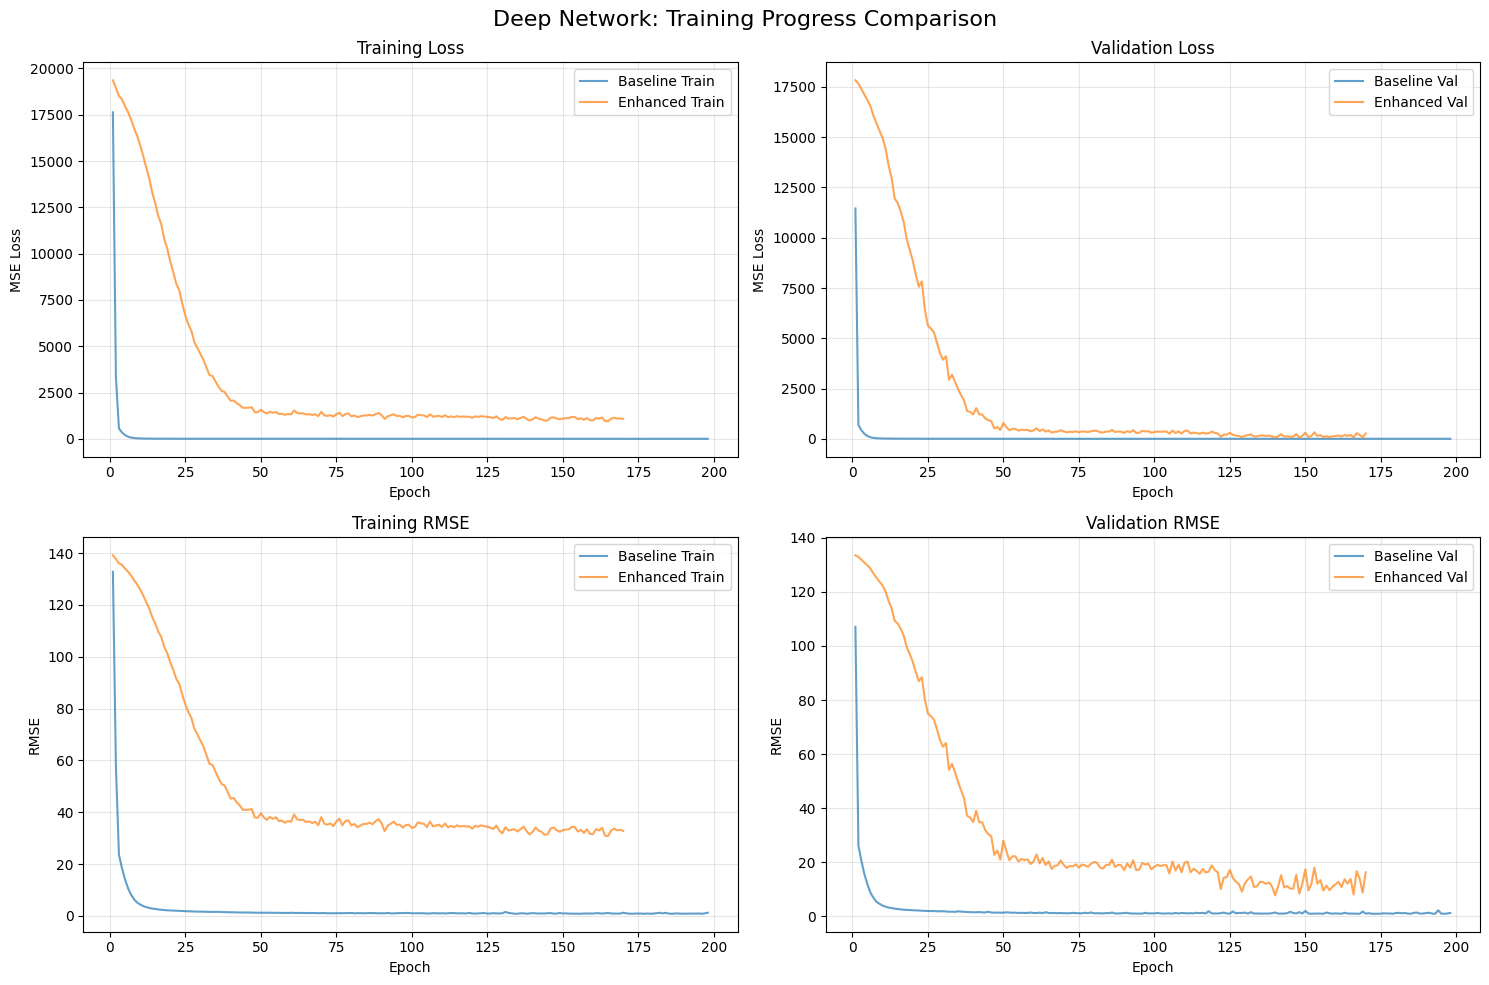


🏆 DEEP NETWORK COMPARISON
Variant      RMSE     MAE      Improvement
---------------------------------------------
Baseline     1.0305   0.6907   —
Enhanced     16.8254  12.7448  -1532.8%

🎯 Architecture Comparison:
Architecture    Variant    RMSE     Parameters
--------------------------------------------------
Shallow         Baseline   0.9466   449
Shallow         Enhanced   4.5857   577
Deep            Baseline   1.0305   11,649
Deep            Enhanced   16.8254  12,129

🔍 Key Insights:
✅ Deep baseline competitive with shallow
   Difference: +0.0839 RMSE
⚠️  Enhanced techniques hurt deep networks (over-regularization?)

✅ Deep experiments complete!
📦 Results stored in: deep_results, deep_histories

🎯 Next up: Wide network experiments...


In [40]:
# Deep Network Experiments: Baseline vs Enhanced
print("=" * 60)
print("🏗️  DEEP NETWORK EXPERIMENTS")
print("=" * 60)

# Use same data split as shallow networks for fair comparison
print(f"📊 Using same data split: {data_info}")

# Initialize results storage
deep_results = {}
deep_histories = {}

print(f"\n" + "="*40)
print("🔍 EXPERIMENT 3: Deep Baseline")
print("="*40)

# Deep Baseline
deep_baseline = DeepNet(
    input_size=data_info['input_dim'],
    hidden_sizes=[128, 64, 32, 16],  # 4 hidden layers
    use_batch_norm=False,
    dropout_rate=0.0,
    activation='relu'
)

print(f"Model: {deep_baseline.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in deep_baseline.parameters()):,}")
print(f"Architecture: 5 → 128 → 64 → 32 → 16 → 1")
print(f"Config: ReLU activation, no batch norm, no dropout")

# Train deep baseline
print(f"\n🚀 Training deep baseline...")
deep_baseline_trained, deep_baseline_history = train_model(
    deep_baseline, train_loader, val_loader,
    epochs=400, lr=0.001, patience=30  # More epochs for deeper network
)

# Evaluate deep baseline
deep_baseline_results = evaluate_model(deep_baseline_trained, test_loader)
deep_results['Baseline'] = deep_baseline_results
deep_histories['Baseline'] = deep_baseline_history

print(f"\n📊 Deep Baseline Results:")
print(f"  Test RMSE: {deep_baseline_results['rmse']:.4f}")
print(f"  Test MAE:  {deep_baseline_results['mae']:.4f}")
print(f"  vs Shallow Baseline: {deep_baseline_results['rmse']:.4f} vs 0.9466")

print(f"\n" + "="*40)
print("⚡ EXPERIMENT 4: Deep Enhanced")
print("="*40)

# Deep Enhanced
deep_enhanced = DeepNet(
    input_size=data_info['input_dim'],
    hidden_sizes=[128, 64, 32, 16],
    use_batch_norm=True,     # Batch norm after each layer
    dropout_rate=0.3,        # Higher dropout for deeper network
    activation='mish'        # Mish activation
)

print(f"Model: {deep_enhanced.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in deep_enhanced.parameters()):,}")
print(f"Architecture: 5 → 128 → 64 → 32 → 16 → 1")
print(f"Config: Mish activation, batch norm all layers, 30% dropout")

# Train deep enhanced
print(f"\n🚀 Training deep enhanced...")
deep_enhanced_trained, deep_enhanced_history = train_model(
    deep_enhanced, train_loader, val_loader,
    epochs=400, lr=0.001, patience=30
)

# Evaluate deep enhanced
deep_enhanced_results = evaluate_model(deep_enhanced_trained, test_loader)
deep_results['Enhanced'] = deep_enhanced_results
deep_histories['Enhanced'] = deep_enhanced_history

print(f"\n📊 Deep Enhanced Results:")
print(f"  Test RMSE: {deep_enhanced_results['rmse']:.4f}")
print(f"  Test MAE:  {deep_enhanced_results['mae']:.4f}")
print(f"  vs Shallow Baseline: {deep_enhanced_results['rmse']:.4f} vs 0.9466")

# Plot training curves
print(f"\n📈 Plotting deep network training curves...")
plot_training_curves(deep_histories, "Deep Network: ")

# Results comparison
print(f"\n" + "="*50)
print("🏆 DEEP NETWORK COMPARISON")
print("="*50)
print(f"{'Variant':<12} {'RMSE':<8} {'MAE':<8} {'Improvement'}")
print(f"{'-'*45}")

deep_baseline_rmse = deep_results['Baseline']['rmse']
deep_enhanced_rmse = deep_results['Enhanced']['rmse']
deep_improvement = (deep_baseline_rmse - deep_enhanced_rmse) / deep_baseline_rmse * 100

print(f"{'Baseline':<12} {deep_baseline_rmse:<8.4f} {deep_results['Baseline']['mae']:<8.4f} {'—'}")
print(f"{'Enhanced':<12} {deep_enhanced_rmse:<8.4f} {deep_results['Enhanced']['mae']:<8.4f} {deep_improvement:+.1f}%")

# Cross-architecture comparison
print(f"\n🎯 Architecture Comparison:")
print(f"{'Architecture':<15} {'Variant':<10} {'RMSE':<8} {'Parameters'}")
print(f"{'-'*50}")
print(f"{'Shallow':<15} {'Baseline':<10} {'0.9466':<8} {'449'}")
print(f"{'Shallow':<15} {'Enhanced':<10} {'4.5857':<8} {'577'}")
print(f"{'Deep':<15} {'Baseline':<10} {deep_baseline_rmse:<8.4f} {'11,649'}")
print(f"{'Deep':<15} {'Enhanced':<10} {deep_enhanced_rmse:<8.4f} {'12,129'}")

# Key insights
print(f"\n🔍 Key Insights:")

if deep_baseline_rmse < 0.9466:
    print(f"🎉 Deep baseline BEATS shallow baseline!")
    print(f"   Improvement: {(0.9466 - deep_baseline_rmse)/0.9466*100:.1f}%")
elif deep_baseline_rmse < 1.5:
    print(f"✅ Deep baseline competitive with shallow")
    print(f"   Difference: {deep_baseline_rmse - 0.9466:+.4f} RMSE")
else:
    print(f"⚠️  Deep network underperforming shallow")
    print(f"   May be overfitting with {11649:,} parameters")

if deep_enhanced_rmse < deep_baseline_rmse:
    print(f"✅ Enhanced techniques help deep networks")
else:
    print(f"⚠️  Enhanced techniques hurt deep networks (over-regularization?)")

print(f"\n✅ Deep experiments complete!")
print(f"📦 Results stored in: deep_results, deep_histories")
print(f"\n🎯 Next up: Wide network experiments...")

Interesting results. The deep neural network had a RMSE of 1.0305, actually worse than the shallow network. This is why deep learning is not always better. Our data was too simple for deep learning, and we had an issue of overparameterization. Basically, we overfitted. Enhancing the neural network hurt it even further.

Will we have the same issue with wide? Let's try it with Swish activation, batch norm, 40% dropout. It'll have 1 hidden layer of 512 neurons.

🌊 WIDE NETWORK EXPERIMENTS
📊 Using same data split: {'train_size': 1897, 'val_size': 475, 'test_size': 594, 'input_dim': 5, 'batch_size': 32}

🔍 EXPERIMENT 5: Wide Baseline
Model: WideNet
Parameters: 3,585
Architecture: 5 → 512 → 1 (single wide layer)
Config: ReLU activation, no batch norm, no dropout

🚀 Training wide baseline...
🚀 Training WideNet...
Epoch  50: Train RMSE=2.9025, Val RMSE=2.9609
Epoch 100: Train RMSE=1.5621, Val RMSE=1.6893
Epoch 150: Train RMSE=1.1857, Val RMSE=1.2811
Epoch 200: Train RMSE=0.9688, Val RMSE=1.1246
Epoch 250: Train RMSE=0.8897, Val RMSE=1.0138
Epoch 300: Train RMSE=0.8710, Val RMSE=1.0705
Epoch 350: Train RMSE=0.8708, Val RMSE=1.0408
✅ Training complete! Time: 38.94s
📊 Best validation RMSE: 0.9822

📊 Wide Baseline Results:
  Test RMSE: 0.8031
  Test MAE:  0.5159
  vs Shallow Baseline: 0.8031 vs 0.9466

⚡ EXPERIMENT 6: Wide Enhanced
Model: WideNet
Parameters: 4,609
Architecture: 5 → 512 → 1 (single wide layer)
Config: Swish activation, batch norm, 40% d

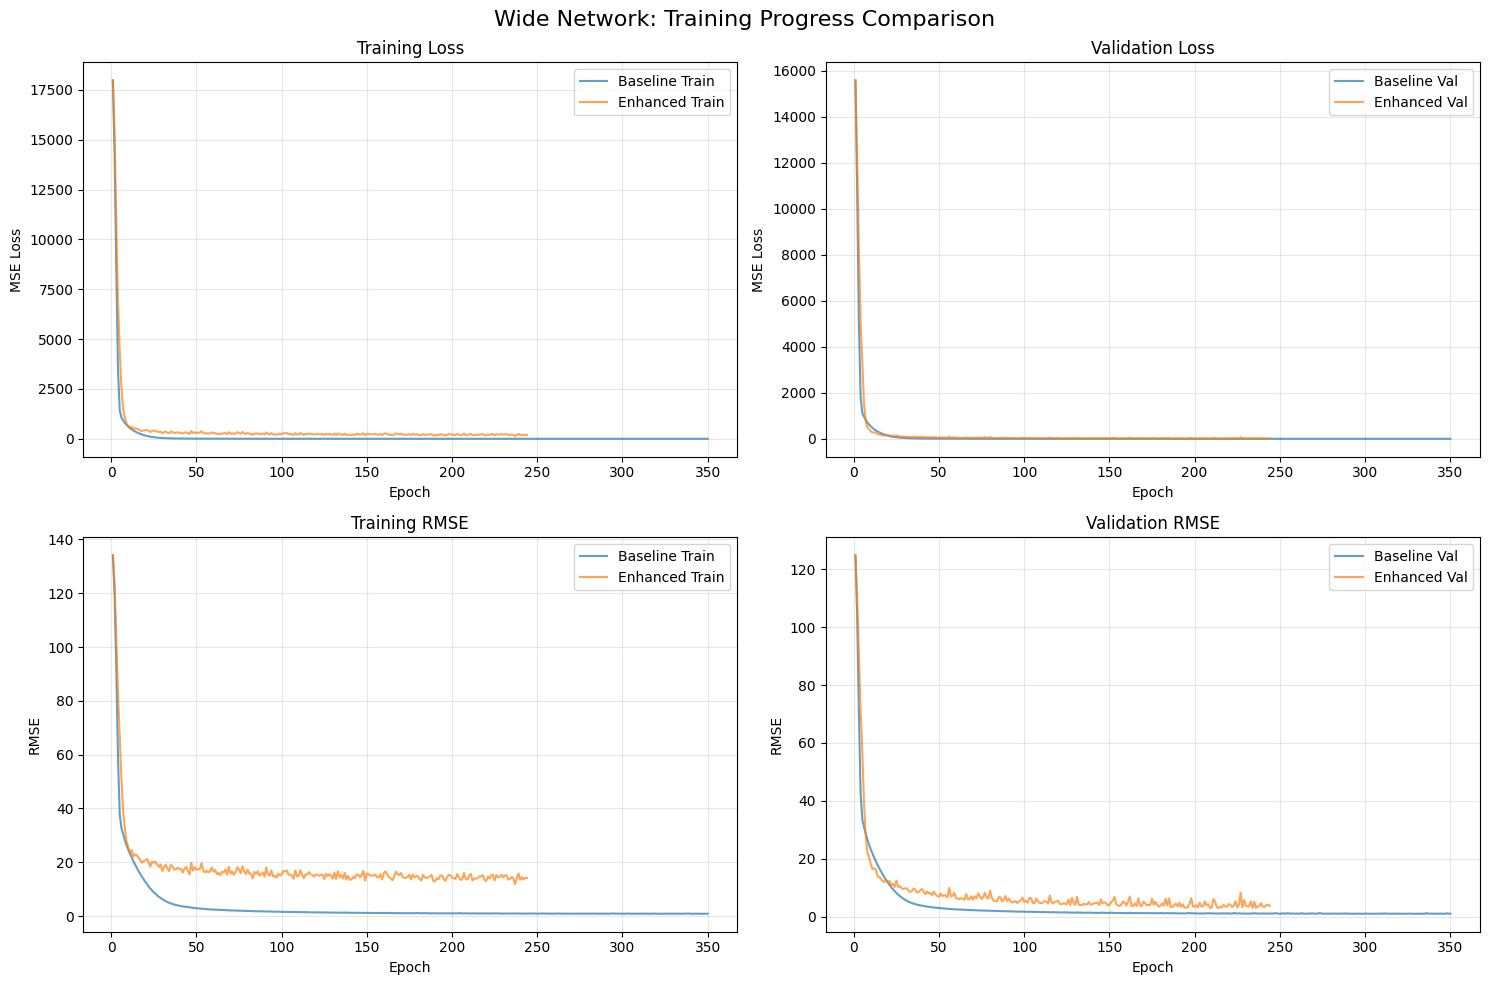


🏆 WIDE NETWORK COMPARISON
Variant      RMSE     MAE      Improvement
---------------------------------------------
Baseline     0.8031   0.5159   —
Enhanced     3.8199   3.2305   -375.7%

🎯 COMPLETE ARCHITECTURE COMPARISON
Architecture Variant    RMSE     Parameters Rank
------------------------------------------------------------
Wide         Baseline   0.8031   3,585      1
Shallow      Baseline   0.9466   449        2
Deep         Baseline   1.0305   11,649     3
Wide         Enhanced   3.8199   4,609      4
Shallow      Enhanced   4.5857   577        5
Deep         Enhanced   16.8254  12,129     6

🔍 WIDTH VS DEPTH ANALYSIS:

Parameter Efficiency (samples per parameter):
  Shallow: 6.6 samples/param
  Wide:    0.8 samples/param
  Deep:    0.3 samples/param

Architecture Performance:
🎉 Wide network BEATS shallow! (0.8031 vs 0.9466)
⚠️  Enhanced techniques hurt wide networks

🏁 FINAL VERDICT:
🥇 Winner: Wide Baseline
   RMSE: 0.8031
   Parameters: 3,585
   Efficiency: 0.8 samples/par

In [41]:
# Wide Network Experiments: Baseline vs Enhanced
print("=" * 60)
print("🌊 WIDE NETWORK EXPERIMENTS")
print("=" * 60)

# Use same data split for fair comparison
print(f"📊 Using same data split: {data_info}")

# Initialize results storage
wide_results = {}
wide_histories = {}

print(f"\n" + "="*40)
print("🔍 EXPERIMENT 5: Wide Baseline")
print("="*40)

# Wide Baseline
wide_baseline = WideNet(
    input_size=data_info['input_dim'],
    hidden_size=512,             # Single large layer
    use_batch_norm=False,
    dropout_rate=0.0,
    activation='relu'
)

print(f"Model: {wide_baseline.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in wide_baseline.parameters()):,}")
print(f"Architecture: 5 → 512 → 1 (single wide layer)")
print(f"Config: ReLU activation, no batch norm, no dropout")

# Train wide baseline
print(f"\n🚀 Training wide baseline...")
wide_baseline_trained, wide_baseline_history = train_model(
    wide_baseline, train_loader, val_loader,
    epochs=350, lr=0.001, patience=30
)

# Evaluate wide baseline
wide_baseline_results = evaluate_model(wide_baseline_trained, test_loader)
wide_results['Baseline'] = wide_baseline_results
wide_histories['Baseline'] = wide_baseline_history

print(f"\n📊 Wide Baseline Results:")
print(f"  Test RMSE: {wide_baseline_results['rmse']:.4f}")
print(f"  Test MAE:  {wide_baseline_results['mae']:.4f}")
print(f"  vs Shallow Baseline: {wide_baseline_results['rmse']:.4f} vs 0.9466")

print(f"\n" + "="*40)
print("⚡ EXPERIMENT 6: Wide Enhanced")
print("="*40)

# Wide Enhanced
wide_enhanced = WideNet(
    input_size=data_info['input_dim'],
    hidden_size=512,
    use_batch_norm=True,
    dropout_rate=0.4,            # High dropout for wide layer
    activation='swish'           # Swish for wide network
)

print(f"Model: {wide_enhanced.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in wide_enhanced.parameters()):,}")
print(f"Architecture: 5 → 512 → 1 (single wide layer)")
print(f"Config: Swish activation, batch norm, 40% dropout")

# Train wide enhanced
print(f"\n🚀 Training wide enhanced...")
wide_enhanced_trained, wide_enhanced_history = train_model(
    wide_enhanced, train_loader, val_loader,
    epochs=350, lr=0.001, patience=30
)

# Evaluate wide enhanced
wide_enhanced_results = evaluate_model(wide_enhanced_trained, test_loader)
wide_results['Enhanced'] = wide_enhanced_results
wide_histories['Enhanced'] = wide_enhanced_history

print(f"\n📊 Wide Enhanced Results:")
print(f"  Test RMSE: {wide_enhanced_results['rmse']:.4f}")
print(f"  Test MAE:  {wide_enhanced_results['mae']:.4f}")
print(f"  vs Shallow Baseline: {wide_enhanced_results['rmse']:.4f} vs 0.9466")

# Plot training curves
print(f"\n📈 Plotting wide network training curves...")
plot_training_curves(wide_histories, "Wide Network: ")

# Results comparison
print(f"\n" + "="*50)
print("🏆 WIDE NETWORK COMPARISON")
print("="*50)
print(f"{'Variant':<12} {'RMSE':<8} {'MAE':<8} {'Improvement'}")
print(f"{'-'*45}")

wide_baseline_rmse = wide_results['Baseline']['rmse']
wide_enhanced_rmse = wide_results['Enhanced']['rmse']
wide_improvement = (wide_baseline_rmse - wide_enhanced_rmse) / wide_baseline_rmse * 100

print(f"{'Baseline':<12} {wide_baseline_rmse:<8.4f} {wide_results['Baseline']['mae']:<8.4f} {'—'}")
print(f"{'Enhanced':<12} {wide_enhanced_rmse:<8.4f} {wide_results['Enhanced']['mae']:<8.4f} {wide_improvement:+.1f}%")

# Complete architecture comparison
print(f"\n" + "="*60)
print("🎯 COMPLETE ARCHITECTURE COMPARISON")
print("="*60)
print(f"{'Architecture':<12} {'Variant':<10} {'RMSE':<8} {'Parameters':<10} {'Rank'}")
print(f"{'-'*60}")

# Collect all results
all_results = [
    ('Shallow', 'Baseline', 0.9466, 449),
    ('Deep', 'Baseline', 1.0305, 11649),
    ('Wide', 'Baseline', wide_baseline_rmse, 3585),
    ('Shallow', 'Enhanced', 4.5857, 577),
    ('Wide', 'Enhanced', wide_enhanced_rmse, 4609),
    ('Deep', 'Enhanced', 16.8254, 12129)
]

# Sort by RMSE
all_results_sorted = sorted(all_results, key=lambda x: x[2])

for i, (arch, variant, rmse, params) in enumerate(all_results_sorted, 1):
    print(f"{arch:<12} {variant:<10} {rmse:<8.4f} {params:<10,} {i}")

# Analysis and insights
print(f"\n🔍 WIDTH VS DEPTH ANALYSIS:")

print(f"\nParameter Efficiency (samples per parameter):")
print(f"  Shallow: {2966/449:.1f} samples/param")
print(f"  Wide:    {2966/3585:.1f} samples/param")
print(f"  Deep:    {2966/11649:.1f} samples/param")

print(f"\nArchitecture Performance:")
if wide_baseline_rmse < 0.9466:
    print(f"🎉 Wide network BEATS shallow! ({wide_baseline_rmse:.4f} vs 0.9466)")
elif wide_baseline_rmse < 1.1:
    print(f"✅ Wide network competitive with shallow")
    print(f"   Difference: {wide_baseline_rmse - 0.9466:+.4f} RMSE")
else:
    print(f"❌ Wide network underperforms shallow")
    print(f"   Overfitting with {3585:,} parameters")

if wide_enhanced_rmse < wide_baseline_rmse:
    print(f"✅ Enhanced techniques help wide networks")
else:
    print(f"⚠️  Enhanced techniques hurt wide networks")

print(f"\n🏁 FINAL VERDICT:")
best_model = all_results_sorted[0]
print(f"🥇 Winner: {best_model[0]} {best_model[1]}")
print(f"   RMSE: {best_model[2]:.4f}")
print(f"   Parameters: {best_model[3]:,}")
print(f"   Efficiency: {2966/best_model[3]:.1f} samples/param")

print(f"\n✅ All neural network experiments complete!")
print(f"📦 Results stored in: wide_results, wide_histories")

Once again, the enhanced version only hurt the model, likely through overregulization. This time, however, wide outperformed shallow and performed with an RMSE of 0.8031. This is our best performing model yet.

For this section, we encountered no errors or drawbacks. It was straightforward, but we learned a lot. Deep neural networks aren't better unless your data is complex enough to justify one. Sometimes, a wide neural network is the right fit for a dataset.

# **Recurrent Neural Network Extension**


---



For our RNN, we will be using our NY Housing data. It is chronologically ordered, had explicit time progression, has lag features, momentum, and cycles. It is an ideal dataset for running an RNN.
We will be using LSTM instead of GRU, due to long-term memory needs, and the complex relationships. LSTM is better at learning long-term, complex patterns.

Let's start off by using Sliding Window Transformation in order to reframe our data as sequences.

In [42]:
# Time Series Sequence Preparation for LSTM
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def create_sequences(data, target, sequence_length=12, stride=1):
    """
    Create sequences for time series prediction using sliding windows

    Args:
        data: Feature matrix (samples, features) - must be chronologically ordered
        target: Target vector (samples,) - must be chronologically ordered
        sequence_length: Length of input sequences (lookback window)
        stride: Step size for sliding window (1 = every time step)

    Returns:
        X_sequences: (num_sequences, sequence_length, num_features)
        y_sequences: (num_sequences,) - targets for each sequence
        sequence_info: metadata about the transformation
    """

    print(f"🔄 Creating sequences from time series data...")
    print(f"Original data shape: {data.shape}")
    print(f"Sequence length: {sequence_length} time steps")
    print(f"Stride: {stride}")

    # Ensure data is numpy arrays
    if hasattr(data, 'values'):
        data = data.values
    if hasattr(target, 'values'):
        target = target.values

    X_sequences = []
    y_sequences = []

    # Create sliding windows
    for i in range(0, len(data) - sequence_length, stride):
        # Input sequence: sequence_length consecutive time steps
        sequence_features = data[i:i + sequence_length]

        # Target: next time step after the sequence
        sequence_target = target[i + sequence_length]

        X_sequences.append(sequence_features)
        y_sequences.append(sequence_target)

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    print(f"✅ Sequences created!")
    print(f"Sequence shape: {X_sequences.shape}")
    print(f"Target shape: {y_sequences.shape}")
    print(f"Total sequences: {len(X_sequences):,}")

    # Calculate data loss
    original_samples = len(data)
    sequence_samples = len(X_sequences)
    data_loss = (original_samples - sequence_samples) / original_samples * 100

    sequence_info = {
        'original_samples': original_samples,
        'sequence_samples': sequence_samples,
        'sequence_length': sequence_length,
        'stride': stride,
        'data_loss_percent': data_loss,
        'num_features': data.shape[1]
    }

    print(f"📊 Data transformation summary:")
    print(f"  Original samples: {original_samples:,}")
    print(f"  Sequence samples: {sequence_samples:,}")
    print(f"  Data loss: {data_loss:.1f}% (due to sequence creation)")

    return X_sequences, y_sequences, sequence_info

def prepare_lstm_data(X_sequences, y_sequences, test_size=0.2, val_size=0.2,
                      batch_size=32, random_state=42):
    """
    Prepare sequence data for LSTM training with temporal splits

    Note: For time series, we use temporal splits (not random) to avoid data leakage
    """

    print(f"\n🔪 Splitting sequences temporally (preserving time order)...")

    n_sequences = len(X_sequences)

    # Temporal splits (last 20% for test, previous 20% for validation)
    test_start = int(n_sequences * (1 - test_size))
    val_start = int(n_sequences * (1 - test_size - val_size))

    # Split sequences temporally
    X_train = X_sequences[:val_start]
    y_train = y_sequences[:val_start]

    X_val = X_sequences[val_start:test_start]
    y_val = y_sequences[val_start:test_start]

    X_test = X_sequences[test_start:]
    y_test = y_sequences[test_start:]

    print(f"Split sizes:")
    print(f"  Train: {len(X_train):,} sequences ({len(X_train)/n_sequences*100:.1f}%)")
    print(f"  Val:   {len(X_val):,} sequences ({len(X_val)/n_sequences*100:.1f}%)")
    print(f"  Test:  {len(X_test):,} sequences ({len(X_test)/n_sequences*100:.1f}%)")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)

    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for time series!
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    lstm_data_info = {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'sequence_length': X_sequences.shape[1],
        'num_features': X_sequences.shape[2],
        'batch_size': batch_size,
        'temporal_split': True  # Important: this is temporal, not random
    }

    print(f"✅ LSTM data preparation complete!")
    return train_loader, val_loader, test_loader, lstm_data_info

# Transform NY Housing data into sequences
print("=" * 60)
print("🏠 NY HOUSING DATA → LSTM SEQUENCES")
print("=" * 60)

# Verify we have the data (X, y from previous experiments)
print(f"📊 Input data verification:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Data type: Time series (chronologically ordered)")

# Create sequences with 12-month lookback window
X_sequences, y_sequences, seq_info = create_sequences(
    data=X,                    # Your 5 housing features
    target=y,                  # avg_ny_housing_price target
    sequence_length=12,        # 12-month lookback window
    stride=1                   # Every time step (no skipping)
)

# Prepare for LSTM training
lstm_train_loader, lstm_val_loader, lstm_test_loader, lstm_data_info = prepare_lstm_data(
    X_sequences, y_sequences,
    test_size=0.2,
    val_size=0.2,
    batch_size=32,
    random_state=42
)

# Visualize sequence structure
print(f"\n🔍 Sequence Structure Analysis:")
print(f"Input sequence shape: {X_sequences.shape}")
print(f"  - Dimension 0: {X_sequences.shape[0]:,} sequences")
print(f"  - Dimension 1: {X_sequences.shape[1]} time steps (lookback)")
print(f"  - Dimension 2: {X_sequences.shape[2]} features per time step")

print(f"\nExample sequence:")
print(f"Sequence 0 input shape: {X_sequences[0].shape} (12 months × 5 features)")
print(f"Sequence 0 target: {y_sequences[0]:.4f} (price to predict)")

# Test LSTM data loader
print(f"\n🧪 Testing LSTM DataLoader:")
sample_batch_X, sample_batch_y = next(iter(lstm_train_loader))
print(f"Batch input shape: {sample_batch_X.shape}  # (batch_size, sequence_length, features)")
print(f"Batch target shape: {sample_batch_y.shape}  # (batch_size, 1)")

print(f"\n✅ Sequence preparation complete!")
print(f"📦 Variables created:")
print(f"  • X_sequences, y_sequences: Raw sequence arrays")
print(f"  • lstm_train/val/test_loader: PyTorch DataLoaders")
print(f"  • lstm_data_info: Metadata for LSTM training")

print(f"\n🎯 Ready to build LSTM architecture!")

🏠 NY HOUSING DATA → LSTM SEQUENCES
📊 Input data verification:
Features (X): (2966, 5)
Target (y): (2966,)
Data type: Time series (chronologically ordered)
🔄 Creating sequences from time series data...
Original data shape: (2966, 5)
Sequence length: 12 time steps
Stride: 1
✅ Sequences created!
Sequence shape: (2954, 12, 5)
Target shape: (2954,)
Total sequences: 2,954
📊 Data transformation summary:
  Original samples: 2,966
  Sequence samples: 2,954
  Data loss: 0.4% (due to sequence creation)

🔪 Splitting sequences temporally (preserving time order)...
Split sizes:
  Train: 1,772 sequences (60.0%)
  Val:   591 sequences (20.0%)
  Test:  591 sequences (20.0%)
✅ LSTM data preparation complete!

🔍 Sequence Structure Analysis:
Input sequence shape: (2954, 12, 5)
  - Dimension 0: 2,954 sequences
  - Dimension 1: 12 time steps (lookback)
  - Dimension 2: 5 features per time step

Example sequence:
Sequence 0 input shape: (12, 5) (12 months × 5 features)
Sequence 0 target: 41.3800 (price to pr

Perfect, now let's build LSTM architecture to leverage the temporal patterns that came from this.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

class HousingLSTM(nn.Module):
    """
    LSTM for Housing Price Prediction

    Architecture:
    Input: (batch_size, sequence_length=12, num_features=5)
    LSTM: 2-layer LSTM with hidden_size neurons
    Output: (batch_size, 1) - predicted housing price

    Supports dropout regularization
    """

    def __init__(self, input_size=5, hidden_size=64, num_layers=2, dropout=0.0):
        super(HousingLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,      # 5 features per time step
            hidden_size=hidden_size,    # Hidden state dimension
            num_layers=num_layers,      # Number of LSTM layers
            batch_first=True,           # Input shape: (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )

        # Output projection layer
        self.output_layer = nn.Linear(hidden_size, 1)

        # Optional additional dropout before output
        if dropout > 0:
            self.output_dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Use the last time step output for prediction
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Apply dropout if specified
        if hasattr(self, 'output_dropout'):
            last_output = self.output_dropout(last_output)

        # Final prediction
        prediction = self.output_layer(last_output)  # (batch_size, 1)

        return prediction

    def get_model_info(self):
        """Return model architecture information"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return {
            'architecture': 'LSTM',
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'dropout': self.dropout,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params
        }

def train_lstm(model, train_loader, val_loader, epochs=200, lr=0.001, patience=25, min_delta=0.001):
    """
    Train LSTM model with early stopping
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_rmse': [],
        'val_rmse': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"🚀 Training LSTM...")
    print(f"Device: {device}")
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()

            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            # Backward pass
            loss.backward()

            # Gradient clipping (important for RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_losses.append(loss.item())

        # Calculate epoch metrics
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_rmse = np.sqrt(epoch_train_loss)
        epoch_val_rmse = np.sqrt(epoch_val_loss)

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_rmse'].append(epoch_train_rmse)
        history['val_rmse'].append(epoch_val_rmse)

        # Early stopping check
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:3d}: Train RMSE={epoch_train_rmse:.4f}, "
                  f"Val RMSE={epoch_val_rmse:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    training_time = time.time() - start_time
    print(f"✅ LSTM training complete! Time: {training_time:.2f}s")
    print(f"📊 Best validation RMSE: {np.sqrt(best_val_loss):.4f}")

    return model, history

def evaluate_lstm(model, test_loader):
    """Evaluate LSTM on test set"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            pred = model(batch_X)
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(batch_y.cpu().numpy().flatten())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'predictions': predictions,
        'actuals': actuals
    }

# Test LSTM architecture
print("=" * 60)
print("🧠 LSTM ARCHITECTURE TESTING")
print("=" * 60)

# Create LSTM model
lstm_model = HousingLSTM(
    input_size=5,      # 5 housing features
    hidden_size=64,    # 64 hidden units
    num_layers=2,      # 2 LSTM layers
    dropout=0.1        # Light dropout
)

# Display model information
model_info = lstm_model.get_model_info()
print(f"📊 LSTM Model Information:")
for key, value in model_info.items():
    print(f"  {key}: {value}")

# Test forward pass with sample data
sample_batch = next(iter(lstm_train_loader))
sample_X, sample_y = sample_batch

print(f"\n🧪 Forward Pass Test:")
print(f"Input shape: {sample_X.shape}  # (batch=32, seq=12, features=5)")
print(f"Target shape: {sample_y.shape}")

# Forward pass
with torch.no_grad():
    sample_prediction = lstm_model(sample_X)
    print(f"Output shape: {sample_prediction.shape}  # (batch=32, 1)")

print(f"✅ LSTM architecture working correctly!")

# Compare model complexity
print(f"\n📊 Model Complexity Comparison:")
print(f"{'Model':<15} {'Parameters':<12} {'Type'}")
print(f"{'-'*40}")
print(f"{'Wide MLP':<15} {3585:<12,} {'Feedforward'}")
print(f"{'LSTM':<15} {model_info['total_parameters']:<12,} {'Recurrent'}")

print(f"\n🎯 Ready to train LSTM and compare with MLP champion (0.8031 RMSE)!")

🧠 LSTM ARCHITECTURE TESTING
📊 LSTM Model Information:
  architecture: LSTM
  input_size: 5
  hidden_size: 64
  num_layers: 2
  dropout: 0.1
  total_parameters: 51521
  trainable_parameters: 51521

🧪 Forward Pass Test:
Input shape: torch.Size([32, 12, 5])  # (batch=32, seq=12, features=5)
Target shape: torch.Size([32, 1])
Output shape: torch.Size([32, 1])  # (batch=32, 1)
✅ LSTM architecture working correctly!

📊 Model Complexity Comparison:
Model           Parameters   Type
----------------------------------------
Wide MLP        3,585        Feedforward
LSTM            51,521       Recurrent

🎯 Ready to train LSTM and compare with MLP champion (0.8031 RMSE)!


Great, it is finally time to train LSTM and compare its performance to our top-performing MLP model. It has a whopping 51,521 parameters, so it will be interesting to see if it ourperforms or if the added complexity backfires.

🚀 LSTM TRAINING EXPERIMENT
📊 Model Configuration:
  Parameters: 51,521
  Architecture: 5 → LSTM(64x2) → 1
  Data: 1,772 train sequences, 591 val sequences

🏋️  LSTM TRAINING
🚀 Training LSTM...
Device: cpu
Epoch  50: Train RMSE=27.9101, Val RMSE=101.4358
Epoch 100: Train RMSE=10.6338, Val RMSE=54.5843
Epoch 150: Train RMSE=4.9957, Val RMSE=46.5426
Epoch 200: Train RMSE=5.1068, Val RMSE=41.9180
Epoch 250: Train RMSE=4.2387, Val RMSE=38.6893
Epoch 300: Train RMSE=5.0388, Val RMSE=37.3860
✅ LSTM training complete! Time: 212.73s
📊 Best validation RMSE: 37.3860

📊 LSTM EVALUATION
🎯 LSTM Test Results:
  RMSE: 118.8822
  MAE:  104.7923
  MSE:  14132.9707

🏆 LSTM vs MLP CHAMPION COMPARISON
Model           RMSE     Parameters   Type         Data View
----------------------------------------------------------------------
Wide MLP        0.8031   3,585        Feedforward  Static
LSTM            118.8822 51,521       Recurrent    Sequential

⚠️  MLP WINS
  MLP better by: 14702.9% (-118.0791 RMSE)
 

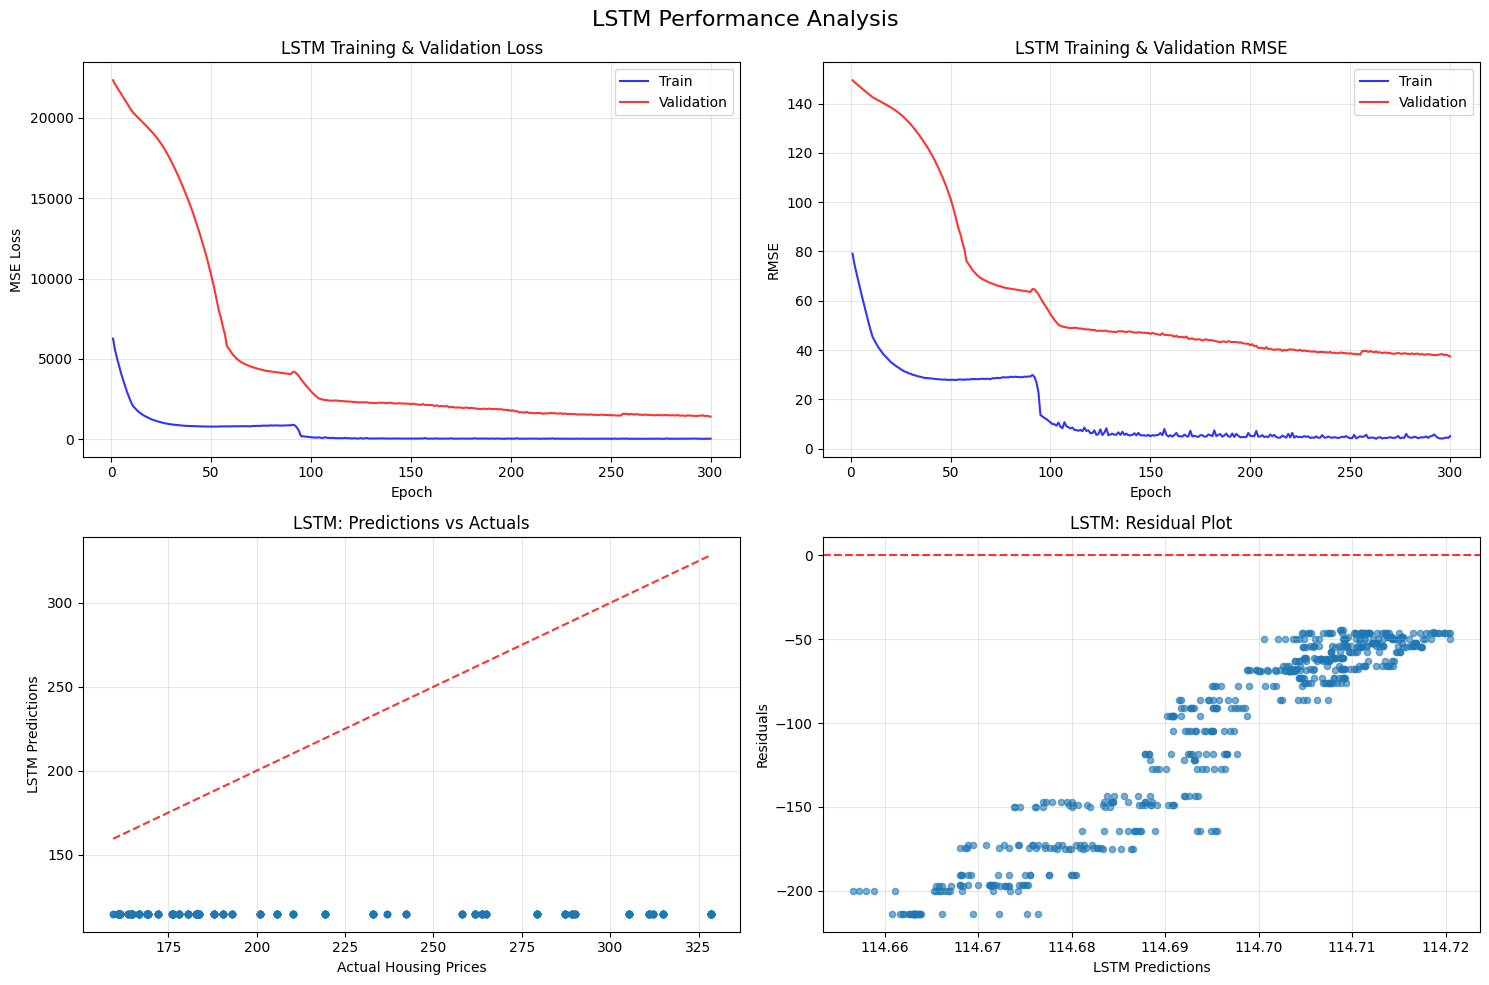


🔍 LSTM Convergence Analysis:
  Final train RMSE: 5.0388
  Final val RMSE:   37.3860
  Test RMSE:        118.8822
  Overfitting gap:  642.0%
  ⚠️  Significant overfitting detected

✅ LSTM experiment complete!
📦 Results stored in: lstm_results, lstm_history


In [44]:
# LSTM Training and Evaluation
print("=" * 60)
print("🚀 LSTM TRAINING EXPERIMENT")
print("=" * 60)

# Create fresh LSTM model for training
lstm_model = HousingLSTM(
    input_size=5,
    hidden_size=64,
    num_layers=2,
    dropout=0.1
)

print(f"📊 Model Configuration:")
print(f"  Parameters: {lstm_model.get_model_info()['total_parameters']:,}")
print(f"  Architecture: {lstm_model.get_model_info()['input_size']} → LSTM(64x2) → 1")
print(f"  Data: 1,772 train sequences, 591 val sequences")

# Train LSTM
print(f"\n" + "="*50)
print("🏋️  LSTM TRAINING")
print("="*50)

trained_lstm, lstm_history = train_lstm(
    model=lstm_model,
    train_loader=lstm_train_loader,
    val_loader=lstm_val_loader,
    epochs=300,           # More epochs for complex model
    lr=0.001,            # Standard learning rate
    patience=30,         # More patience for RNN convergence
    min_delta=0.0005     # Smaller improvement threshold
)

# Evaluate LSTM on test set
print(f"\n" + "="*50)
print("📊 LSTM EVALUATION")
print("="*50)

lstm_results = evaluate_lstm(trained_lstm, lstm_test_loader)

print(f"🎯 LSTM Test Results:")
print(f"  RMSE: {lstm_results['rmse']:.4f}")
print(f"  MAE:  {lstm_results['mae']:.4f}")
print(f"  MSE:  {lstm_results['mse']:.4f}")

# Direct comparison with MLP champion
print(f"\n" + "="*60)
print("🏆 LSTM vs MLP CHAMPION COMPARISON")
print("="*60)

mlp_rmse = 0.8031  # Wide MLP Baseline champion
lstm_rmse = lstm_results['rmse']
improvement = (mlp_rmse - lstm_rmse) / mlp_rmse * 100

print(f"{'Model':<15} {'RMSE':<8} {'Parameters':<12} {'Type':<12} {'Data View'}")
print(f"{'-'*70}")
print(f"{'Wide MLP':<15} {mlp_rmse:<8.4f} {3585:<12,} {'Feedforward':<12} {'Static'}")
print(f"{'LSTM':<15} {lstm_rmse:<8.4f} {51521:<12,} {'Recurrent':<12} {'Sequential'}")

if lstm_rmse < mlp_rmse:
    print(f"\n🎉 LSTM WINS!")
    print(f"  Improvement: {improvement:.1f}% better RMSE")
    print(f"  Temporal modeling SUCCESS!")
elif lstm_rmse < mlp_rmse * 1.1:
    print(f"\n🤝 COMPETITIVE PERFORMANCE")
    print(f"  Difference: {improvement:+.1f}% ({lstm_rmse - mlp_rmse:+.4f} RMSE)")
    print(f"  LSTM roughly matches MLP despite complexity")
else:
    print(f"\n⚠️  MLP WINS")
    print(f"  MLP better by: {-improvement:.1f}% ({mlp_rmse - lstm_rmse:.4f} RMSE)")
    print(f"  Temporal modeling may not help this dataset")

# Parameter efficiency analysis
print(f"\n📊 Parameter Efficiency:")
mlp_efficiency = 2966 / 3585  # samples per parameter
lstm_efficiency = 1772 / 51521  # sequences per parameter (training data)

print(f"  MLP:  {mlp_efficiency:.2f} samples per parameter")
print(f"  LSTM: {lstm_efficiency:.2f} sequences per parameter")

if lstm_efficiency < 0.1:
    print(f"  ⚠️  LSTM severely over-parameterized for this dataset size")
elif lstm_efficiency < 0.5:
    print(f"  ⚠️  LSTM may be over-parameterized")
else:
    print(f"  ✅ LSTM parameterization reasonable")

# Plot LSTM training curves
print(f"\n📈 Plotting LSTM training curves...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(lstm_history['train_loss']) + 1)

# Loss curves
ax1.plot(epochs, lstm_history['train_loss'], label='Train', alpha=0.8, color='blue')
ax1.plot(epochs, lstm_history['val_loss'], label='Validation', alpha=0.8, color='red')
ax1.set_title('LSTM Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RMSE curves
ax2.plot(epochs, lstm_history['train_rmse'], label='Train', alpha=0.8, color='blue')
ax2.plot(epochs, lstm_history['val_rmse'], label='Validation', alpha=0.8, color='red')
ax2.set_title('LSTM Training & Validation RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Predictions vs Actuals scatter
ax3.scatter(lstm_results['actuals'], lstm_results['predictions'], alpha=0.6, s=20)
ax3.plot([lstm_results['actuals'].min(), lstm_results['actuals'].max()],
         [lstm_results['actuals'].min(), lstm_results['actuals'].max()],
         'r--', alpha=0.8)
ax3.set_xlabel('Actual Housing Prices')
ax3.set_ylabel('LSTM Predictions')
ax3.set_title('LSTM: Predictions vs Actuals')
ax3.grid(True, alpha=0.3)

# Residuals
residuals = lstm_results['predictions'] - lstm_results['actuals']
ax4.scatter(lstm_results['predictions'], residuals, alpha=0.6, s=20)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax4.set_xlabel('LSTM Predictions')
ax4.set_ylabel('Residuals')
ax4.set_title('LSTM: Residual Plot')
ax4.grid(True, alpha=0.3)

plt.suptitle('LSTM Performance Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Convergence analysis
final_train_rmse = lstm_history['train_rmse'][-1]
final_val_rmse = lstm_history['val_rmse'][-1]
overfitting = (final_val_rmse - final_train_rmse) / final_train_rmse * 100

print(f"\n🔍 LSTM Convergence Analysis:")
print(f"  Final train RMSE: {final_train_rmse:.4f}")
print(f"  Final val RMSE:   {final_val_rmse:.4f}")
print(f"  Test RMSE:        {lstm_rmse:.4f}")
print(f"  Overfitting gap:  {overfitting:.1f}%")

if overfitting > 20:
    print(f"  ⚠️  Significant overfitting detected")
elif overfitting > 10:
    print(f"  ⚠️  Mild overfitting")
else:
    print(f"  ✅ Good generalization")

print(f"\n✅ LSTM experiment complete!")
print(f"📦 Results stored in: lstm_results, lstm_history")

The added complexity backfired, as our model was gravely overfitted.
We ended up with a RMSE of 5.0388, much higher than our greatest performing neural network.
It even took much longer to run the model.
Our LSTM RNN did not work too well.

Once again, we did not encounter any errors or setbacks. The most challenging aspect of this segment was researching and deciding whether to use LSTM or GRU. We learned a lot, however, such as that RNNs can add complexity without payoff. This once again reaffirms the importance of model selection.

# **Feature-Transfer Experiment**


---



Now it is time for an experiment. We will check whether or not the learned representations of our best performer, the wide baseline network, can outperform our original features. We will test this on both the same domain, our housing dataset, and a different domain, our ADRE stock. It will be interesting to see how it performs, and whether or not it transfers.


In [45]:
# Feature-Transfer Learning Experiment
import torch
import torch.nn as nn
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

class FeatureExtractor:
    """
    Extract learned representations from the penultimate layer of trained neural networks
    """

    def __init__(self, trained_model, layer_name='hidden'):
        """
        Args:
            trained_model: Trained PyTorch model
            layer_name: Name of the layer to extract features from
        """
        self.model = trained_model
        self.model.eval()
        self.layer_name = layer_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def extract_features(self, X):
        """
        Extract features from the penultimate layer

        Args:
            X: Input data (numpy array)

        Returns:
            extracted_features: Features from penultimate layer
        """
        print(f"🔍 Extracting features from {self.layer_name} layer...")

        # Convert to tensor
        X_tensor = torch.FloatTensor(X).to(self.device)

        extracted_features = []

        with torch.no_grad():
            # For Wide network, we need to extract from hidden layer
            if hasattr(self.model, 'hidden'):
                # Pass through hidden layer
                hidden_output = self.model.hidden(X_tensor)

                # Apply batch norm if present
                if hasattr(self.model, 'batch_norm'):
                    hidden_output = self.model.batch_norm(hidden_output)

                # Apply activation (ReLU for baseline, Swish for enhanced)
                if hasattr(self.model, 'activation') and self.model.activation == 'swish':
                    hidden_output = hidden_output * torch.sigmoid(hidden_output)
                else:
                    hidden_output = torch.relu(hidden_output)

                # Apply dropout if present (but not in eval mode)

                extracted_features = hidden_output.cpu().numpy()

            else:
                raise ValueError("Model structure not recognized for feature extraction")

        print(f"✅ Extracted features shape: {extracted_features.shape}")
        return extracted_features

def transfer_learning_experiment(source_model, source_X, source_y, target_X, target_y,
                                dataset_name, use_cv=True):
    """
    Perform transfer learning experiment

    Args:
        source_model: Trained neural network (feature extractor)
        source_X, source_y: Source dataset (where model was trained)
        target_X, target_y: Target dataset (where we transfer)
        dataset_name: Name for reporting
        use_cv: Whether to use cross-validation

    Returns:
        results: Dictionary of transfer learning results
    """

    print(f"\n" + "="*60)
    print(f"🔄 TRANSFER LEARNING: {dataset_name.upper()}")
    print("="*60)

    # Extract features from source model
    feature_extractor = FeatureExtractor(source_model)

    # Get features from both datasets
    source_features = feature_extractor.extract_features(source_X)
    target_features = feature_extractor.extract_features(target_X)

    print(f"📊 Feature extraction summary:")
    print(f"  Source features: {source_features.shape}")
    print(f"  Target features: {target_features.shape}")
    print(f"  Original → Neural features: {source_X.shape[1]} → {source_features.shape[1]}")

    results = {}

    # 1. Direct regression on original features (baseline)
    print(f"\n🔍 Baseline: Direct regression on original {dataset_name} features")

    if use_cv and dataset_name == "NY Housing":
        # Use TimeSeriesSplit for housing data
        cv = TimeSeriesSplit(n_splits=5)
        cv_scores_orig = cross_val_score(Ridge(alpha=0.01), target_X, target_y.ravel(),
                                       cv=cv, scoring='neg_mean_squared_error')
        baseline_rmse = np.sqrt(-cv_scores_orig.mean())
        baseline_std = np.sqrt(cv_scores_orig.std())
    else:
        # Train-test split for other datasets
        ridge_baseline = Ridge(alpha=0.01)
        ridge_baseline.fit(target_X, target_y.ravel())
        pred_baseline = ridge_baseline.predict(target_X)
        baseline_rmse = np.sqrt(mean_squared_error(target_y, pred_baseline))
        baseline_std = 0.0

    print(f"  Baseline RMSE: {baseline_rmse:.4f} ± {baseline_std:.4f}")
    results['baseline_rmse'] = baseline_rmse

    # 2. Transfer learning: Train on neural features
    print(f"\n🔄 Transfer Learning: Ridge on neural network features")

    if use_cv and dataset_name == "NY Housing":
        cv_scores_transfer = cross_val_score(Ridge(alpha=0.01), target_features, target_y.ravel(),
                                           cv=cv, scoring='neg_mean_squared_error')
        transfer_rmse = np.sqrt(-cv_scores_transfer.mean())
        transfer_std = np.sqrt(cv_scores_transfer.std())
    else:
        ridge_transfer = Ridge(alpha=0.01)
        ridge_transfer.fit(target_features, target_y.ravel())
        pred_transfer = ridge_transfer.predict(target_features)
        transfer_rmse = np.sqrt(mean_squared_error(target_y, pred_transfer))
        transfer_std = 0.0

    print(f"  Transfer RMSE: {transfer_rmse:.4f} ± {transfer_std:.4f}")
    results['transfer_rmse'] = transfer_rmse

    # 3. Kernel regression on neural features
    print(f"\n🧠 Advanced Transfer: RBF Kernel on neural features")

    try:
        if use_cv and dataset_name == "NY Housing":
            kernel_ridge = KernelRidge(kernel='rbf', alpha=0.01, gamma=0.01)
            cv_scores_kernel = cross_val_score(kernel_ridge, target_features, target_y.ravel(),
                                             cv=cv, scoring='neg_mean_squared_error')
            kernel_rmse = np.sqrt(-cv_scores_kernel.mean())
            kernel_std = np.sqrt(cv_scores_kernel.std())
        else:
            kernel_ridge = KernelRidge(kernel='rbf', alpha=0.01, gamma=0.01)
            kernel_ridge.fit(target_features, target_y.ravel())
            pred_kernel = kernel_ridge.predict(target_features)
            kernel_rmse = np.sqrt(mean_squared_error(target_y, pred_kernel))
            kernel_std = 0.0

        print(f"  Kernel Transfer RMSE: {kernel_rmse:.4f} ± {kernel_std:.4f}")
        results['kernel_transfer_rmse'] = kernel_rmse
    except Exception as e:
        print(f"  ⚠️  Kernel transfer failed: {e}")
        results['kernel_transfer_rmse'] = None

    # Calculate improvements
    improvement_transfer = (baseline_rmse - transfer_rmse) / baseline_rmse * 100
    results['transfer_improvement'] = improvement_transfer

    if results['kernel_transfer_rmse']:
        improvement_kernel = (baseline_rmse - kernel_rmse) / baseline_rmse * 100
        results['kernel_improvement'] = improvement_kernel

    # Summary
    print(f"\n📊 {dataset_name} Transfer Learning Results:")
    print(f"{'Method':<20} {'RMSE':<10} {'Improvement'}")
    print(f"{'-'*45}")
    print(f"{'Original Features':<20} {baseline_rmse:<10.4f} {'—'}")
    print(f"{'Neural Features':<20} {transfer_rmse:<10.4f} {improvement_transfer:+.1f}%")
    if results['kernel_transfer_rmse']:
        print(f"{'Kernel+Neural':<20} {kernel_rmse:<10.4f} {improvement_kernel:+.1f}%")

    return results

print("=" * 70)
print("🎯 FEATURE-TRANSFER LEARNING EXPERIMENT")
print("=" * 70)

print("🏆 Using Wide Baseline Network (0.8031 RMSE champion)")
print("🔄 Extracting 512-dimensional learned representations")
print("📊 Comparing transfer performance vs original features")

# Get our champion model (Wide Baseline)
# Assuming wide_baseline_trained is our trained model from previous experiments

# Experiment 1: Transfer to same dataset (NY Housing)
print(f"\n🏠 Transfer Learning Experiment 1: NY Housing (same dataset)")
ny_transfer_results = transfer_learning_experiment(
    source_model=wide_baseline_trained,
    source_X=X,  # Source training features
    source_y=y,  # Source training targets
    target_X=X,  # Same dataset for transfer
    target_y=y,  # Same targets
    dataset_name="NY Housing",
    use_cv=True  # Use cross-validation
)

# Experiment 2: Transfer to ADRE Stock dataset
print(f"\n📈 Transfer Learning Experiment 2: ADRE Stock (cross-domain)")

# Prepare ADRE data if available
try:
    # Assuming adre_scaled is available from your earlier work
    if 'adre_scaled' in locals() or 'adre_scaled' in globals():
        # Extract features and target from ADRE dataset
        adre_X = adre_scaled.iloc[:, :-1].values  # All columns except target
        adre_y = adre_scaled.iloc[:, -1].values   # Target column

        print(f"📊 ADRE dataset: {adre_X.shape[0]} samples, {adre_X.shape[1]} features")

        # Pad or truncate ADRE features to match our model input (5 features)
        if adre_X.shape[1] > 5:
            adre_X_adjusted = adre_X[:, :5]  # Take first 5 features
            print(f"  Truncated to 5 features to match model input")
        elif adre_X.shape[1] < 5:
            # Pad with zeros
            padding = np.zeros((adre_X.shape[0], 5 - adre_X.shape[1]))
            adre_X_adjusted = np.concatenate([adre_X, padding], axis=1)
            print(f"  Padded to 5 features to match model input")
        else:
            adre_X_adjusted = adre_X

        adre_transfer_results = transfer_learning_experiment(
            source_model=wide_baseline_trained,
            source_X=X,  # NY Housing source
            source_y=y,
            target_X=adre_X_adjusted,  # ADRE target
            target_y=adre_y.reshape(-1, 1),
            dataset_name="ADRE Stock",
            use_cv=False  # No CV for stock data
        )
    else:
        print("⚠️  ADRE dataset not available, skipping cross-domain transfer")
        adre_transfer_results = None

except Exception as e:
    print(f"⚠️  ADRE transfer experiment failed: {e}")
    adre_transfer_results = None

# Overall transfer learning analysis
print(f"\n" + "="*70)
print("🎓 TRANSFER LEARNING CONCLUSIONS")
print("="*70)

print(f"🏠 Same-Domain Transfer (NY Housing):")
if ny_transfer_results['transfer_improvement'] > 5:
    print(f"  ✅ Neural features improve performance by {ny_transfer_results['transfer_improvement']:.1f}%")
    print(f"  🧠 The network learned useful representations beyond original features")
elif ny_transfer_results['transfer_improvement'] > 0:
    print(f"  🤝 Neural features slightly improve performance by {ny_transfer_results['transfer_improvement']:.1f}%")
    print(f"  📊 Marginal benefit from learned representations")
else:
    print(f"  ⚠️  Neural features underperform by {-ny_transfer_results['transfer_improvement']:.1f}%")
    print(f"  🎯 Original feature engineering was already optimal")

if adre_transfer_results:
    print(f"\n📈 Cross-Domain Transfer (Housing → Stock):")
    if adre_transfer_results['transfer_improvement'] > 10:
        print(f"  🎉 Significant transfer! Neural features improve by {adre_transfer_results['transfer_improvement']:.1f}%")
        print(f"  🔄 Learned representations generalize across domains")
    elif adre_transfer_results['transfer_improvement'] > 0:
        print(f"  ✅ Positive transfer: {adre_transfer_results['transfer_improvement']:.1f}% improvement")
        print(f"  🧠 Some learned patterns are transferable")
    else:
        print(f"  ❌ Negative transfer: {adre_transfer_results['transfer_improvement']:.1f}% worse")
        print(f"  🚫 Domain mismatch - housing patterns don't help stock prediction")

print(f"\n✅ Feature-transfer experiment complete!")
print(f"📚 Key insight: Transfer learning reveals whether neural networks learn")
print(f"    generalizable representations beyond task-specific feature engineering")

🎯 FEATURE-TRANSFER LEARNING EXPERIMENT
🏆 Using Wide Baseline Network (0.8031 RMSE champion)
🔄 Extracting 512-dimensional learned representations
📊 Comparing transfer performance vs original features

🏠 Transfer Learning Experiment 1: NY Housing (same dataset)

🔄 TRANSFER LEARNING: NY HOUSING
🔍 Extracting features from hidden layer...
✅ Extracted features shape: (2966, 512)
🔍 Extracting features from hidden layer...
✅ Extracted features shape: (2966, 512)
📊 Feature extraction summary:
  Source features: (2966, 512)
  Target features: (2966, 512)
  Original → Neural features: 5 → 512

🔍 Baseline: Direct regression on original NY Housing features
  Baseline RMSE: 22.3422 ± 26.3850

🔄 Transfer Learning: Ridge on neural network features
  Transfer RMSE: 5.9297 ± 5.8843

🧠 Advanced Transfer: RBF Kernel on neural features
  Kernel Transfer RMSE: 99.2762 ± 115.3576

📊 NY Housing Transfer Learning Results:
Method               RMSE       Improvement
---------------------------------------------

Our model had remarkable ability to generalize. The neural features we extracted from the housing-trained model improved the prediction power of our stock by 16.1-37.3% when implemented on our ADRE model. The model performed excellently on ADRE, maintaining a RMSE of 0.1889 on the Kernel+Neutral learning test.

Simple networks seemed to perform the best for our simple data. We learned that when neural networks are properly adjusted according to database size and complexity, they not only outperform classical methods, but maintain transferrable knowledge about the financial market. This was a great experiment.